# Factor analysis

## 1) Imports & helpers

In [174]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.7 kB/s eta 0:00:00a 0:00:07


In [2]:
import numpy as np
import pandas as pd
import shap
import warnings

from pathlib import Path
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, balanced_accuracy_score
from sklearn.metrics import classification_report
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibratedClassifierCV

# Try xgboost; fallback to RandomForest if not installed
try:
    from xgboost import XGBClassifier
    HAVE_XGB = True
except Exception:
    from sklearn.ensemble import RandomForestClassifier
    HAVE_XGB = False

warnings.filterwarnings("ignore")
np.random.seed(42)


/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 2) Load + choose columns

In [ ]:
# df = pd.read_csv('.//result//gemini-2.5-flash.csv')
# df_info = pd.read_csv("result/hotspot_control_filtered.csv")

# # get hotspot_control, all_label, motorcycle_label from df_info to df by image_id
# df = df.merge(df_info[['image_id', 'hotspot_control', 'all_label', 'motorcycle_label']], on='image_id', how='left')

# # rename columns
# df.rename(columns={'all_label': 'AADT_all'}, inplace=True)
# df.rename(columns={'motorcycle_label': 'AADT_motorcycle'}, inplace=True)

# # drop unneeded columns (F1-weighted < 0.7)
# df.drop(columns=['Paved shoulder - driver-side', 'Paved shoulder - passenger-side','Number of lanes'], inplace=True)

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# -------------------------
# 0. Load and merge
# -------------------------
df = pd.read_csv('/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/result/gemini-2.5-flash.csv')
df_info = pd.read_csv("/Users/stupong/Library/CloudStorage/OneDrive-UniversityCollegeLondon/Natchapon PhD/Upgrading/PhD/NKDE/result/hotspot_control_filtered.csv")

df = df.merge(
    df_info[['image_id', 'hotspot_control', 'all_label', 'motorcycle_label']],
    on='image_id',
    how='left'
)

df = df.rename(columns={
    'all_label': 'AADT_all',
    'motorcycle_label': 'AADT_motorcycle'
})

# Drop low-F1 features
df = df.drop(
    columns=['Paved shoulder - driver-side',
             'Paved shoulder - passenger-side',
             'Number of lanes']
)

# Make sure AADT_motorcycle has *no* missing values
# 1) Replace string "nan"/"NaN" with real np.nan if they exist
df['AADT_motorcycle'] = df['AADT_motorcycle'].replace(["nan", "NaN", "None", ""], np.nan)

# 2) Now drop all rows with true NaNs in that column
df = df.dropna(subset=['AADT_motorcycle']).copy()

# OPTIONAL: Check that there are really no NaNs left
print("NaNs in AADT_motorcycle:", df['AADT_motorcycle'].isna().sum())
print("Unique AADT_motorcycle:", df['AADT_motorcycle'].unique())


NaNs in AADT_motorcycle: 0
Unique AADT_motorcycle: ['low' 'med' 'high' 'lowest' 'highest']


In [ ]:
# drop df['AADT_motorcycle'] == nan
# df = df.dropna(subset=['AADT_motorcycle'])

In [5]:
for col in df.columns:
    if col != "image_id":
        print(f"\n=== {col} ===")
        print(df[col].value_counts(dropna=False))



=== Differential speed limits ===
Differential speed limits
Not present    7264
Present          12
Name: count, dtype: int64

=== Median type ===
Median type
Centre line                         2350
Physical median width 1 to <5m      1426
Safety barrier - concrete           1176
Physical median width 5 to <10m     1096
Safety barrier - metal               305
Physical median width 10 to <20m     266
Physical median width 0 to <1m       246
Central hatching >1m                 228
Physical median width ≥20m           143
One way                               23
Wide centre line 0.3m to 1m           12
Continuous central turning lane        3
Flexible posts                         2
Name: count, dtype: int64

=== Centreline rumble strips ===
Centreline rumble strips
Not present    7270
Present           6
Name: count, dtype: int64

=== Roadside severity - driver-side distance ===
Roadside severity - driver-side distance
0 to <1m     2981
1 to <5m     2765
5 to <10m     819
≥10m       

### plot all features

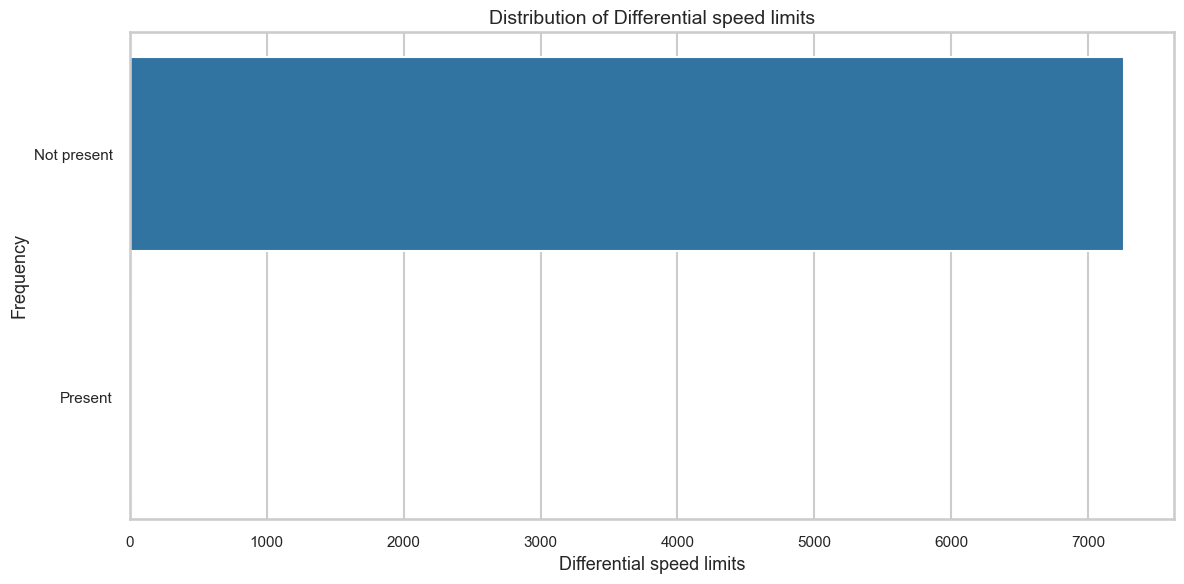

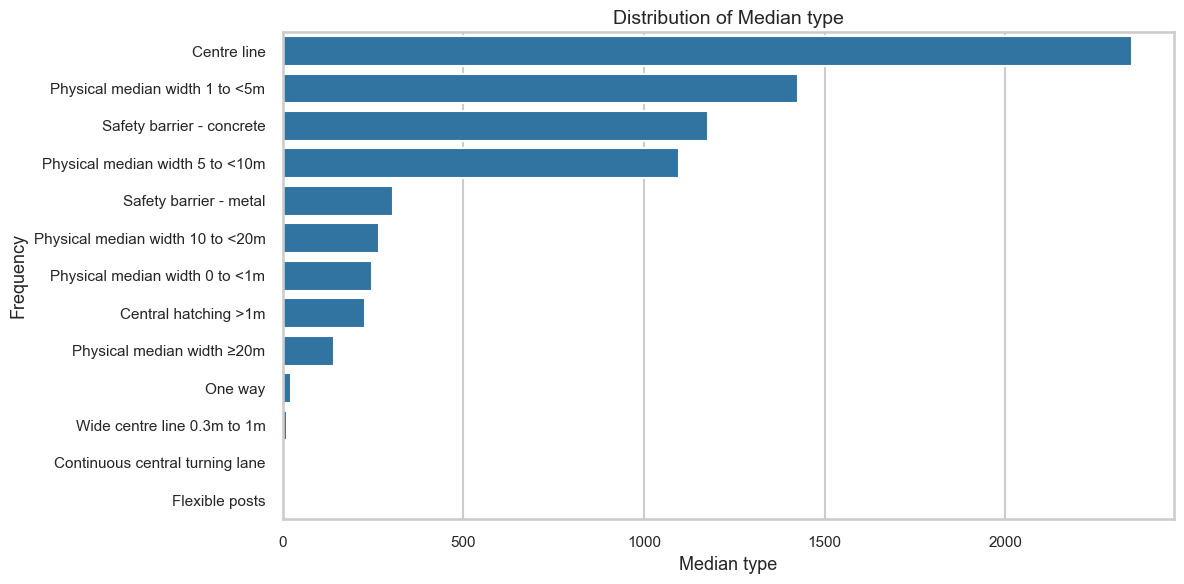

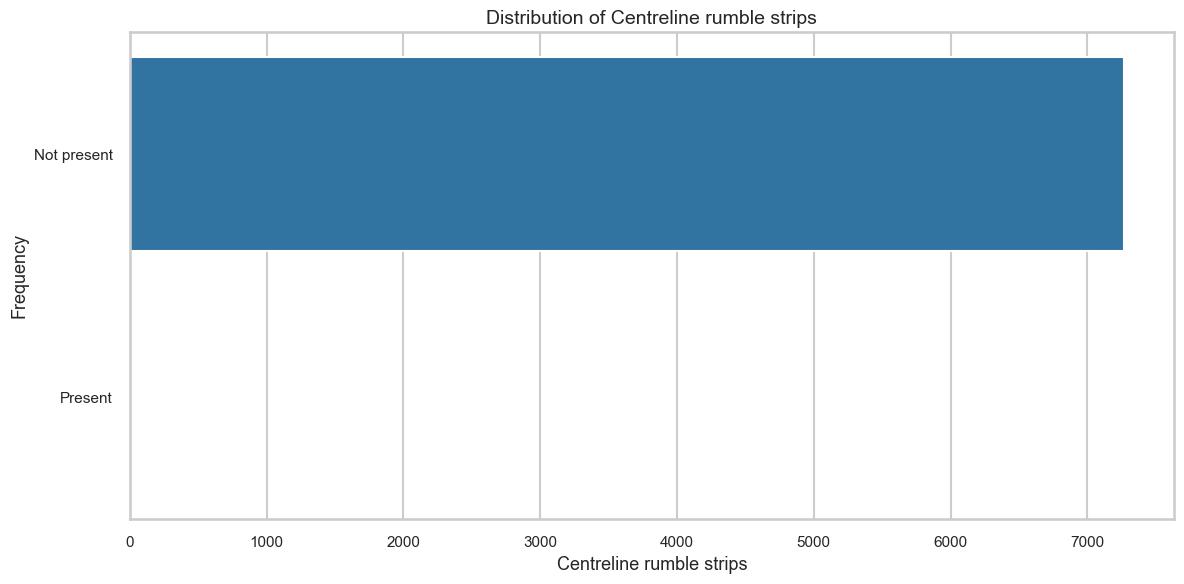

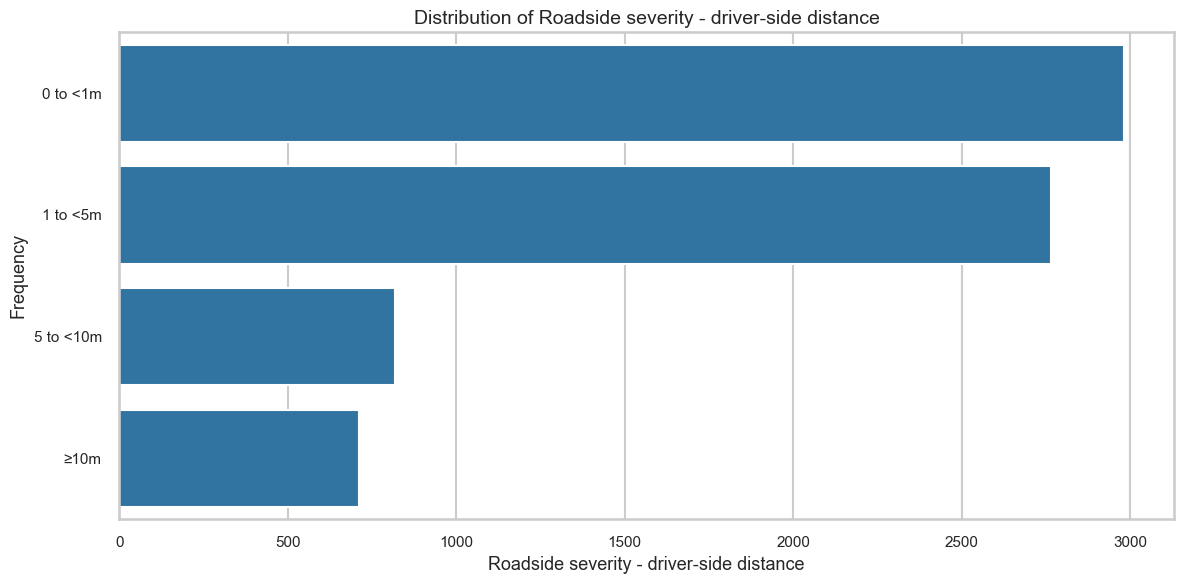

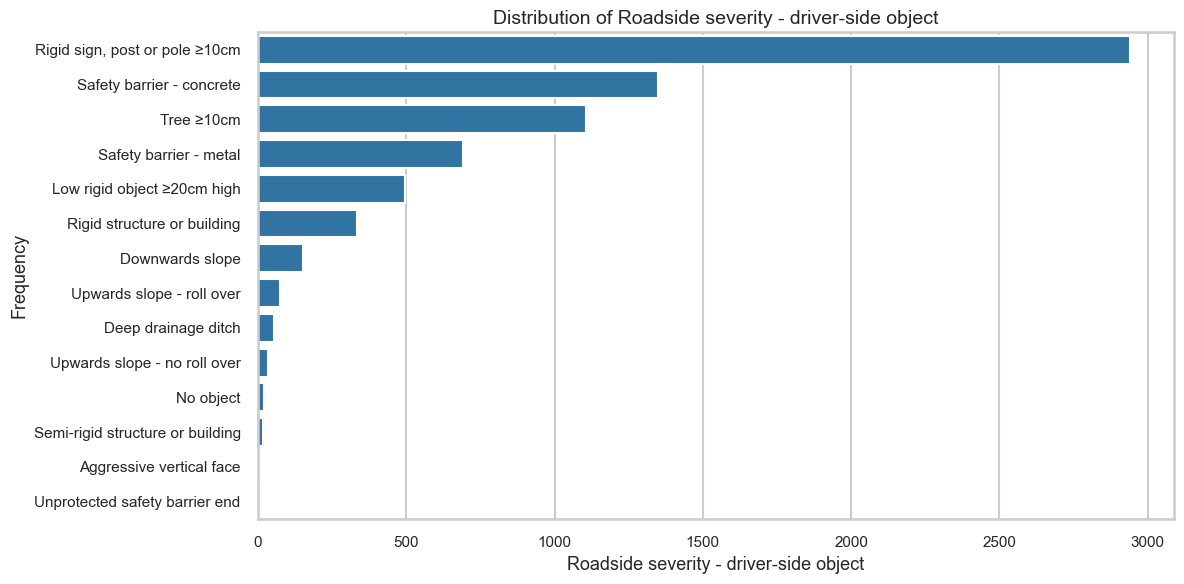

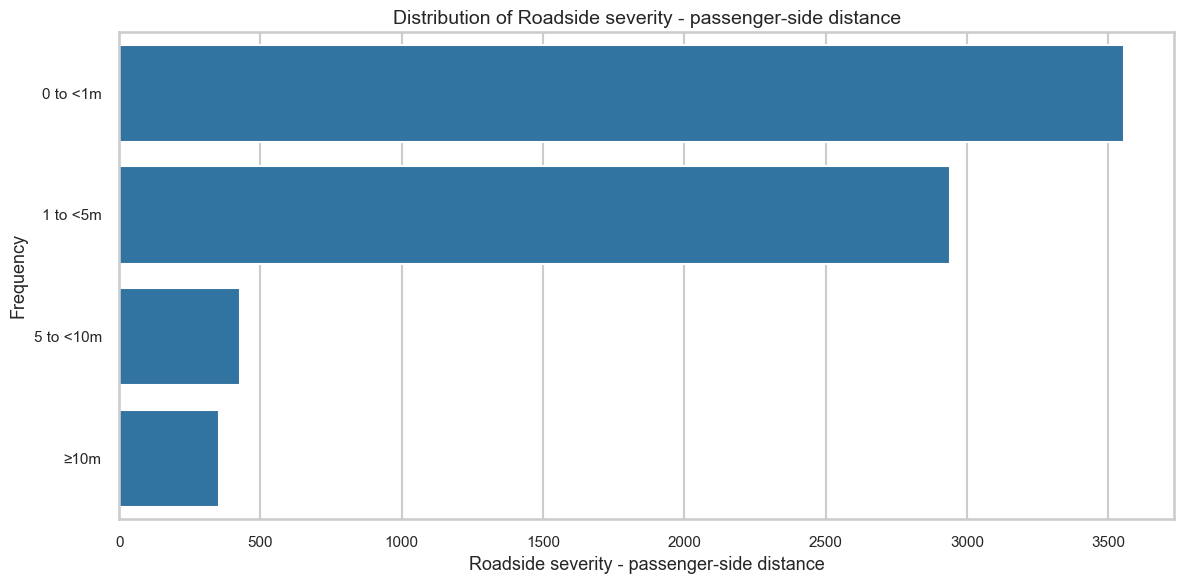

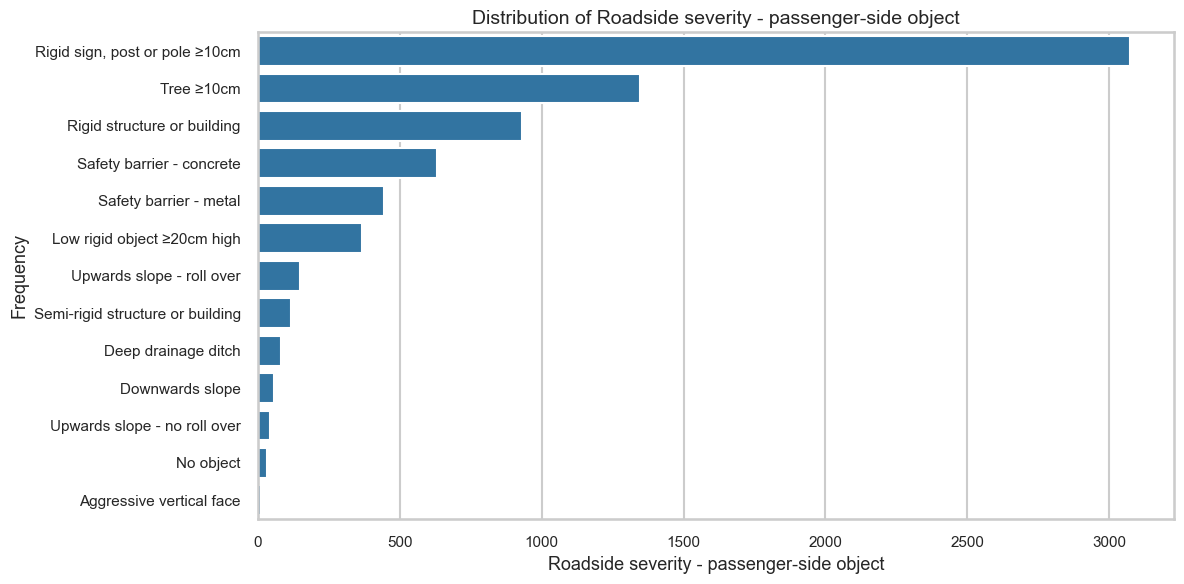

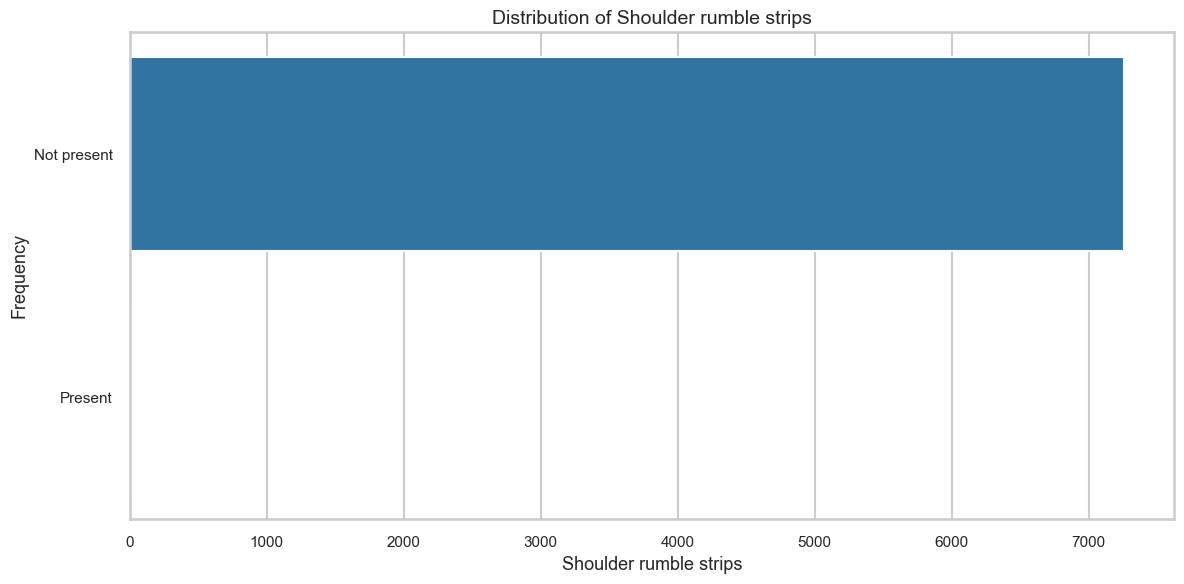

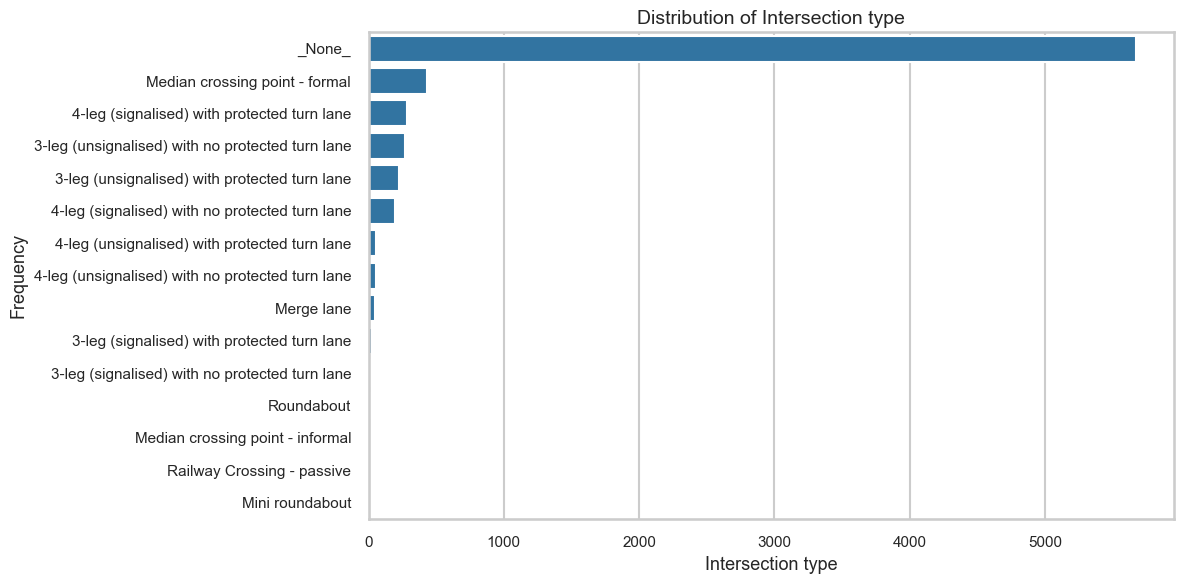

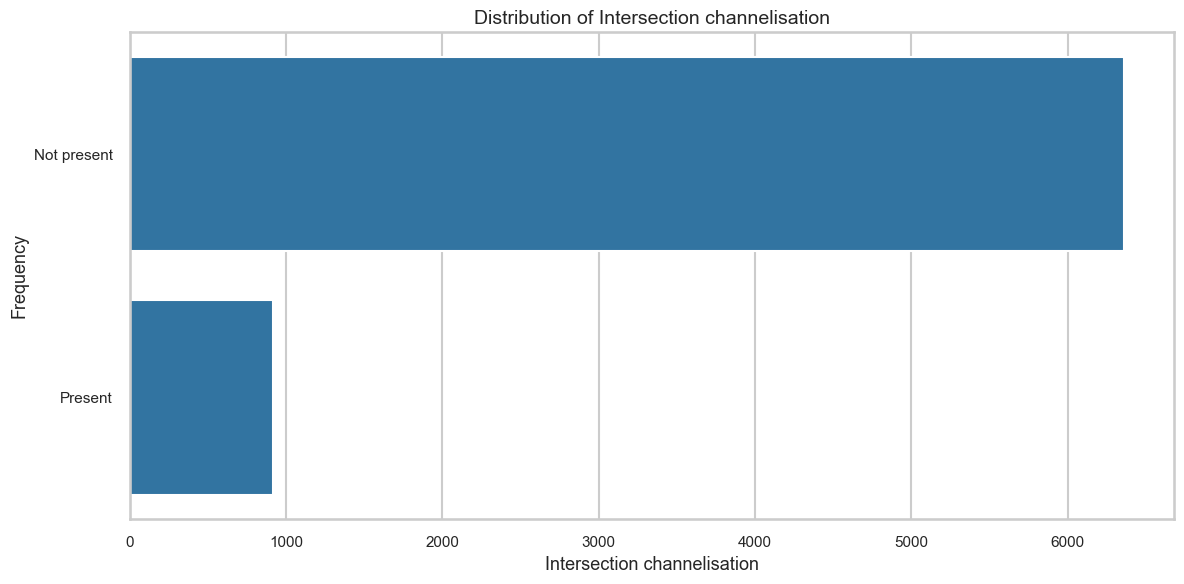

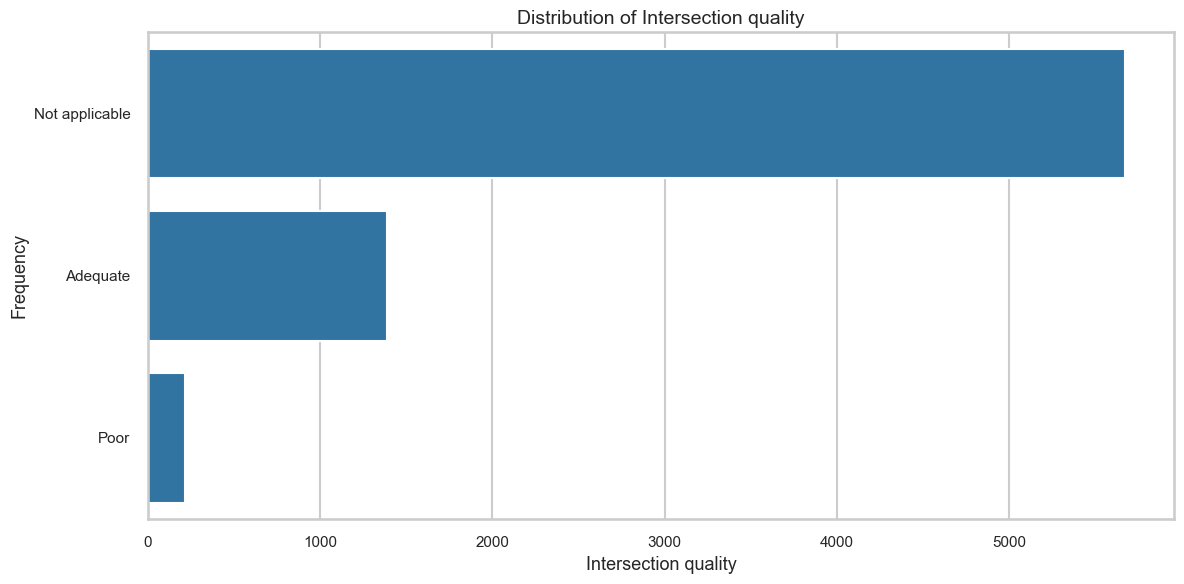

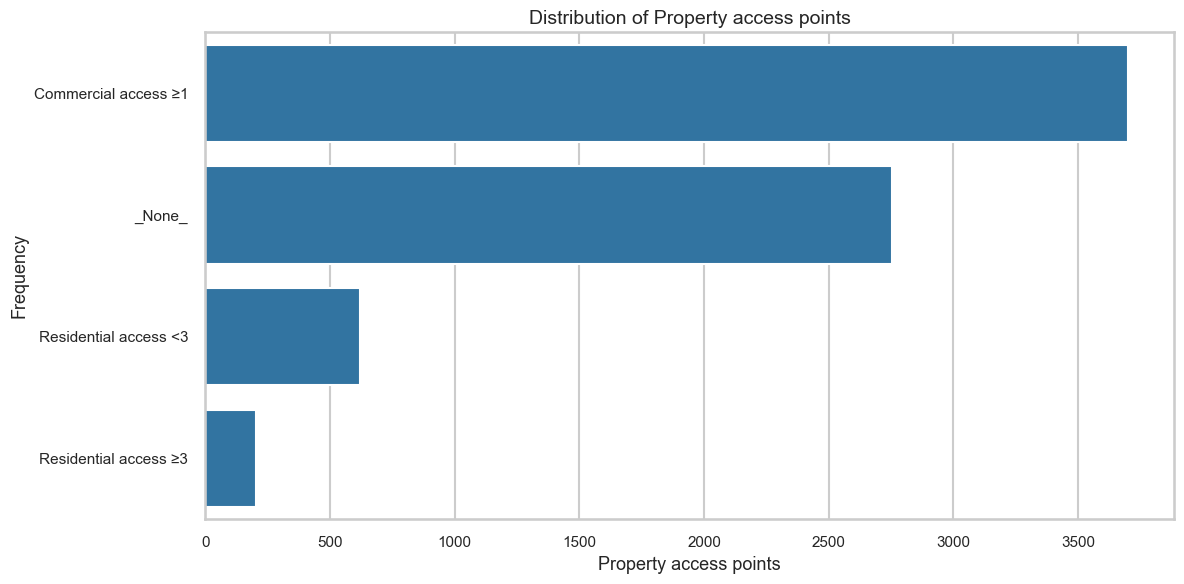

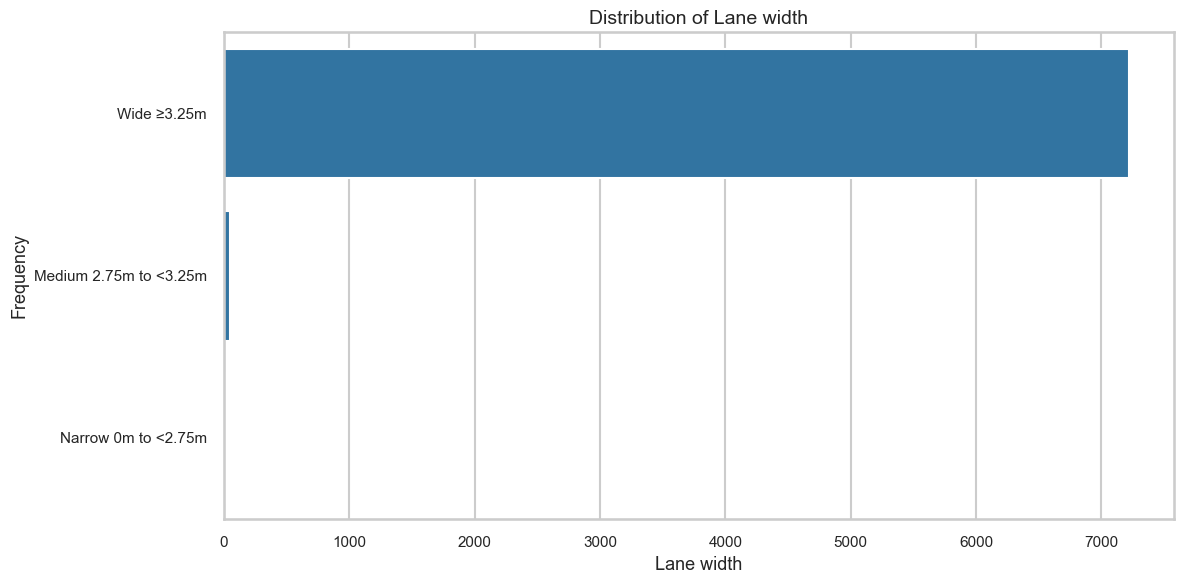

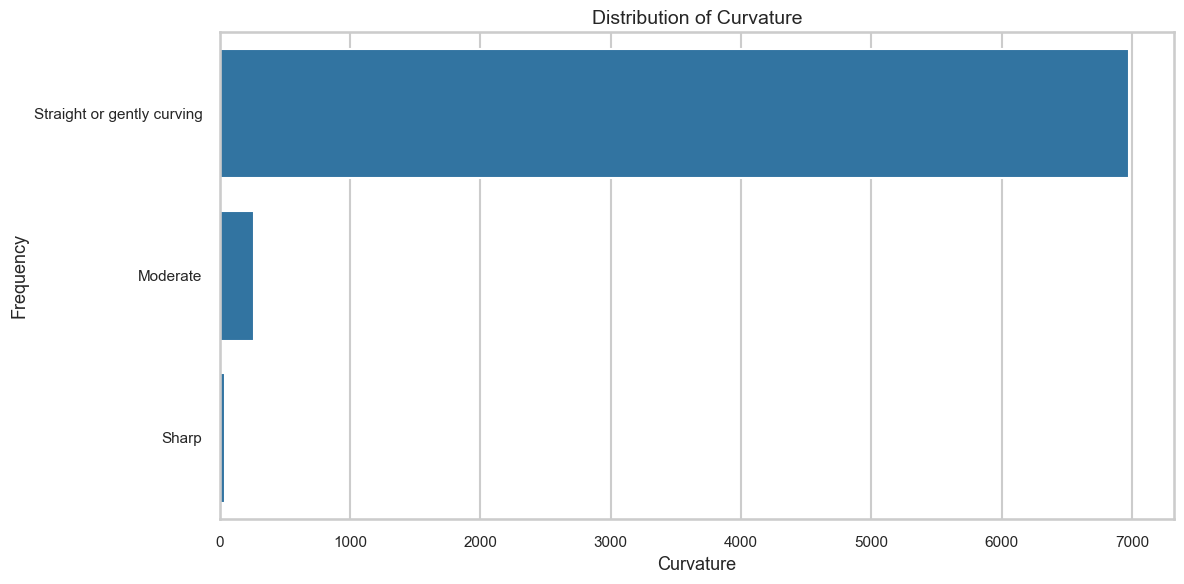

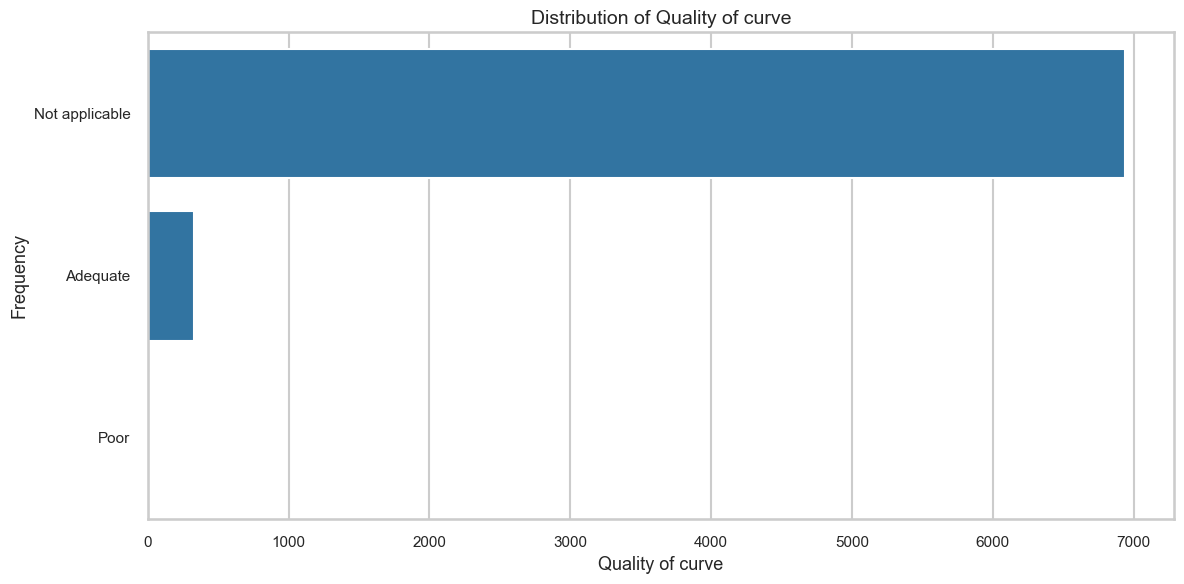

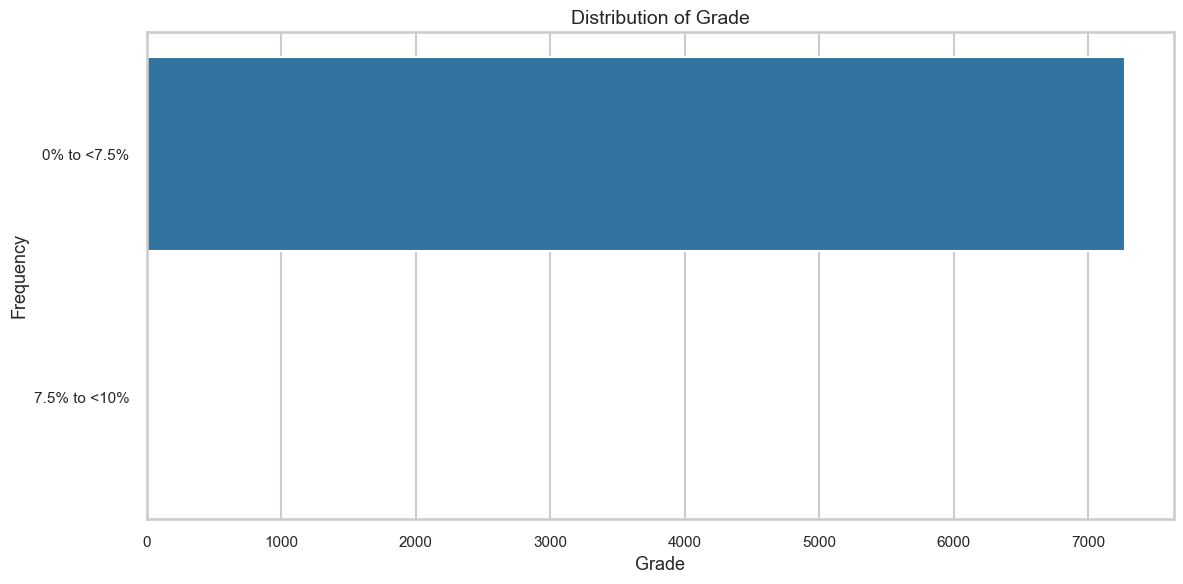

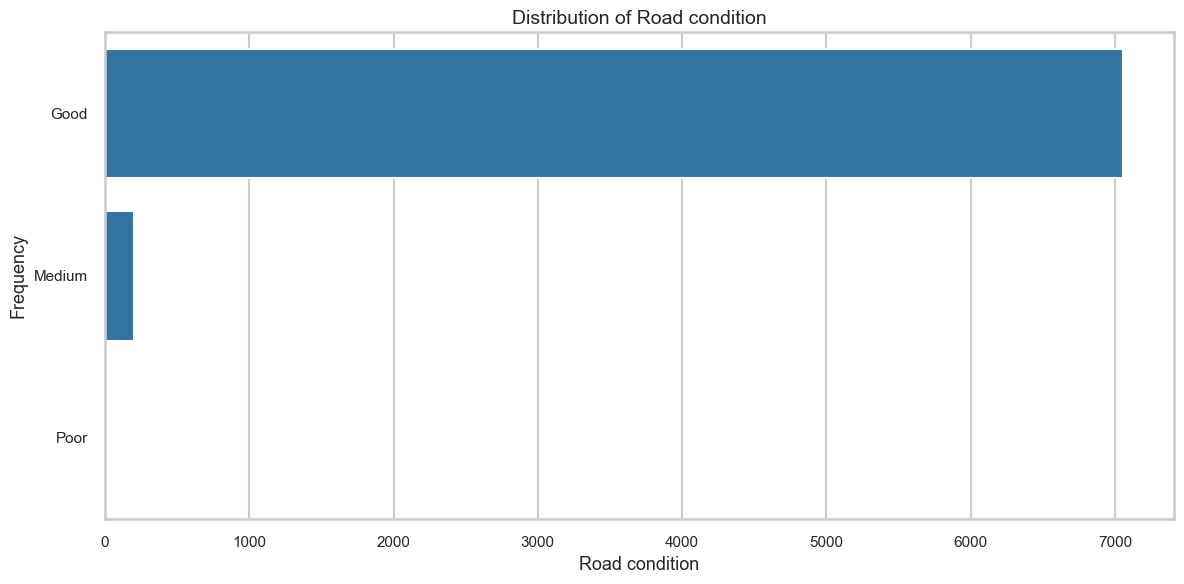

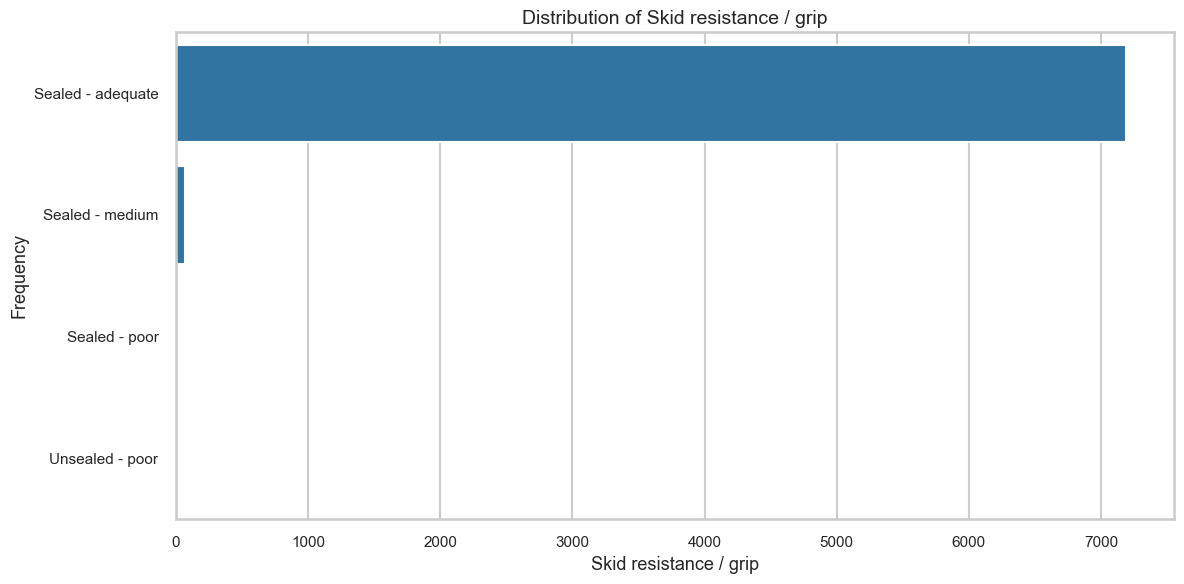

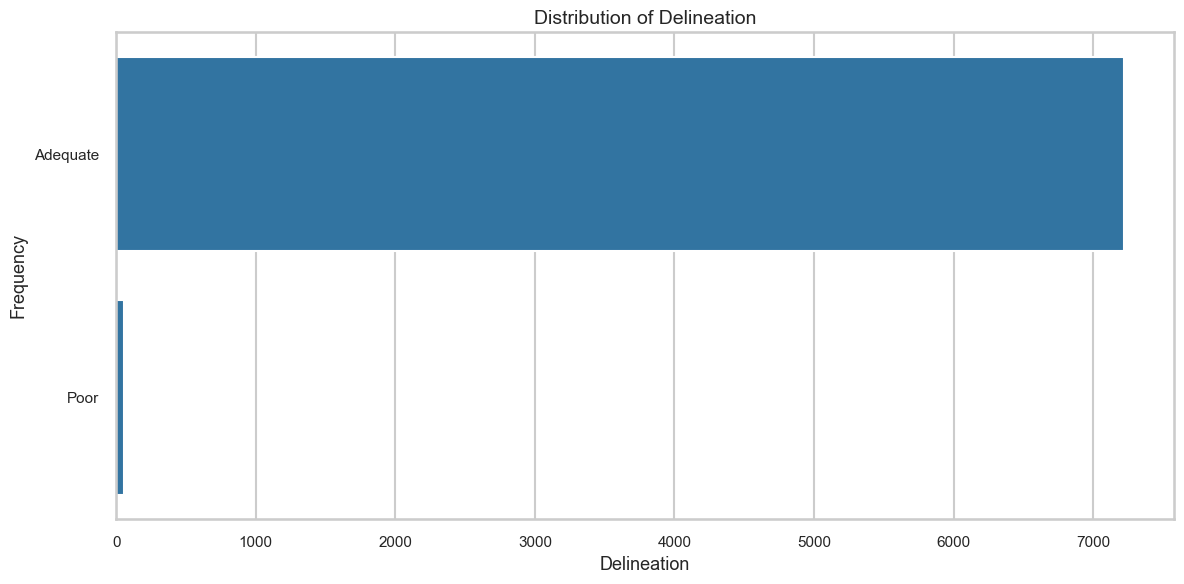

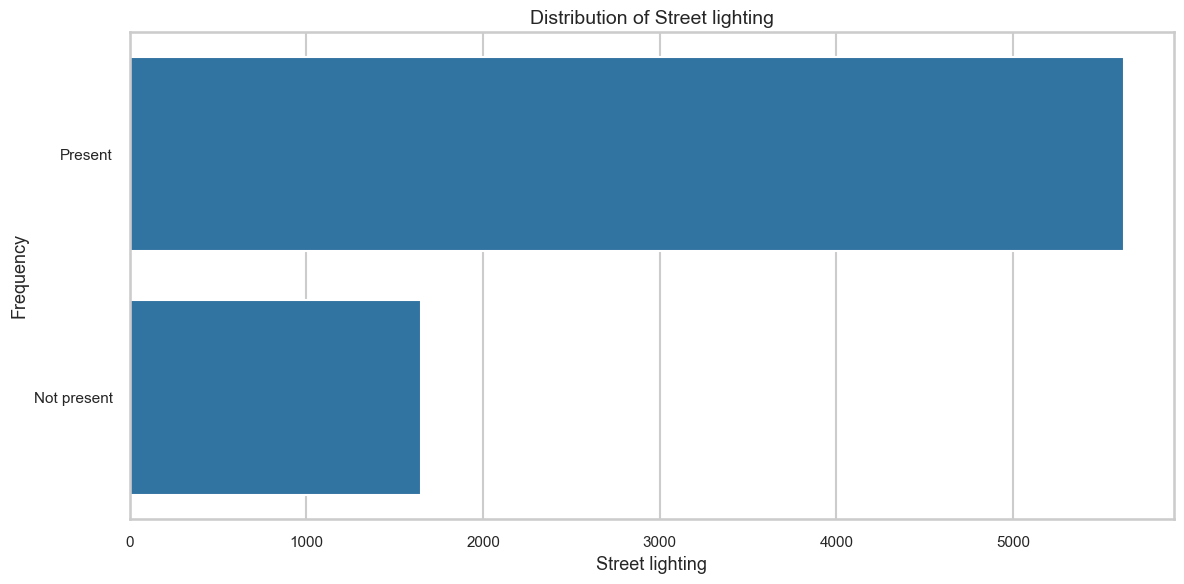

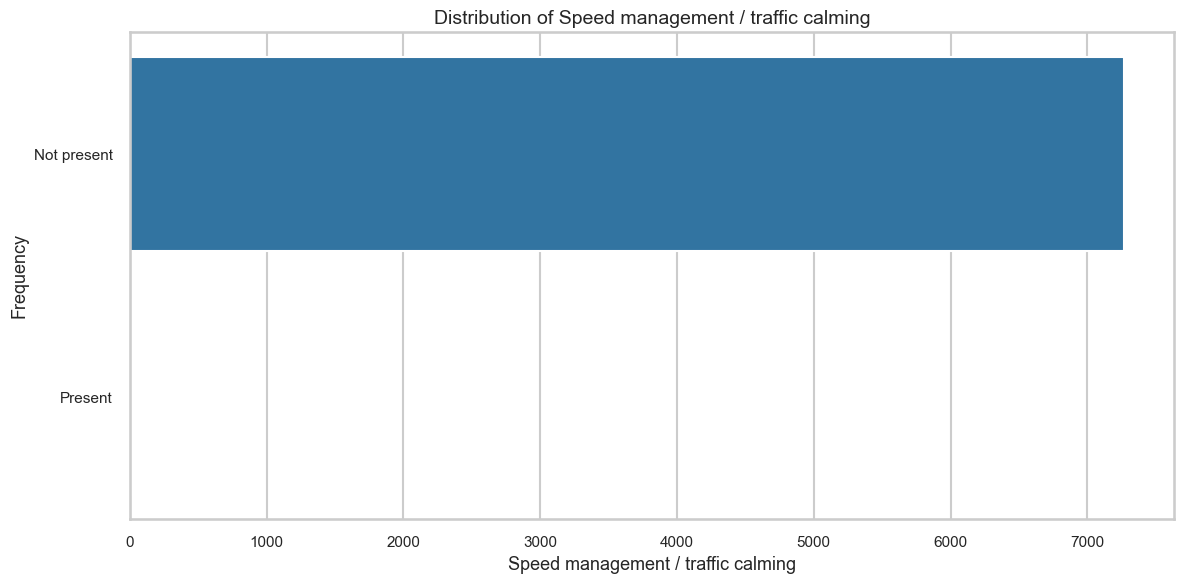

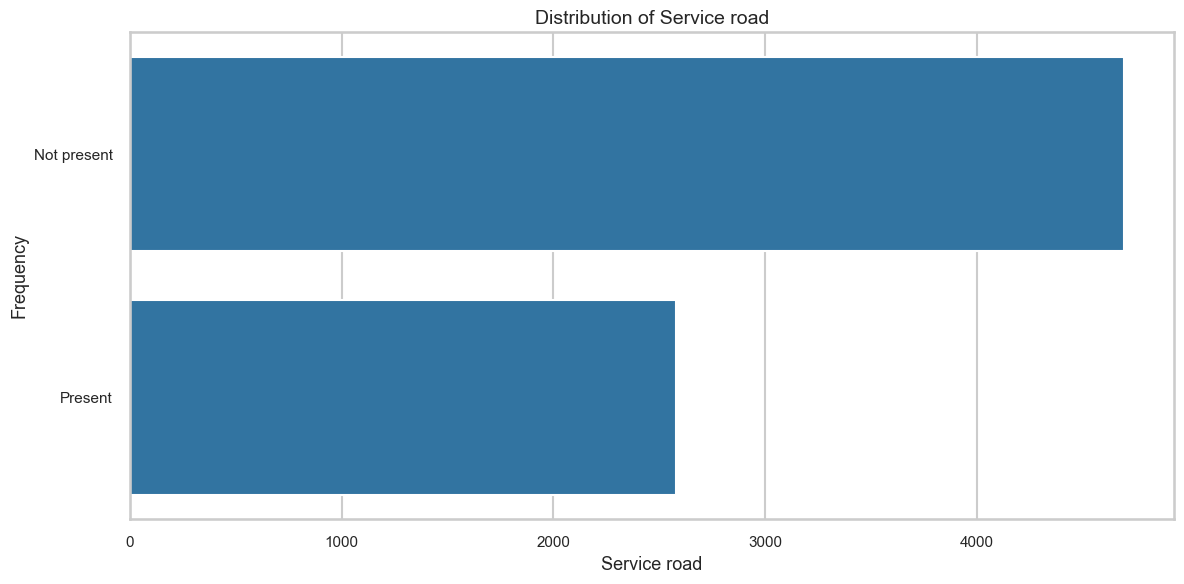

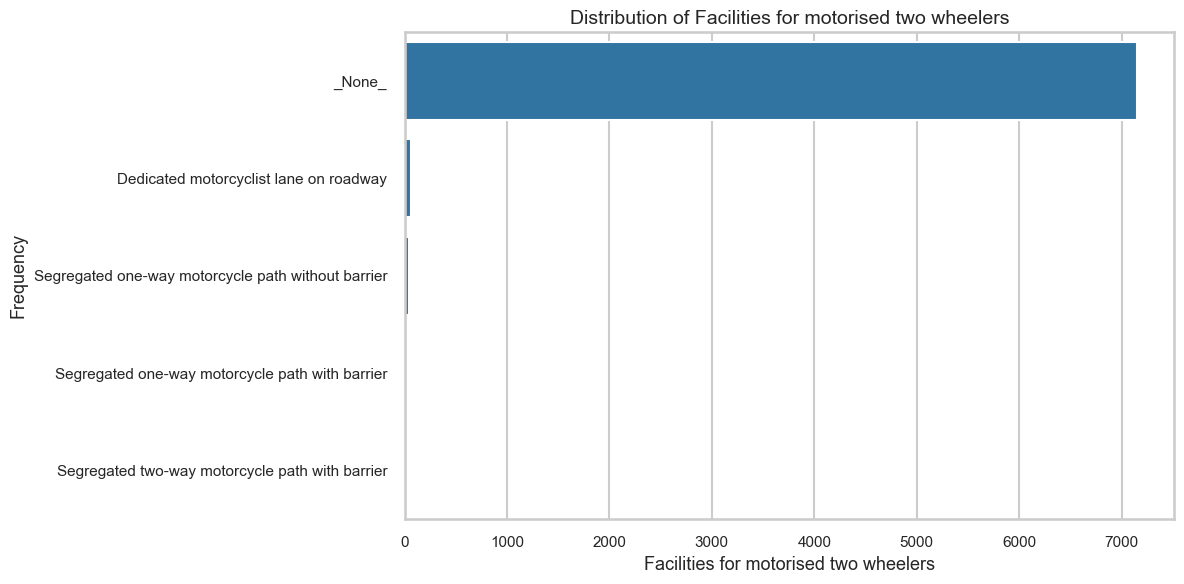

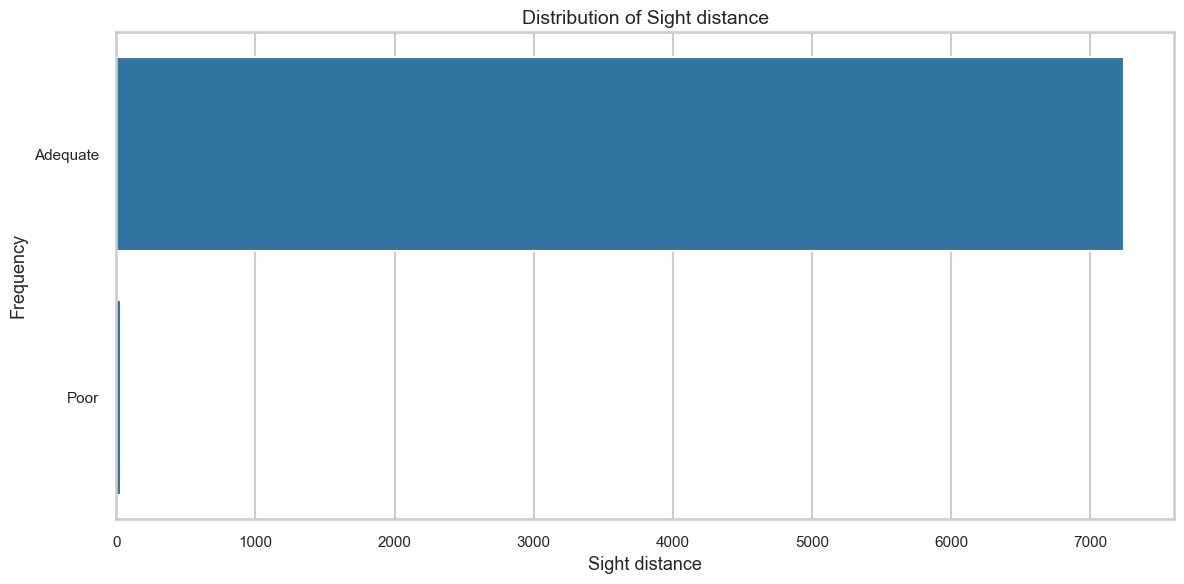

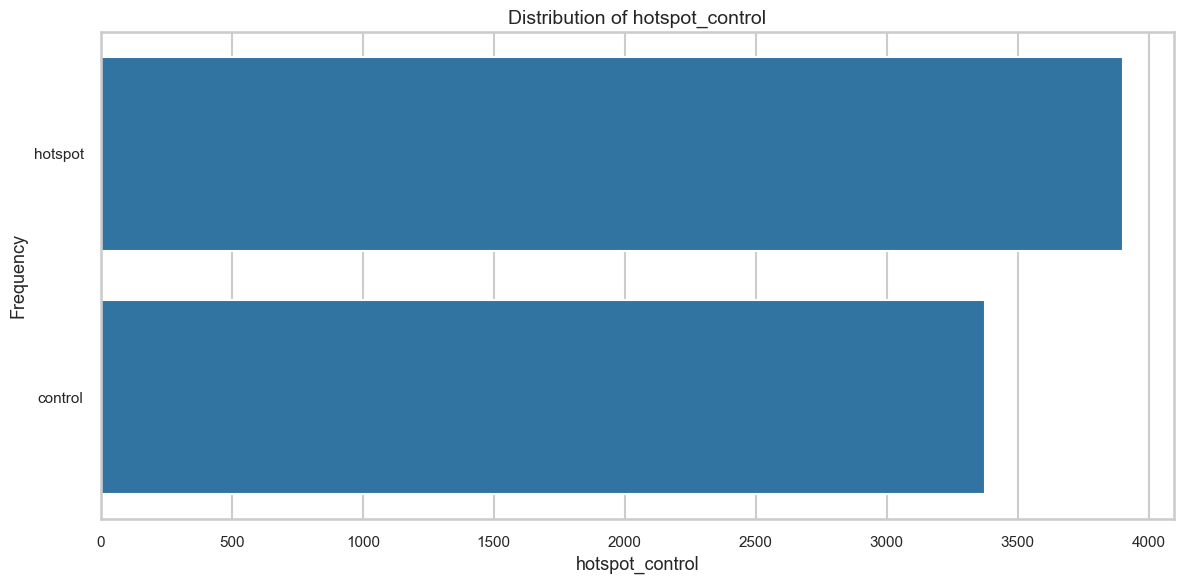

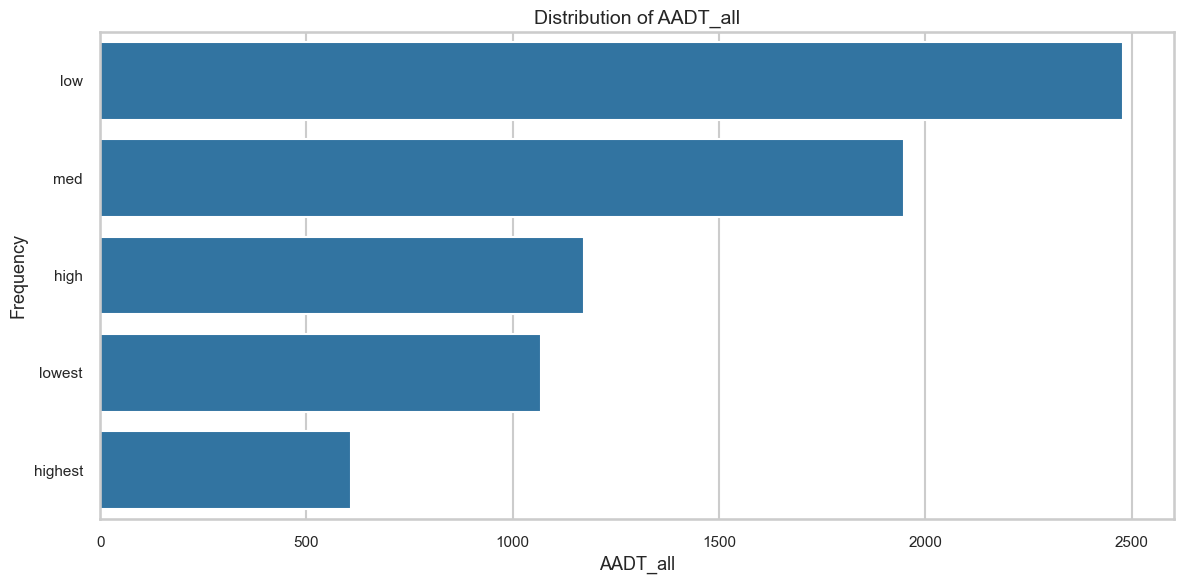

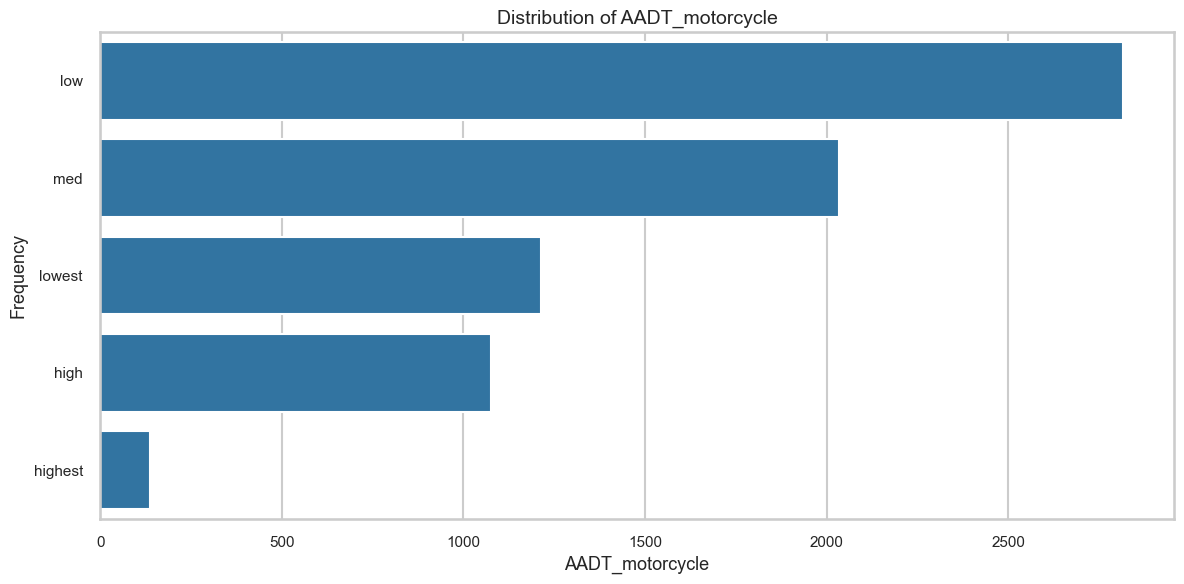

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# increase global font sizes / style
sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1.2)
plt.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 11
})

for col in df.columns:
    if col == "image_id":
        continue

    plt.figure(figsize=(12, 6))
    s = df[col].dropna()
    if pd.api.types.is_numeric_dtype(s):
        sns.histplot(s, bins=40, kde=False)
    else:
        vc = s.value_counts().iloc[:30]  # cap to top categories
        sns.barplot(x=vc.values, y=vc.index)

    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


In [196]:
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import shap

# =========================
# 1. Prepare SHAP arrays and feature names
# =========================

# If not already done:
sv_arr = shap_values.values          # (n_sample, n_features)
feat_names_raw = np.array(feat_names)
feat_names_pretty = np.array(pretty_feat_names)

# mean |SHAP| for ranking
mean_abs = np.mean(np.abs(sv_arr), axis=0)

# choose how many features you want dependence plots for
TOP_K = 6
top_idx = np.argsort(-mean_abs)[:TOP_K]

print("Top features for dependence plots:")
for i, idx in enumerate(top_idx):
    print(f"{i+1}. {feat_names_pretty[idx]} (mean |SHAP| = {mean_abs[idx]:.4f})")

# =========================
# 2. Helper to make safe filenames
# =========================
def safe_filename(name: str) -> str:
    """Turn a feature name into a safe filename."""
    name = re.sub(r"[^A-Za-z0-9]+", "_", name)
    name = re.sub(r"_+", "_", name).strip("_")
    return name[:80]  # truncate just in case

os.makedirs("shap_dependence_plots", exist_ok=True)

# =========================
# 3. Plot dependence for top-K features
# =========================

# global style tweaks
plt.rcParams.update({
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
})

for idx in top_idx:
    fname = feat_names_pretty[idx]
    print(f"Plotting dependence for: {fname}")

    plt.figure(figsize=(4.5, 3.5))

    # NOTE: we pass the raw arrays (not the Explanation object) here
    shap.dependence_plot(
        ind=idx,
        shap_values=sv_arr,
        features=X_sample,
        feature_names=feat_names_pretty,
        show=False,          # we will control show/save via matplotlib
        interaction_index=None,  # no 2nd feature colouring (simpler)
        alpha=0.6
    )

    plt.title(fname)
    plt.tight_layout()

    out_path = os.path.join(
        "shap_dependence_plots",
        f"shap_dependence_{safe_filename(fname)}.png"
    )
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.close()

print("Saved dependence plots in folder: shap_dependence_plots")


Top features for dependence plots:
1. Street lighting: Not present (mean |SHAP| = 0.0407)
2. Property access points: Commercial access ≥1 (mean |SHAP| = 0.0395)
3. AADT: all_lowest (mean |SHAP| = 0.0283)
4. AADT: motorcycle_lowest (mean |SHAP| = 0.0277)
5. AADT: motorcycle_high (mean |SHAP| = 0.0192)
6. Property access points: _None_ (mean |SHAP| = 0.0192)
Plotting dependence for: Street lighting: Not present
Plotting dependence for: Property access points: Commercial access ≥1
Plotting dependence for: AADT: all_lowest
Plotting dependence for: AADT: motorcycle_lowest
Plotting dependence for: AADT: motorcycle_high
Plotting dependence for: Property access points: _None_
Saved dependence plots in folder: shap_dependence_plots


<Figure size 450x350 with 0 Axes>

<Figure size 450x350 with 0 Axes>

<Figure size 450x350 with 0 Axes>

<Figure size 450x350 with 0 Axes>

<Figure size 450x350 with 0 Axes>

<Figure size 450x350 with 0 Axes>

## Attribute-level correlation

In [6]:
import pandas as pd
import numpy as np

# df contains original categorical columns + hotspot_control

binary_attr = pd.DataFrame(index=df.index)

reference_classes = {
    "Differential speed limits": "Not present",
    "Median type": "Centre line",
    "Centreline rumble strips": "Not present",
    "Roadside severity - driver-side distance": "≥10m",
    "Roadside severity - driver-side object": "No object",
    "Roadside severity - passenger-side distance": "≥10m",
    "Roadside severity - passenger-side object": "No object",
    "Shoulder rumble strips": "Not present",
    "Intersection type": "_None_",
    "Intersection channelisation": "Not present",
    "Intersection quality": "Adequate",
    "Property access points": "_None_",
    "Lane width": "Wide ≥3.25m",
    "Curvature": "Straight or gently curving",
    "Quality of curve": "Adequate",
    "Grade": "0% to <7.5%",
    "Road condition": "Good",
    "Skid resistance / grip": "Sealed - adequate",
    "Delineation": "Adequate",
    "Street lighting": "Not present",
    "Speed management / traffic calming": "Not present",
    "Service road": "Not present",
    "Facilities for motorised two wheelers": "_None_",
    "Sight distance": "Adequate",
    "AADT_all": "lowest",
    "AADT_motorcycle": "lowest",
}

for col, ref in reference_classes.items():
    binary_attr[col] = (df[col] != ref).astype(int)

# Optional: add exposure
binary_attr["AADT_all"] = df["AADT_all"].map({
    "lowest": 1, "low": 2, "medium": 3, "high": 4, "highest": 5
})
binary_attr["AADT_motorcycle"] = df["AADT_motorcycle"].map({
    "lowest": 1, "low": 2, "medium": 3, "high": 4, "highest": 5
})


In [7]:
corr = binary_attr.corr(method="spearman")  # Spearman is safer for ordinal / binary

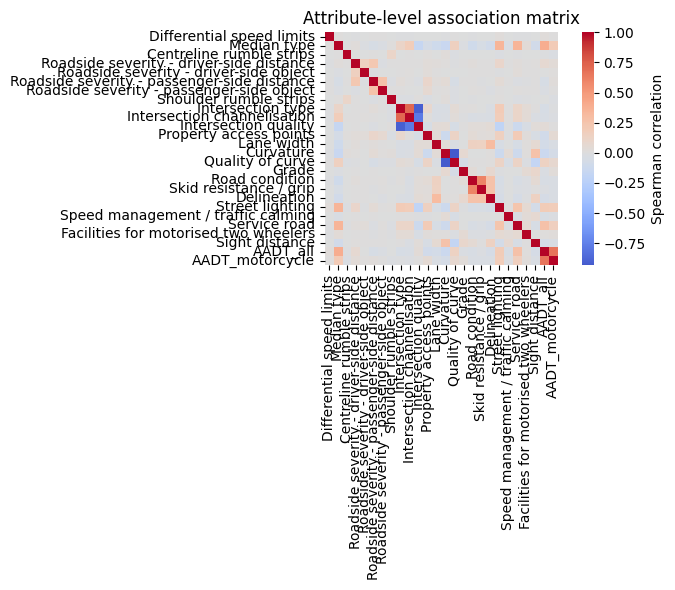

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(
    corr,
    cmap="coolwarm",
    center=0,
    square=True,
    cbar_kws={"label": "Spearman correlation"}
)
plt.title("Attribute-level association matrix")
plt.tight_layout()
plt.show()


In [17]:
categorical_features = X_train.select_dtypes(include=["object", "category", "bool"]).columns


In [18]:
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    table = pd.crosstab(x, y)
    chi2 = chi2_contingency(table)[0]
    n = table.sum().sum()
    r, k = table.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

cramers = {}
for col in categorical_features:
    cramers[col] = cramers_v(df[col], df["hotspot_control"])

cramers_df = (
    pd.DataFrame.from_dict(cramers, orient="index", columns=["Cramers_V"])
    .sort_values("Cramers_V", ascending=False)
)

cramers_df.head(10)


,Cramers_V
Street lighting,0.200052
Intersection type,0.168462
Property access points,0.166830
Median type,0.147893
Intersection quality,0.147216
Intersection channelisation,0.133657
AADT_motorcycle,0.127107
Roadside severity - driver-side object,0.108390
Roadside severity - passenger-side object,0.093007
Service road,0.092948


In [19]:
print(cramers_df)

                                             Cramers_V
Street lighting                               0.200052
Intersection type                             0.168462
Property access points                        0.166830
Median type                                   0.147893
Intersection quality                          0.147216
Intersection channelisation                   0.133657
AADT_motorcycle                               0.127107
Roadside severity - driver-side object        0.108390
Roadside severity - passenger-side object     0.093007
Service road                                  0.092948
AADT_all                                      0.080951
Curvature                                     0.063918
Quality of curve                              0.063694
Facilities for motorised two wheelers         0.051903
Roadside severity - driver-side distance      0.039307
Roadside severity - passenger-side distance   0.035973
Skid resistance / grip                        0.029552
Delineatio

## Logistic regression

In [11]:
y = df["hotspot_control"]          # hotspot / control as strings
X = df.drop(columns=["hotspot_control", "image_id"])


In [12]:
print(df['hotspot_control'].value_counts())

hotspot_control
hotspot    3902
control    3374
Name: count, dtype: int64


In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [14]:
y = (df["hotspot_control"] == "hotspot").astype(int)
X = df.drop(columns=["hotspot_control", "image_id"])


In [15]:
df['AADT_all'].unique()

array(['med', 'low', 'lowest', 'high', 'highest'], dtype=object)

In [20]:
# how many classes in all attributes
df.nunique()

# summary of categorical features not image_id
df[categorical_features].describe()

# sum all unique values in categorical features
df[categorical_features].nunique().sum()

121

In [21]:
category_orders = {
    "Differential speed limits": ["Not present", "Present"],
    "Median type": ['Centre line','Safety barrier - concrete', 
       'Physical median width 1 to <5m',
       'Physical median width 5 to <10m',
       'Physical median width 10 to <20m',
       'Physical median width 0 to <1m', 'Central hatching >1m',
       'Safety barrier - metal', 'Physical median width ≥20m',
       'Wide centre line 0.3m to 1m', 'One way',
       'Continuous central turning lane', 'Flexible posts'],
    "Centreline rumble strips": ["Not present", "Present"],
    "Roadside severity - driver-side distance": ["≥10m", "5 to <10m", "1 to <5m", "0 to <1m"],
    "Roadside severity - driver-side object": ['No object','Safety barrier - concrete', 'Rigid sign, post or pole ≥10cm',
       'Tree ≥10cm', 'Low rigid object ≥20cm high', 'Downwards slope',
       'Rigid structure or building', 'Safety barrier - metal',
       'Upwards slope - roll over', 'Upwards slope - no roll over',
       'Deep drainage ditch', 'Semi-rigid structure or building',
        'Aggressive vertical face',
       'Unprotected safety barrier end'],
    "Roadside severity - passenger-side distance": ["≥10m", "5 to <10m", "1 to <5m", "0 to <1m"],
    "Roadside severity - passenger-side object": ['No object','Safety barrier - concrete', 'Rigid sign, post or pole ≥10cm',
       'Tree ≥10cm', 'Low rigid object ≥20cm high', 'Downwards slope',
       'Rigid structure or building', 'Safety barrier - metal',
       'Upwards slope - roll over', 'Upwards slope - no roll over',
       'Deep drainage ditch', 'Semi-rigid structure or building',
        'Aggressive vertical face',
       'Unprotected safety barrier end'],
    "Shoulder rumble strips": ["Not present", "Present"],
    "Intersection type": ['_None_', '3-leg (unsignalised) with no protected turn lane',
       '4-leg (signalised) with protected turn lane',
       'Median crossing point - formal',
       '4-leg (signalised) with no protected turn lane',
       '3-leg (signalised) with protected turn lane',
       '3-leg (unsignalised) with protected turn lane', 'Merge lane',
       '4-leg (unsignalised) with no protected turn lane',
       '3-leg (signalised) with no protected turn lane',
       '4-leg (unsignalised) with protected turn lane', 'Roundabout',
       'Median crossing point - informal', 'Railway Crossing - passive',
       'Mini roundabout'],
    "Intersection channelisation": ["Not present", "Present"],
    "Intersection quality": ["Adequate", "Poor", "Not applicable"],
    "Property access points": ['_None_','Residential access <3', 'Commercial access ≥1', 
       'Residential access ≥3'],
    "Lane width": ['Wide ≥3.25m', 'Medium 2.75m to <3.25m', 'Narrow 0m to <2.75m'],
    "Curvature": ["Straight or gently curving", "Moderate", "Sharp"],
    "Quality of curve": ["Adequate", "Poor", "Not applicable"],
    "Grade": ['0% to <7.5%', '7.5% to <10%'],
    "Road condition": ["Good", "Medium", "Poor"],
    "Skid resistance / grip": ['Sealed - adequate', 'Sealed - medium', 'Sealed - poor',
       'Unsealed - poor'],
    "Delineation": ["Adequate", "Poor"],
    "Street lighting": ["Not present", "Present"],
    "Speed management / traffic calming": ["Not present", "Present"],
    "Service road": ["Not present", "Present"],
    "Facilities for motorised two wheelers": ['_None_', 'Dedicated motorcyclist lane on roadway',
       'Segregated one-way motorcycle path without barrier',
       'Segregated one-way motorcycle path with barrier',
       'Segregated two-way motorcycle path with barrier'],
    "Sight distance": ["Adequate", "Poor"],
    "AADT_all": ['lowest','med', 'low',  'high', 'highest'],
    "AADT_motorcycle": ['lowest','med', 'low',  'high', 'highest'],
}

categories = [
    category_orders.get(col, "auto")
    for col in categorical_features
]



In [22]:
drop_dict = {}

for col, ref in reference_classes.items():
    if col in categorical_features:
        drop_dict[col] = ref

In [ ]:
# categorical_transformer = OneHotEncoder(
#     handle_unknown="ignore",
#     drop=drop_dict
# )


In [23]:
categories

[['Not present', 'Present'],
 ['Centre line',
  'Safety barrier - concrete',
  'Physical median width 1 to <5m',
  'Physical median width 5 to <10m',
  'Physical median width 10 to <20m',
  'Physical median width 0 to <1m',
  'Central hatching >1m',
  'Safety barrier - metal',
  'Physical median width ≥20m',
  'Wide centre line 0.3m to 1m',
  'One way',
  'Continuous central turning lane',
  'Flexible posts'],
 ['Not present', 'Present'],
 ['≥10m', '5 to <10m', '1 to <5m', '0 to <1m'],
 ['No object',
  'Safety barrier - concrete',
  'Rigid sign, post or pole ≥10cm',
  'Tree ≥10cm',
  'Low rigid object ≥20cm high',
  'Downwards slope',
  'Rigid structure or building',
  'Safety barrier - metal',
  'Upwards slope - roll over',
  'Upwards slope - no roll over',
  'Deep drainage ditch',
  'Semi-rigid structure or building',
  'Aggressive vertical face',
  'Unprotected safety barrier end'],
 ['≥10m', '5 to <10m', '1 to <5m', '0 to <1m'],
 ['No object',
  'Safety barrier - concrete',
  'Rigi

In [38]:
# -------------------------
# 2. Train/test split
# -------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -------------------------
# 3. Detect numeric / categorical
# -------------------------
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category", "bool"]).columns

print("Numeric features:", list(numeric_features))
print("Categorical features:", list(categorical_features))

numeric_transformer = StandardScaler()
# categorical_transformer = OneHotEncoder(handle_unknown="ignore",drop="first")
# categorical_transformer = OneHotEncoder(
#     handle_unknown="ignore",
#     drop=drop_dict
# )

categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    categories=categories,
    drop="first"
)


preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# -------------------------
# 4. Build + fit pipeline
# -------------------------
clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            max_iter=1000,
            solver="liblinear",
            class_weight="balanced"
        )),
    ]
)

clf.fit(X_train, y_train)

# -------------------------
# 5. Evaluate
# -------------------------
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Numeric features: []
Categorical features: ['Differential speed limits', 'Median type', 'Centreline rumble strips', 'Roadside severity - driver-side distance', 'Roadside severity - driver-side object', 'Roadside severity - passenger-side distance', 'Roadside severity - passenger-side object', 'Shoulder rumble strips', 'Intersection type', 'Intersection channelisation', 'Intersection quality', 'Property access points', 'Lane width', 'Curvature', 'Quality of curve', 'Grade', 'Road condition', 'Skid resistance / grip', 'Delineation', 'Street lighting', 'Speed management / traffic calming', 'Service road', 'Facilities for motorised two wheelers', 'Sight distance', 'AADT_all', 'AADT_motorcycle']
Accuracy: 0.6346153846153846
ROC-AUC: 0.6844378052828758

Confusion matrix:
 [[408 267]
 [265 516]]

Classification report:
               precision    recall  f1-score   support

           0       0.61      0.60      0.61       675
           1       0.66      0.66      0.66       781

    accurac

In [37]:
feature_names = clf.named_steps["preprocess"].get_feature_names_out()
print(feature_names)


['cat__Differential speed limits_Present'
 'cat__Median type_Safety barrier - concrete'
 'cat__Median type_Physical median width 1 to <5m'
 'cat__Median type_Physical median width 5 to <10m'
 'cat__Median type_Physical median width 10 to <20m'
 'cat__Median type_Physical median width 0 to <1m'
 'cat__Median type_Central hatching >1m'
 'cat__Median type_Safety barrier - metal'
 'cat__Median type_Physical median width ≥20m'
 'cat__Median type_Wide centre line 0.3m to 1m' 'cat__Median type_One way'
 'cat__Median type_Continuous central turning lane'
 'cat__Median type_Flexible posts' 'cat__Centreline rumble strips_Present'
 'cat__Roadside severity - driver-side distance_5 to <10m'
 'cat__Roadside severity - driver-side distance_1 to <5m'
 'cat__Roadside severity - driver-side distance_0 to <1m'
 'cat__Roadside severity - driver-side object_Safety barrier - concrete'
 'cat__Roadside severity - driver-side object_Rigid sign, post or pole ≥10cm'
 'cat__Roadside severity - driver-side object_

In [39]:
# -------------------------
# 6. Coefficients & odds ratios
# -------------------------
preprocess = clf.named_steps["preprocess"]
model = clf.named_steps["model"]

feature_names = preprocess.get_feature_names_out()
coefs = model.coef_.ravel()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
})

coef_df["odds_ratio"] = np.exp(coef_df["coef"])
coef_df = coef_df.sort_values("coef", ascending=False)

# # Inspect AADT_motorcycle-related features
# coef_df[coef_df["feature"].str.contains("AADT_motorcycle")]


In [40]:
import pandas as pd

pd.set_option('display.max_colwidth', None)

print(coef_df.sort_values("coef", ascending=False).head(20))


                                                                                          feature  \
73                                                                        cat__Grade_7.5% to <10%   
94                                                                      cat__AADT_motorcycle_high   
71                                                                     cat__Quality of curve_Poor   
77                                                      cat__Skid resistance / grip_Sealed - poor   
81                                                cat__Speed management / traffic calming_Present   
80                                                                   cat__Street lighting_Present   
84  cat__Facilities for motorised two wheelers_Segregated one-way motorcycle path without barrier   
93                                                                       cat__AADT_motorcycle_low   
33                       cat__Roadside severity - passenger-side object_Safety barrier - co

In [41]:
coef_df

,feature,coef,odds_ratio
73,cat__Grade_7.5% to <10%,1.221532,3.392382
94,cat__AADT_motorcycle_high,0.850052,2.339768
71,cat__Quality of curve_Poor,0.833474,2.301300
77,cat__Skid resistance / grip_Sealed - poor,0.759645,2.137517
81,cat__Speed management / traffic calming_Present,0.691583,1.996875
...,...,...,...
86,cat__Facilities for motorised two wheelers_Segregated two-way motorcycle path with barrier,-0.483294,0.616749
88,cat__AADT_all_med,-0.488824,0.613347
11,cat__Median type_Continuous central turning lane,-0.530115,0.588537
58,cat__Intersection type_Median crossing point - informal,-0.711340,0.490986


In [54]:
import numpy as np
import pandas as pd
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import roc_auc_score, average_precision_score

preprocess = clf.named_steps["preprocess"]

# Transform
X_train_dm = preprocess.transform(X_train)
X_test_dm  = preprocess.transform(X_test)

X_train_dm = X_train_dm.toarray() if hasattr(X_train_dm, "toarray") else np.asarray(X_train_dm)
X_test_dm  = X_test_dm.toarray() if hasattr(X_test_dm, "toarray") else np.asarray(X_test_dm)

y_train01 = pd.Series(y_train).astype(int)
y_test01  = pd.Series(y_test).astype(int)

w_train = compute_sample_weight(class_weight="balanced", y=y_train01)

xgb = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss"
)

xgb.fit(X_train_dm, y_train01, sample_weight=w_train)

proba = xgb.predict_proba(X_test_dm)[:, 1]
print("XGB ROC-AUC:", roc_auc_score(y_test01, proba))
print("XGB PR-AUC:", average_precision_score(y_test01, proba))


XGB ROC-AUC: 0.6888556930810451
XGB PR-AUC: 0.7095545395027536


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 500/500 [00:30<00:00, 16.27it/s]


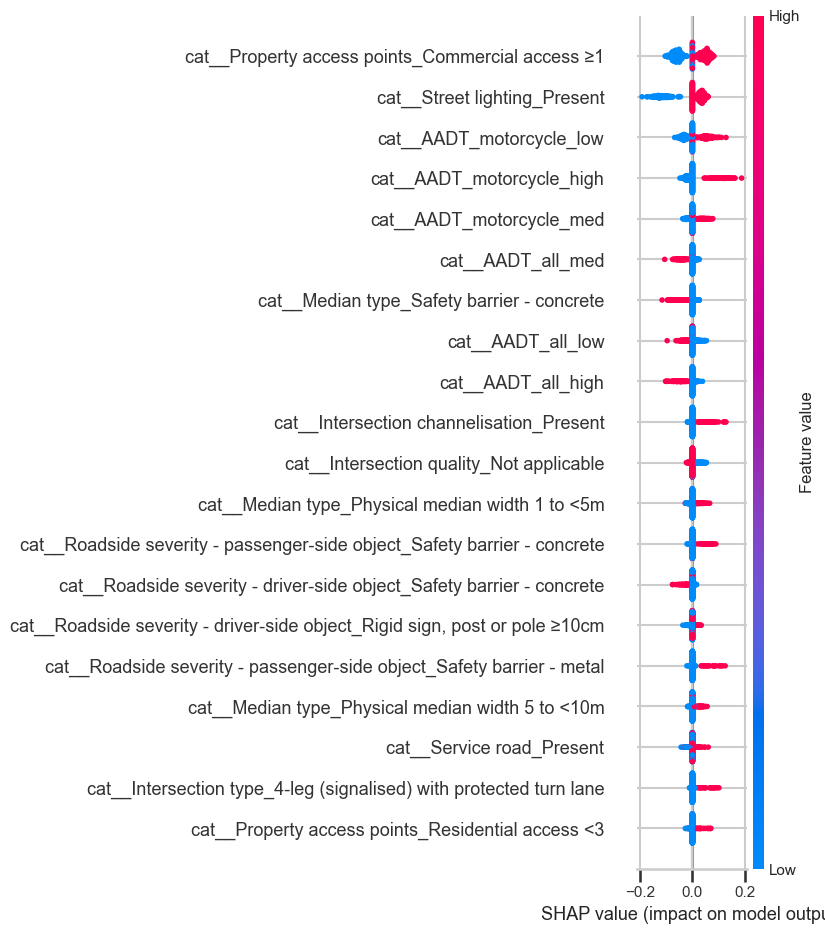

TypeError: The shap_values argument must be an Explanation object, Cohorts object, or dictionary of Explanation objects!

In [ ]:
import shap

f = lambda X: xgb.predict_proba(X)[:, 1]

# Background set (small subset)
bg = X_train_dm[np.random.choice(X_train_dm.shape[0], size=min(200, X_train_dm.shape[0]), replace=False)]

explainer = shap.KernelExplainer(f, bg)   # model-agnostic
shap_values = explainer.shap_values(X_test_dm[:500], nsamples=200)  # sample for speed

shap.summary_plot(shap_values, X_test_dm[:500], feature_names=feature_names, max_display=20)


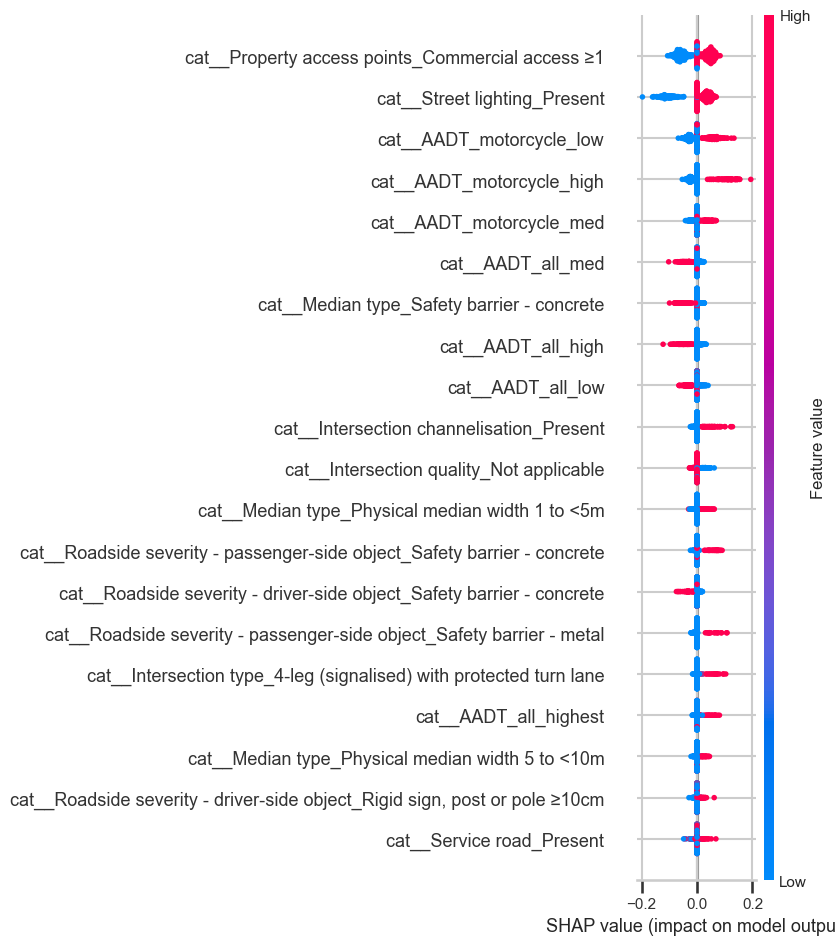

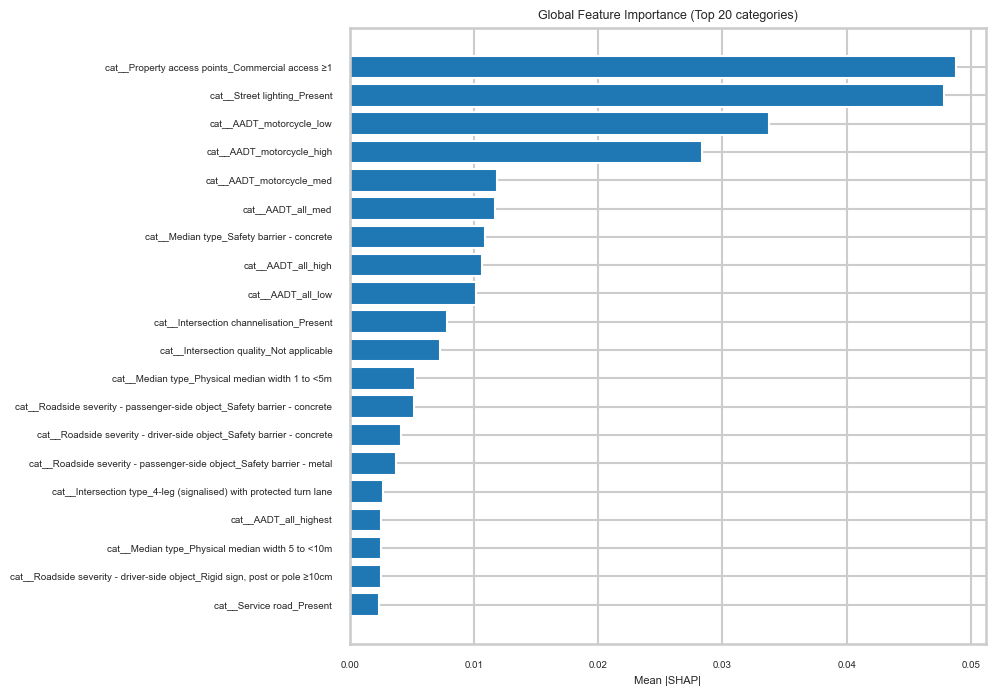

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

# your existing objects:
# - shap_values from KernelExplainer
# - X_test_dm_subset = X_test_dm[:500]
# - feature_names

X_test_dm_subset = X_test_dm[:500]

# KernelExplainer sometimes returns list (for multi-class); for binary it can be:
# - array shape (n_samples, n_features)
# - list with one array
if isinstance(shap_values, list):
    shap_arr = shap_values[0]
else:
    shap_arr = shap_values

# 1) Beeswarm (points) - you already have, but keep for completeness
shap.summary_plot(shap_arr, X_test_dm_subset, feature_names=feature_names, max_display=20)

# 2) Global importance bar plot (mean absolute SHAP)
mean_abs_shap = np.abs(shap_arr).mean(axis=0)

imp = (
    pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs_shap})
      .sort_values("mean_abs_shap", ascending=False)
      .head(20)
      .sort_values("mean_abs_shap", ascending=True)  # for nicer horizontal order
)

plt.figure(figsize=(8, 7))
plt.barh(imp["feature"], imp["mean_abs_shap"])
plt.xlabel("Mean |SHAP|")
plt.title("Global Feature Importance (Top 20 categories)")
plt.tight_layout()
plt.show()


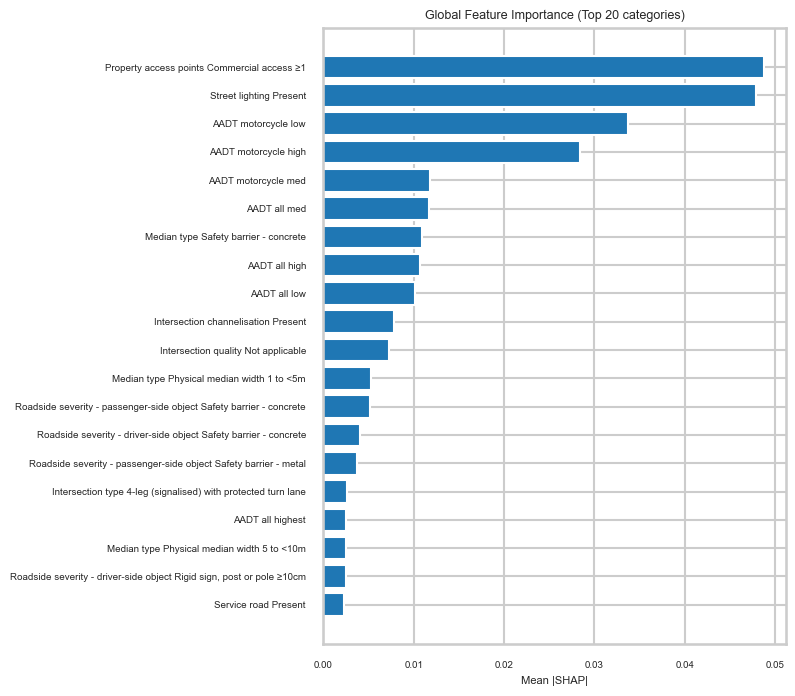

In [77]:
def clean_name(s: str) -> str:
    s = s.replace("cat__", "").replace("num__", "")
    s = s.replace("_", " ")
    return s

imp2 = imp.copy()
imp2["feature"] = imp2["feature"].apply(clean_name)

plt.figure(figsize=(8, 7))
plt.barh(imp2["feature"], imp2["mean_abs_shap"])
plt.xlabel("Mean |SHAP|")
plt.title("Global Feature Importance (Top 20 categories)")
plt.tight_layout()
plt.show()


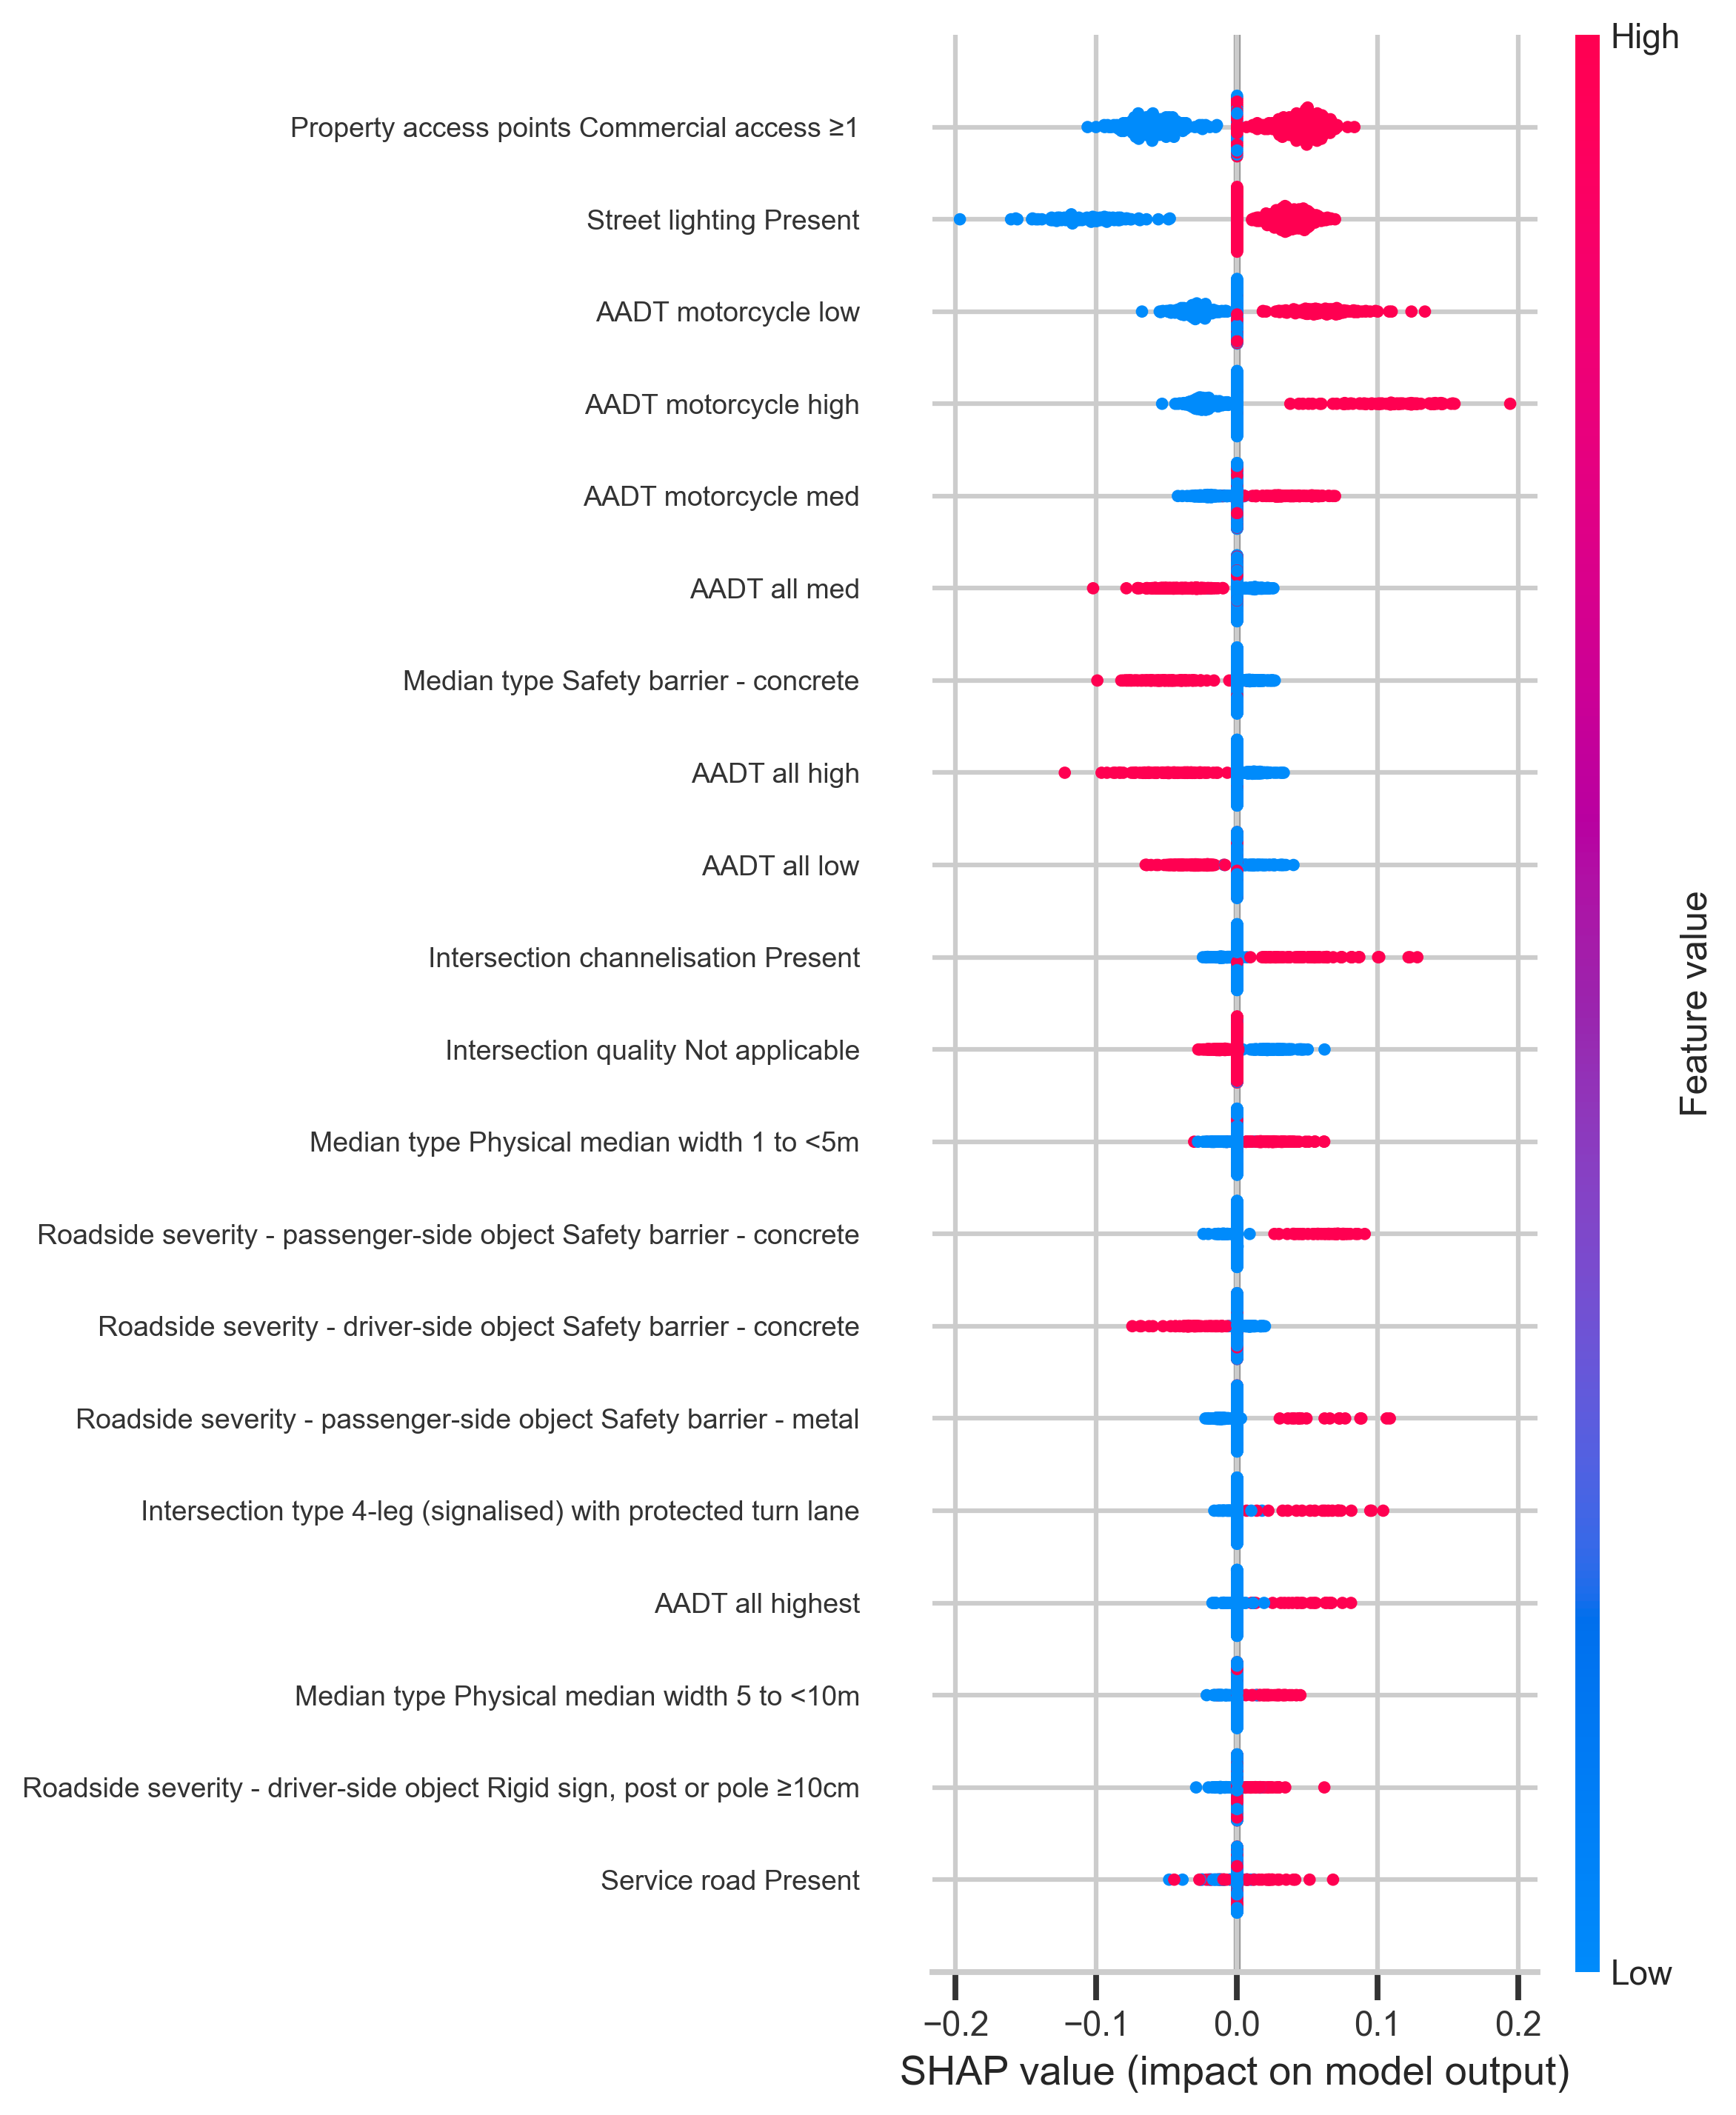

In [90]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import shap

# Smaller global font
mpl.rcParams.update({
    "font.size": 6,
})

# --- clean function ---
def clean_name(s: str) -> str:
    s = s.replace("cat__", "").replace("num__", "")
    s = s.replace("_", " ")
    return s

clean_feature_names = [clean_name(f) for f in feature_names]

if isinstance(shap_values, list):
    shap_arr = shap_values[0]
else:
    shap_arr = shap_values

# Larger width, moderate height
plt.figure(figsize=(14, 10), dpi=300)

shap.summary_plot(
    shap_arr,
    X_test_dm_subset,
    feature_names=clean_feature_names,
    max_display=20,
    # dot_size=12,        # 👈 makes dots bigger (default ~8)
    show=False
)

# Make y-axis labels smaller specifically
plt.yticks(fontsize=9)

plt.tight_layout()
plt.show()


# Robustness check code (exclude AADT variables)

In [68]:
# --- Robustness: exclude exposure variables (AADT_all, AADT_motorcycle) ---
EXCLUDE_COLS = ["AADT_all", "AADT_motorcycle"]

X_noexp = X.drop(columns=[c for c in EXCLUDE_COLS if c in X.columns]).copy()

X_train_noexp, X_test_noexp, y_train_noexp, y_test_noexp = train_test_split(
    X_noexp, y, test_size=0.2, random_state=42, stratify=y)

In [69]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.utils.class_weight import compute_sample_weight
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, average_precision_score
import numpy as np
import pandas as pd

# Detect numeric/categorical again (because we removed columns)
numeric_features_noexp = X_train_noexp.select_dtypes(include=["int64", "float64"]).columns
categorical_features_noexp = X_train_noexp.select_dtypes(include=["object", "category", "bool"]).columns

# Rebuild categories list for the reduced categorical set
categories_noexp = [category_orders.get(col, "auto") for col in categorical_features_noexp]

numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(
    handle_unknown="ignore",
    categories=categories_noexp,
    drop="first"
)

preprocess_noexp = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_noexp),
        ("cat", categorical_transformer, categorical_features_noexp),
    ]
)

# Fit preprocess
preprocess_noexp.fit(X_train_noexp)

# Transform
X_train_dm_noexp = preprocess_noexp.transform(X_train_noexp)
X_test_dm_noexp  = preprocess_noexp.transform(X_test_noexp)

X_train_dm_noexp = X_train_dm_noexp.toarray() if hasattr(X_train_dm_noexp, "toarray") else np.asarray(X_train_dm_noexp)
X_test_dm_noexp  = X_test_dm_noexp.toarray() if hasattr(X_test_dm_noexp, "toarray") else np.asarray(X_test_dm_noexp)

y_train01_noexp = pd.Series(y_train_noexp).astype(int)
y_test01_noexp  = pd.Series(y_test_noexp).astype(int)

w_train_noexp = compute_sample_weight(class_weight="balanced", y=y_train01_noexp)

# Train XGB (same settings for fair comparison)
xgb_noexp = XGBClassifier(
    n_estimators=500,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    eval_metric="logloss"
)

xgb_noexp.fit(X_train_dm_noexp, y_train01_noexp, sample_weight=w_train_noexp)

proba_noexp = xgb_noexp.predict_proba(X_test_dm_noexp)[:, 1]
print("XGB (no AADT) ROC-AUC:", roc_auc_score(y_test01_noexp, proba_noexp))
print("XGB (no AADT) PR-AUC:", average_precision_score(y_test01_noexp, proba_noexp))

# Feature names for plots
feature_names_noexp = preprocess_noexp.get_feature_names_out()


XGB (no AADT) ROC-AUC: 0.6516640584246219
XGB (no AADT) PR-AUC: 0.6748167100912466


Using 200 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 500/500 [00:29<00:00, 16.91it/s]


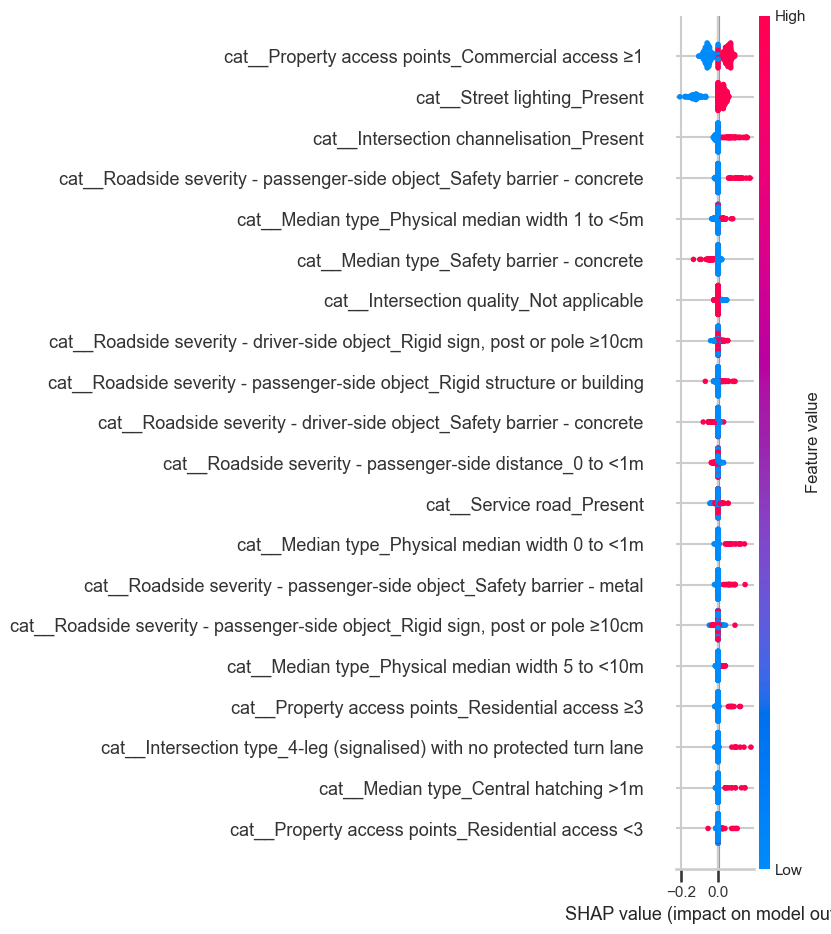

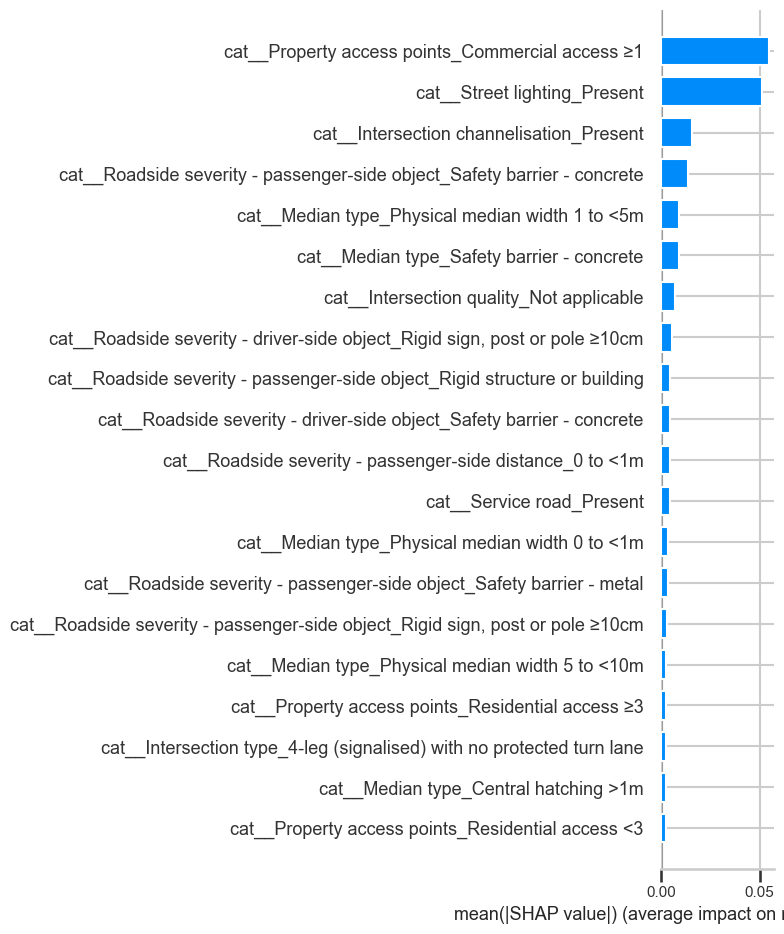

In [ ]:
import shap

f_noexp = lambda X_: xgb_noexp.predict_proba(X_)[:, 1]

bg_noexp = X_train_dm_noexp[np.random.choice(
    X_train_dm_noexp.shape[0],
    size=min(200, X_train_dm_noexp.shape[0]),
    replace=False
)]

explainer_noexp = shap.KernelExplainer(f_noexp, bg_noexp)
shap_values_noexp = explainer_noexp.shap_values(X_test_dm_noexp[:500], nsamples=200)

# Beeswarm
shap.summary_plot(
    shap_values_noexp,
    X_test_dm_noexp[:500],
    feature_names=feature_names_noexp,
    max_display=20
)

# Bar
shap.summary_plot(
    shap_values_noexp,
    X_test_dm_noexp[:500],
    feature_names=feature_names_noexp,
    plot_type="bar",
    max_display=20
)


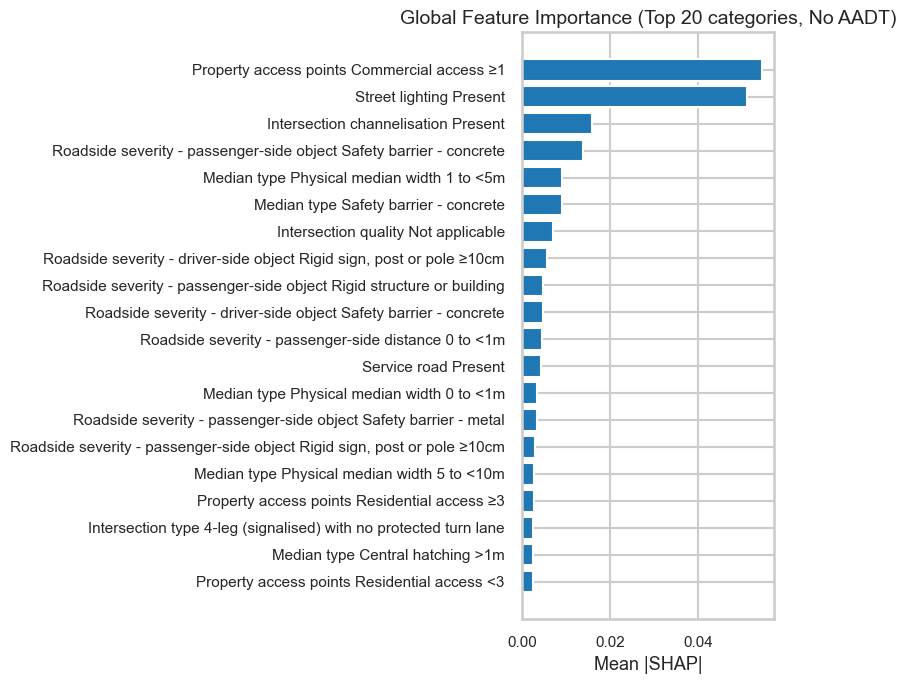

In [73]:
mean_abs_shap_noexp = np.abs(shap_values_noexp).mean(axis=0)

imp_noexp = pd.DataFrame({
    "feature": feature_names_noexp,
    "mean_abs_shap": mean_abs_shap_noexp
})

# Sort + take top 20
imp_noexp = imp_noexp.sort_values("mean_abs_shap", ascending=True).tail(20)

# Clean names
imp_noexp["feature"] = imp_noexp["feature"].apply(clean_name)

# ---- Plot (same style as your main figure) ----
plt.figure(figsize=(8, 7))
plt.barh(imp_noexp["feature"], imp_noexp["mean_abs_shap"])
plt.xlabel("Mean |SHAP|")
plt.title("Global Feature Importance (Top 20 categories, No AADT)")
plt.tight_layout()
plt.show()

In [50]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.utils.class_weight import compute_sample_weight

# Use the fitted preprocess from your pipeline
preprocess = clf.named_steps["preprocess"]

# Transform training data
X_train_dm = preprocess.transform(X_train)

# Convert to dense if sparse
X_train_dm = X_train_dm.toarray() if hasattr(X_train_dm, "toarray") else np.asarray(X_train_dm)

# Get feature names
feature_names = preprocess.get_feature_names_out()

# Build DataFrame so names align properly
X_train_df = pd.DataFrame(X_train_dm, columns=feature_names, index=X_train.index)

# Add intercept
X_train_df = sm.add_constant(X_train_df, has_constant="add")

# Make sure y is numeric 0/1
y_train_numeric = pd.Series(y_train).astype(int)

# Recreate sklearn's class_weight="balanced"
weights = compute_sample_weight(class_weight="balanced", y=y_train_numeric)

model_sm = sm.GLM(
    y_train_numeric,
    X_train_df,
    family=sm.families.Binomial(),
    freq_weights=weights
).fit()

print(model_sm.summary())



                 Generalized Linear Model Regression Results                  
Dep. Variable:        hotspot_control   No. Observations:                 5820
Model:                            GLM   Df Residuals:                  5725.00
Model Family:                Binomial   Df Model:                           94
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Wed, 11 Feb 2026   Deviance:                   2.5871e+05
Time:                        13:44:49   Pearson chi2:                 1.27e+19
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

In [51]:
# Extract coefficients
params = model_sm.params
bse = model_sm.bse
pvals = model_sm.pvalues
conf = model_sm.conf_int()
conf.columns = ["ci_low_beta", "ci_high_beta"]

# Combine results
results = pd.DataFrame({
    "beta": params,
    "std_error": bse,
    "p_value": pvals
}).join(conf)

# Convert to Odds Ratios
results["OR"] = np.exp(results["beta"])
results["OR_ci_low"] = np.exp(results["ci_low_beta"])
results["OR_ci_high"] = np.exp(results["ci_high_beta"])

# Remove intercept
results = results.drop(index="const", errors="ignore")

# Sort by effect size
results = results.sort_values("beta", ascending=False)

results.head(20)


,beta,std_error,p_value,ci_low_beta,ci_high_beta,OR,OR_ci_low,OR_ci_high
cat__Intersection type_Roundabout,9.027126e+15,8.179426e+07,0.0,9.027126e+15,9.027126e+15,inf,inf,inf
cat__Intersection type_3-leg (signalised) with protected turn lane,9.019864e+15,7.954246e+07,0.0,9.019864e+15,9.019864e+15,inf,inf,inf
cat__Intersection type_Railway Crossing - passive,7.722014e+15,9.141866e+07,0.0,7.722014e+15,7.722014e+15,inf,inf,inf
cat__Intersection type_3-leg (signalised) with no protected turn lane,7.563448e+15,8.123118e+07,0.0,7.563448e+15,7.563448e+15,inf,inf,inf
cat__Intersection type_4-leg (unsignalised) with protected turn lane,7.537173e+15,7.877684e+07,0.0,7.537172e+15,7.537173e+15,inf,inf,inf
cat__Intersection type_4-leg (signalised) with protected turn lane,7.439538e+15,7.829183e+07,0.0,7.439537e+15,7.439538e+15,inf,inf,inf
cat__Intersection type_4-leg (signalised) with no protected turn lane,7.352516e+15,7.821927e+07,0.0,7.352515e+15,7.352516e+15,inf,inf,inf
cat__Intersection type_4-leg (unsignalised) with no protected turn lane,7.265994e+15,7.852538e+07,0.0,7.265994e+15,7.265995e+15,inf,inf,inf
cat__Intersection type_3-leg (unsignalised) with no protected turn lane,7.204974e+15,7.789680e+07,0.0,7.204974e+15,7.204974e+15,inf,inf,inf
cat__Intersection type_3-leg (unsignalised) with protected turn lane,6.951539e+15,7.825992e+07,0.0,6.951539e+15,6.951540e+15,inf,inf,inf


In [52]:
stable = results[
    np.isfinite(results["OR"]) &
    (results["std_error"] < 5) &
    (results["beta"].abs() < 5)
]

stable.head(20)


,beta,std_error,p_value,ci_low_beta,ci_high_beta,OR,OR_ci_low,OR_ci_high
cat__Roadside severity - passenger-side object_Unprotected safety barrier end,3.620104,8.529159e-08,0.0,3.620104,3.620104,37.341439,37.341433,37.341446
cat__Intersection type_Mini roundabout,-0.404301,3.534431e-08,0.0,-0.404301,-0.404300,0.667444,0.667443,0.667444


In [53]:
print(stable)

                                                                                   beta  \
cat__Roadside severity - passenger-side object_Unprotected safety barrier end  3.620104   
cat__Intersection type_Mini roundabout                                        -0.404301   

                                                                                  std_error  \
cat__Roadside severity - passenger-side object_Unprotected safety barrier end  8.529159e-08   
cat__Intersection type_Mini roundabout                                         3.534431e-08   

                                                                               p_value  \
cat__Roadside severity - passenger-side object_Unprotected safety barrier end      0.0   
cat__Intersection type_Mini roundabout                                             0.0   

                                                                               ci_low_beta  \
cat__Roadside severity - passenger-side object_Unprotected safety barrier e

In [44]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.utils.class_weight import compute_sample_weight

# -------------------------
# 7. Inference: p-values + 95% CI for OR
# -------------------------

# Use the SAME train split and the SAME preprocess fitted in your sklearn pipeline
preprocess = clf.named_steps["preprocess"]
preprocess.fit(X_train)  # safe; clf already fit, but doesn't hurt

# Transform X_train to design matrix
X_train_dm = preprocess.transform(X_train)
X_train_dm = X_train_dm.toarray() if hasattr(X_train_dm, "toarray") else np.asarray(X_train_dm)

# Feature names from preprocessing
feature_names = np.asarray(preprocess.get_feature_names_out(), dtype=str)

# Build named DataFrame (prevents misalignment bugs)
X_train_df = pd.DataFrame(X_train_dm, columns=feature_names, index=X_train.index)

# Add intercept
X_train_df = sm.add_constant(X_train_df, has_constant="add")

# Ensure y_train is 0/1 integers
y_train01 = pd.Series(y_train).astype(int)

# Create sample weights equivalent to sklearn class_weight="balanced"
w_train = compute_sample_weight(class_weight="balanced", y=y_train01)

# Fit (unpenalized) logistic regression for inference
glm = sm.GLM(
    y_train01,
    X_train_df,
    family=sm.families.Binomial(),
    freq_weights=w_train
).fit(maxiter=200)

# Extract results
params = glm.params
bse = glm.bse
pvals = glm.pvalues

ci_beta = glm.conf_int()
ci_beta.columns = ["ci_low_beta", "ci_high_beta"]

res = pd.DataFrame({
    "beta": params,
    "se": bse,
    "p_value": pvals,
}).join(ci_beta)

# Convert to Odds Ratios (OR) and 95% CI for OR
res["OR"] = np.exp(res["beta"])
res["OR_ci_low"] = np.exp(res["ci_low_beta"])
res["OR_ci_high"] = np.exp(res["ci_high_beta"])

# Drop intercept row for reporting
res = res.drop(index="const", errors="ignore")

# Sort like your table
res = res.sort_values("beta", ascending=False)

# Show top 20
res.head(20)


,beta,se,p_value,ci_low_beta,ci_high_beta,OR,OR_ci_low,OR_ci_high
cat__Intersection type_Roundabout,9.635127e+15,8.179426e+07,0.0,9.635127e+15,9.635127e+15,inf,inf,inf
cat__Intersection type_4-leg (unsignalised) with no protected turn lane,9.259210e+15,7.852538e+07,0.0,9.259210e+15,9.259210e+15,inf,inf,inf
cat__Intersection type_4-leg (signalised) with protected turn lane,8.873374e+15,7.829183e+07,0.0,8.873374e+15,8.873374e+15,inf,inf,inf
cat__Intersection type_3-leg (signalised) with protected turn lane,8.467269e+15,7.954246e+07,0.0,8.467268e+15,8.467269e+15,inf,inf,inf
cat__Intersection type_4-leg (signalised) with no protected turn lane,8.083999e+15,7.821927e+07,0.0,8.083999e+15,8.083999e+15,inf,inf,inf
cat__Intersection type_3-leg (signalised) with no protected turn lane,7.757311e+15,8.123118e+07,0.0,7.757311e+15,7.757311e+15,inf,inf,inf
cat__Intersection type_3-leg (unsignalised) with protected turn lane,7.654948e+15,7.825992e+07,0.0,7.654948e+15,7.654948e+15,inf,inf,inf
cat__Intersection type_4-leg (unsignalised) with protected turn lane,7.459360e+15,7.877684e+07,0.0,7.459360e+15,7.459360e+15,inf,inf,inf
cat__Intersection type_3-leg (unsignalised) with no protected turn lane,7.298619e+15,7.789680e+07,0.0,7.298618e+15,7.298619e+15,inf,inf,inf
cat__Intersection quality_Not applicable,7.230829e+15,7.805012e+07,0.0,7.230829e+15,7.230829e+15,inf,inf,inf


In [45]:
top20 = res.head(20).copy()

top20["OR (95% CI)"] = (
    top20["OR"].round(2).astype(str)
    + " (" + top20["OR_ci_low"].round(2).astype(str)
    + "–" + top20["OR_ci_high"].round(2).astype(str)
    + ")"
)

top20["p_value"] = top20["p_value"].apply(lambda x: "<0.001" if x < 0.001 else f"{x:.3f}")

table5 = top20.reset_index().rename(columns={"index": "feature"})
table5 = table5[["feature", "beta", "OR (95% CI)", "p_value"]]

table5


,feature,beta,OR (95% CI),p_value
0,cat__Intersection type_Roundabout,9.635127e+15,inf (inf–inf),<0.001
1,cat__Intersection type_4-leg (unsignalised) with no protected turn lane,9.259210e+15,inf (inf–inf),<0.001
2,cat__Intersection type_4-leg (signalised) with protected turn lane,8.873374e+15,inf (inf–inf),<0.001
3,cat__Intersection type_3-leg (signalised) with protected turn lane,8.467269e+15,inf (inf–inf),<0.001
4,cat__Intersection type_4-leg (signalised) with no protected turn lane,8.083999e+15,inf (inf–inf),<0.001
5,cat__Intersection type_3-leg (signalised) with no protected turn lane,7.757311e+15,inf (inf–inf),<0.001
6,cat__Intersection type_3-leg (unsignalised) with protected turn lane,7.654948e+15,inf (inf–inf),<0.001
7,cat__Intersection type_4-leg (unsignalised) with protected turn lane,7.459360e+15,inf (inf–inf),<0.001
8,cat__Intersection type_3-leg (unsignalised) with no protected turn lane,7.298619e+15,inf (inf–inf),<0.001
9,cat__Intersection quality_Not applicable,7.230829e+15,inf (inf–inf),<0.001


In [46]:
stable = res[
    np.isfinite(res["OR"]) &
    np.isfinite(res["OR_ci_low"]) &
    np.isfinite(res["OR_ci_high"]) &
    (res["se"] < 10) &
    (res["beta"].abs() < 10)
].sort_values("beta", ascending=False)

stable.head(20)


,beta,se,p_value,ci_low_beta,ci_high_beta,OR,OR_ci_low,OR_ci_high
cat__Intersection type_Mini roundabout,-0.025599,3.534431e-08,0.0,-0.025599,-0.025599,0.974726,0.974726,0.974726
cat__Roadside severity - passenger-side object_Unprotected safety barrier end,-0.972779,8.529159e-08,0.0,-0.972779,-0.972778,0.378031,0.378031,0.378031


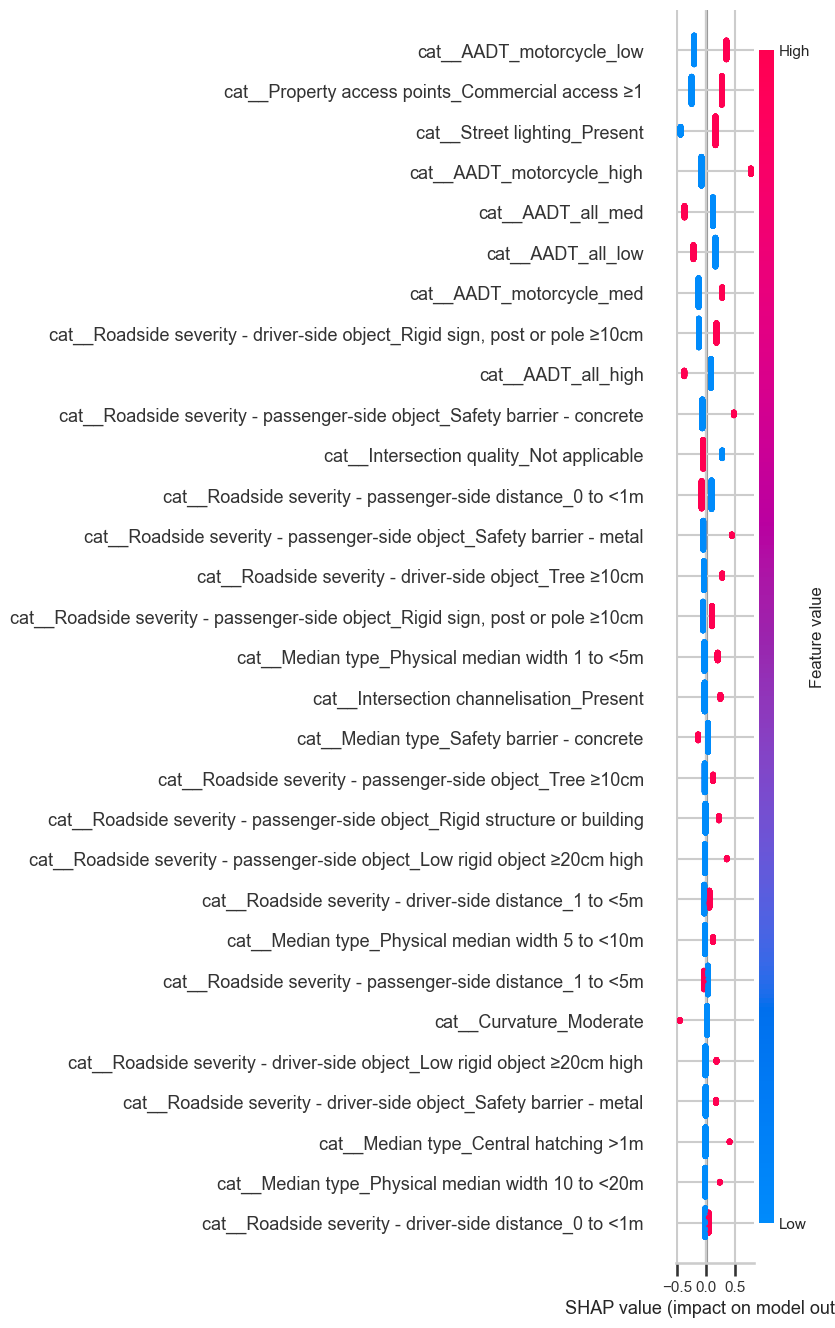

In [47]:
import numpy as np
import pandas as pd
import shap

# fitted pipeline: clf
preprocess = clf.named_steps["preprocess"]
model = clf.named_steps["model"]

# transform data to the model's input space (after preprocessing)
X_train_dm = preprocess.transform(X_train)
X_test_dm  = preprocess.transform(X_test)

# feature names after preprocessing
feature_names = preprocess.get_feature_names_out()

# shap wants dense for many setups (safe fallback)
X_train_dm = X_train_dm.toarray() if hasattr(X_train_dm, "toarray") else np.asarray(X_train_dm)
X_test_dm  = X_test_dm.toarray() if hasattr(X_test_dm, "toarray") else np.asarray(X_test_dm)

# background for SHAP (use a subset for speed)
bg_idx = np.random.choice(X_train_dm.shape[0], size=min(1000, X_train_dm.shape[0]), replace=False)
background = X_train_dm[bg_idx]

explainer = shap.LinearExplainer(model, background, feature_perturbation="interventional")

shap_values = explainer.shap_values(X_test_dm)

# summary plot
shap.summary_plot(shap_values, features=X_test_dm, feature_names=feature_names, max_display=30)


In [48]:
shap_values

array([[-0.00262024, -0.14220686, -0.0342034 , ..., -0.21071181,
        -0.08500518,  0.09992981],
       [-0.00262024,  0.02912671, -0.0342034 , ..., -0.21071181,
        -0.08500518,  0.        ],
       [-0.00262024, -0.14220686, -0.0342034 , ..., -0.21071181,
        -0.08500518,  0.        ],
       ...,
       [-0.00262024,  0.02912671, -0.0342034 , ...,  0.34379295,
        -0.08500518,  0.        ],
       [-0.00262024,  0.02912671,  0.19381929, ...,  0.34379295,
        -0.08500518,  0.        ],
       [-0.00262024, -0.14220686, -0.0342034 , ..., -0.21071181,
         0.76504661,  0.        ]])

In [33]:
# Ensure y is 0/1 int
y_train01 = pd.Series(y_train).astype(int).values

# Build dense design matrix
X_train_dm = preprocess.transform(X_train)
X_train_dm = X_train_dm.toarray() if hasattr(X_train_dm, "toarray") else np.asarray(X_train_dm)

feature_names = np.asarray(preprocess.get_feature_names_out(), dtype=str)

# Drop columns with near-zero variance / extremely rare "1"s
# (This targets one-hot columns; it is safe for numeric too.)
col_sum = X_train_dm.sum(axis=0)
col_nonzero = (X_train_dm != 0).sum(axis=0)

# thresholds (tune if needed)
min_nonzero = 20        # column must be non-zero at least 20 times in train
min_sum = 20            # for 0/1 dummies, same idea

keep = (col_nonzero >= min_nonzero) & (col_sum >= min_sum)

X_train_dm2 = X_train_dm[:, keep]
feature_names2 = feature_names[keep]

# Add intercept
X_train_sm2 = sm.add_constant(X_train_dm2, has_constant="add")
sm_feature_names2 = np.concatenate([np.array(["const"]), feature_names2])

# Sample weights (to match sklearn class_weight="balanced")
w_train = compute_sample_weight(class_weight="balanced", y=y_train01)

glm = sm.GLM(
    y_train01,
    X_train_sm2,
    family=sm.families.Binomial(),
    freq_weights=w_train
).fit(maxiter=200)

print(glm.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5820
Model:                            GLM   Df Residuals:                  5749.00
Model Family:                Binomial   Df Model:                           70
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -3734.3
Date:                Tue, 10 Feb 2026   Deviance:                       7468.7
Time:                        22:20:38   Pearson chi2:                 5.83e+03
No. Iterations:                     4   Pseudo R-squ. (CS):            0.09789
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3298      0.856     -1.554      0.1

In [34]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.utils.class_weight import compute_sample_weight

# 1) transform with your already-fitted preprocess
X_train_dm = preprocess.transform(X_train)
X_train_dm = X_train_dm.toarray() if hasattr(X_train_dm, "toarray") else np.asarray(X_train_dm)

feature_names = np.asarray(preprocess.get_feature_names_out(), dtype=str)

# 2) create a DataFrame so statsmodels keeps names (prevents misalignment bugs)
X_train_df = pd.DataFrame(X_train_dm, columns=feature_names, index=X_train.index)

# 3) add intercept
X_train_df = sm.add_constant(X_train_df, has_constant="add")

# 4) weights to match sklearn class_weight="balanced"
y_train01 = pd.Series(y_train).astype(int)
w_train = compute_sample_weight(class_weight="balanced", y=y_train01)

# 5) fit GLM
glm = sm.GLM(
    y_train01,
    X_train_df,
    family=sm.families.Binomial(),
    freq_weights=w_train
).fit(maxiter=200)

print(glm.summary())


                 Generalized Linear Model Regression Results                  
Dep. Variable:        hotspot_control   No. Observations:                 5820
Model:                            GLM   Df Residuals:                  5725.00
Model Family:                Binomial   Df Model:                           94
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Tue, 10 Feb 2026   Deviance:                   2.7112e+05
Time:                        22:21:07   Pearson chi2:                 1.33e+19
No. Iterations:                   200   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
                                                                                                    coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------

In [35]:
# Coefs, SE, p-values
params = glm.params
bse = glm.bse
pvals = glm.pvalues

# 95% CI on beta
ci_beta = glm.conf_int()
ci_beta.columns = ["ci_low_beta", "ci_high_beta"]

# Assemble results (IMPORTANT: all are aligned by index automatically)
res = pd.DataFrame({
    "beta": params,
    "se": bse,
    "p_value": pvals,
}).join(ci_beta)

# Convert to OR
res["OR"] = np.exp(res["beta"])
res["OR_ci_low"] = np.exp(res["ci_low_beta"])
res["OR_ci_high"] = np.exp(res["ci_high_beta"])

# Drop intercept for table
res = res.drop(index="const", errors="ignore")

# Sort by beta descending (like your Table 5)
res_sorted = res.sort_values("beta", ascending=False)

# Example: top 20 positive predictors
top20 = res_sorted.head(20)
top20


,beta,se,p_value,ci_low_beta,ci_high_beta,OR,OR_ci_low,OR_ci_high
cat__Intersection type_Roundabout,9.635127e+15,8.179426e+07,0.0,9.635127e+15,9.635127e+15,inf,inf,inf
cat__Intersection type_4-leg (unsignalised) with no protected turn lane,9.259210e+15,7.852538e+07,0.0,9.259210e+15,9.259210e+15,inf,inf,inf
cat__Intersection type_4-leg (signalised) with protected turn lane,8.873374e+15,7.829183e+07,0.0,8.873374e+15,8.873374e+15,inf,inf,inf
cat__Intersection type_3-leg (signalised) with protected turn lane,8.467269e+15,7.954246e+07,0.0,8.467268e+15,8.467269e+15,inf,inf,inf
cat__Intersection type_4-leg (signalised) with no protected turn lane,8.083999e+15,7.821927e+07,0.0,8.083999e+15,8.083999e+15,inf,inf,inf
cat__Intersection type_3-leg (signalised) with no protected turn lane,7.757311e+15,8.123118e+07,0.0,7.757311e+15,7.757311e+15,inf,inf,inf
cat__Intersection type_3-leg (unsignalised) with protected turn lane,7.654948e+15,7.825992e+07,0.0,7.654948e+15,7.654948e+15,inf,inf,inf
cat__Intersection type_4-leg (unsignalised) with protected turn lane,7.459360e+15,7.877684e+07,0.0,7.459360e+15,7.459360e+15,inf,inf,inf
cat__Intersection type_3-leg (unsignalised) with no protected turn lane,7.298619e+15,7.789680e+07,0.0,7.298618e+15,7.298619e+15,inf,inf,inf
cat__Intersection quality_Not applicable,7.230829e+15,7.805012e+07,0.0,7.230829e+15,7.230829e+15,inf,inf,inf


In [36]:
pub = top20.copy()

pub["OR (95% CI)"] = (
    pub["OR"].round(2).astype(str)
    + " (" + pub["OR_ci_low"].round(2).astype(str)
    + "–" + pub["OR_ci_high"].round(2).astype(str) + ")"
)

pub["p_value"] = pub["p_value"].apply(lambda x: "<0.001" if x < 0.001 else f"{x:.3f}")

pub_table = pub.reset_index().rename(columns={"index": "feature"})
pub_table = pub_table[["feature", "beta", "OR (95% CI)", "p_value"]]
pub_table


,feature,beta,OR (95% CI),p_value
0,cat__Intersection type_Roundabout,9.635127e+15,inf (inf–inf),<0.001
1,cat__Intersection type_4-leg (unsignalised) with no protected turn lane,9.259210e+15,inf (inf–inf),<0.001
2,cat__Intersection type_4-leg (signalised) with protected turn lane,8.873374e+15,inf (inf–inf),<0.001
3,cat__Intersection type_3-leg (signalised) with protected turn lane,8.467269e+15,inf (inf–inf),<0.001
4,cat__Intersection type_4-leg (signalised) with no protected turn lane,8.083999e+15,inf (inf–inf),<0.001
5,cat__Intersection type_3-leg (signalised) with no protected turn lane,7.757311e+15,inf (inf–inf),<0.001
6,cat__Intersection type_3-leg (unsignalised) with protected turn lane,7.654948e+15,inf (inf–inf),<0.001
7,cat__Intersection type_4-leg (unsignalised) with protected turn lane,7.459360e+15,inf (inf–inf),<0.001
8,cat__Intersection type_3-leg (unsignalised) with no protected turn lane,7.298619e+15,inf (inf–inf),<0.001
9,cat__Intersection quality_Not applicable,7.230829e+15,inf (inf–inf),<0.001


In [43]:
stable = res[
    (res["se"] < 5) &
    (res["beta"].abs() < 5) &
    np.isfinite(res["OR"])
]

stable_sorted = stable.sort_values("beta", ascending=False)
stable_top = stable_sorted.head(20)
stable_top

,beta,se,p_value,ci_low_beta,ci_high_beta,OR,OR_ci_low,OR_ci_high
cat__Intersection type_Mini roundabout,-0.025599,3.534431e-08,0.0,-0.025599,-0.025599,0.974726,0.974726,0.974726
cat__Roadside severity - passenger-side object_Unprotected safety barrier end,-0.972779,8.529159e-08,0.0,-0.972779,-0.972778,0.378031,0.378031,0.378031


# XGBOOST + SHAP

In [250]:
cat_tf = Pipeline(
    steps=[
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(
            handle_unknown="ignore",
            drop="first",        # <-- DROP FIRST CATEGORY
            sparse_output=False
        )),
    ]
)


In [252]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)

from xgboost import XGBClassifier

np.random.seed(42)

# -------------------------------------------------
# 1) Reuse X, y from logistic regression section
#    (X: features, y: 0 = control, 1 = hotspot)
# -------------------------------------------------
print("X shape:", X.shape)
print("y distribution:", np.bincount(y), "(0=control, 1=hotspot)")

# Identify numeric / categorical features
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(f"Features: numeric={len(numeric_cols)}, categorical={len(categorical_cols)}")

# -------------------------------------------------
# 2) Train / test split
# -------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

# -------------------------------------------------
# 3) Preprocessor with drop='first' for categories
# -------------------------------------------------
num_tf = Pipeline(
    steps=[
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler()),
    ]
)

cat_tf = Pipeline(
    steps=[
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(
            handle_unknown="ignore",
            drop="first",        # << drop reference category for each attribute
            sparse_output=False,
        )),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, numeric_cols),
        ("cat", cat_tf, categorical_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0,
)

# -------------------------------------------------
# 4) XGBoost model
# -------------------------------------------------
xgb_clf = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

pipe = Pipeline([
    ("pre", preprocess),
    ("clf", xgb_clf),
])

# -------------------------------------------------
# 5) Fit + evaluate
# -------------------------------------------------
pipe.fit(X_train, y_train)

y_prob = pipe.predict_proba(X_test)[:, 1]

# Choose threshold by maximising balanced accuracy
ths = np.linspace(0.2, 0.8, 25)
scores = [(balanced_accuracy_score(y_test, (y_prob >= t).astype(int)), t) for t in ths]
best_balacc, best_thr = max(scores, key=lambda x: x[0])
y_pred = (y_prob >= best_thr).astype(int)

print(f"\nBest threshold on test = {best_thr:.2f}")
print(f"AUROC    = {roc_auc_score(y_test, y_prob):.3f}")
print(f"AUPRC    = {average_precision_score(y_test, y_prob):.3f}")
print(f"F1       = {f1_score(y_test, y_pred):.3f}")
print(f"BalAcc   = {balanced_accuracy_score(y_test, y_pred):.3f}")
print("\nTest classification report:")
print(classification_report(y_test, y_pred,
                            target_names=["control", "hotspot"],
                            digits=3))


X shape: (7276, 26)
y distribution: [3374 3902] (0=control, 1=hotspot)
Features: numeric=0, categorical=26
Train size: 5093 Test size: 2183

Best threshold on test = 0.55
AUROC    = 0.654
AUPRC    = 0.682
F1       = 0.638
BalAcc   = 0.620

Test classification report:
              precision    recall  f1-score   support

     control      0.586     0.618     0.601      1012
     hotspot      0.653     0.623     0.638      1171

    accuracy                          0.620      2183
   macro avg      0.619     0.620     0.619      2183
weighted avg      0.622     0.620     0.621      2183



In [278]:
import shap
from scipy import sparse
import matplotlib.pyplot as plt

# -------------------------------------------------
# 6) Refit on ALL data for final SHAP analysis
# -------------------------------------------------
pipe.fit(X, y)

pre_best = pipe.named_steps["pre"]
clf_best = pipe.named_steps["clf"]

# Transform all data using the fitted preprocessor
X_enc = pre_best.transform(X)
feat_names = pre_best.get_feature_names_out()

if sparse.issparse(X_enc):
    X_enc = X_enc.astype(np.float32).toarray()
else:
    X_enc = np.asarray(X_enc, dtype=np.float32)

# Sample for SHAP (to keep it fast)
n_sample = min(2000, X_enc.shape[0])
rng = np.random.default_rng(42)
idx = rng.choice(X_enc.shape[0], size=n_sample, replace=False)
X_sample = X_enc[idx]

# -------------------------------------------------
# 7) SHAP Explainer (model-agnostic, robust)
# -------------------------------------------------
# We pass a prediction function returning P(y=1 | x)
model_predict_proba = lambda data: clf_best.predict_proba(data)[:, 1]

explainer = shap.Explainer(
    model_predict_proba,
    X_sample,
    feature_names=feat_names,
    algorithm="permutation",  # robust & version-agnostic
)

shap_values = explainer(X_sample)   # shap.Explanation
sv_arr = shap_values.values         # (n_sample, n_features)

# -------------------------------------------------
# 8) SHAP beeswarm plot
# -------------------------------------------------
shap.summary_plot(
    shap_values,               # Explanation object
    features=X_sample,
    feature_names=feat_names,
    show=False,
    max_display=25,
)
plt.tight_layout()
plt.savefig("shap_beeswarm_top25_simple.png", dpi=300, bbox_inches="tight")
plt.close()

# -------------------------------------------------
# 9) SHAP bar plot (global importance)
# -------------------------------------------------
mean_abs = np.mean(np.abs(sv_arr), axis=0).reshape(-1)
order = np.argsort(-mean_abs)[:25]

plt.figure(figsize=(7, 8))
plt.barh(np.array(feat_names)[order][::-1], mean_abs[order][::-1])
plt.xlabel("Mean |SHAP|")
plt.title("Global Feature Importance (Top 25)")
plt.tight_layout()
plt.savefig("shap_bar_top25_simple.png", dpi=300, bbox_inches="tight")
plt.close()

shap_df = (
    pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs})
    .sort_values("mean_abs_shap", ascending=False)
)

print("\nTop 20 features by mean |SHAP|:")
print(shap_df.head(20))

print("Saved figures: shap_beeswarm_top20_simple.png, shap_bar_top20_simple.png")


PermutationExplainer explainer: 2001it [00:22, 50.05it/s]                           



Top 20 features by mean |SHAP|:
                                                                          feature  \
65                                             cat__Property access points__None_   
79                                                   cat__Street lighting_Present   
93                                                    cat__AADT_motorcycle_lowest   
89                                                           cat__AADT_all_lowest   
87                                                          cat__AADT_all_highest   
59                                                  cat__Intersection type__None_   
94                                                       cat__AADT_motorcycle_med   
1                                                    cat__Median type_Centre line   
10                                     cat__Median type_Safety barrier - concrete   
23          cat__Roadside severity - driver-side object_Safety barrier - concrete   
63                              

In [279]:
pretty_names = []

for f in feat_names:
    if f.startswith("cat__"):
        # original format: cat__AttributeName_ClassName
        raw = f.replace("cat__", "")
        parts = raw.split("_")

        attribute = " ".join(parts[:-1])     # everything except last token
        category  = parts[-1]               # last token = class

        # Clean up
        attribute = attribute.replace("__", " ").replace("_", " ")
        category  = category.replace("__", " ").replace("_", " ")

        pretty = f"{attribute}: {category}"

    else:
        # numeric or unknown
        pretty = f.replace("num__", "").replace("_", " ")

    pretty_names.append(pretty)

pretty_names = np.array(pretty_names)


In [280]:
# --- Wrap sample in DataFrame ---
X_sample_df = pd.DataFrame(X_sample, columns=pretty_names)

# --- SHAP beeswarm ---
shap.summary_plot(
    shap_values,
    features=X_sample_df,
    feature_names=pretty_names,
    show=False,
    max_display=20,
    # dot_size=6
)

# Reduce label font size
plt.gca().tick_params(axis='y', labelsize=9)
plt.gca().tick_params(axis='x', labelsize=10)

plt.title("SHAP Beeswarm: Top 20 Categories", fontsize=14)
plt.tight_layout()
plt.savefig("shap_beeswarm_top20_pretty.png", dpi=300, bbox_inches="tight")
plt.close()


In [285]:
# --- 3. Bar plot (global importance) with pretty labels ---
mean_abs = np.mean(np.abs(sv_arr), axis=0).reshape(-1)
shap_df = (
    pd.DataFrame({
        "feature_raw": feat_names,
        "feature": pretty_names,
        "mean_abs_shap": mean_abs,
    })
    .sort_values("mean_abs_shap", ascending=False)
)

top_k = 20  # change to 15 if you want it even clearer
shap_top = shap_df.head(top_k).iloc[::-1]  # reverse for nicer barh order

plt.figure(figsize=(7, 12))
plt.rcParams.update({
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 9,
    "xtick.labelsize": 8,
    "ytick.labelsize": 10,   # <--- shrink y-axis labels
})
plt.barh(shap_top["feature"], shap_top["mean_abs_shap"])
plt.xlabel("Mean |SHAP|", fontsize=10)
plt.title("Global Feature Importance (Top {} Categories)".format(top_k), fontsize=10)
plt.tight_layout()
plt.savefig("shap_bar_top{}_pretty.png".format(top_k), dpi=300, bbox_inches="tight")
plt.close()

print("\nTop 20 features by mean |SHAP| (with pretty names):")
print(shap_df.head(20)[["feature", "mean_abs_shap"]])



Top 20 features by mean |SHAP| (with pretty names):
                                                                      feature  \
65                                             Property access points  None:    
79                                                   Street lighting: Present   
93                                                    AADT motorcycle: lowest   
89                                                           AADT all: lowest   
87                                                          AADT all: highest   
59                                                  Intersection type  None:    
94                                                       AADT motorcycle: med   
1                                                    Median type: Centre line   
10                                     Median type: Safety barrier - concrete   
23          Roadside severity - driver-side object: Safety barrier - concrete   
63                              Property access points: 

# Spare

In [229]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report

# -----------------------
# 0. Split X / y
# -----------------------
# df = pd.read_csv("your_data.csv")
# y = df["target"]
# X = df.drop(columns=["target"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# -----------------------
# 1. Identify column types
# -----------------------
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X.select_dtypes(include=["object", "category", "bool"]).columns

print("Numeric:", list(numeric_features))
print("Categorical:", list(categorical_features))

# -----------------------
# 2. Preprocessing: scale nums, one-hot cats
# -----------------------
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

# -----------------------
# 3. Build pipeline
# -----------------------
clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            max_iter=1000,
            solver="liblinear",
            class_weight="balanced"  # optional
        )),
    ]
)

# -----------------------
# 4. Fit model
# -----------------------
clf.fit(X_train, y_train)

# -----------------------
# 5. Evaluate
# -----------------------
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))


Numeric: []
Categorical: ['Differential speed limits', 'Median type', 'Centreline rumble strips', 'Roadside severity - driver-side distance', 'Roadside severity - driver-side object', 'Roadside severity - passenger-side distance', 'Roadside severity - passenger-side object', 'Shoulder rumble strips', 'Intersection type', 'Intersection channelisation', 'Intersection quality', 'Property access points', 'Lane width', 'Curvature', 'Quality of curve', 'Grade', 'Road condition', 'Skid resistance / grip', 'Delineation', 'Street lighting', 'Speed management / traffic calming', 'Service road', 'Facilities for motorised two wheelers', 'Sight distance', 'AADT_all', 'AADT_motorcycle']
Accuracy: 0.6285126799177518
ROC-AUC: 0.6713331443688587

Confusion matrix:
 [[413 262]
 [280 504]]

Classification report:
               precision    recall  f1-score   support

           0       0.60      0.61      0.60       675
           1       0.66      0.64      0.65       784

    accuracy                 

In [230]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score

# y = df["target"]
# X = df.drop(columns=["target"])

# One-hot encode categoricals
X_encoded = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42, stratify=y
)

# Scale (optional, but common)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

logreg = LogisticRegression(max_iter=1000, solver="liblinear", class_weight="balanced")
logreg.fit(X_train_scaled, y_train)

y_pred = logreg.predict(X_test_scaled)
y_prob = logreg.predict_proba(X_test_scaled)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))


Accuracy: 0.6312542837559972
ROC-AUC: 0.6725425170068027


In [231]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np

# ---------------------------------
# 0. Split X / y (whatever you did)
# ---------------------------------
# df = ...
# y = df["hotspot"]  # or your target
# X = df.drop(columns=["hotspot"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------------
# 1. Auto-detect numeric / categorical
#    (NO manual list, avoids KeyError)
# ---------------------------------
numeric_features = X_train.select_dtypes(include=["int64", "float64"]).columns
categorical_features = X_train.select_dtypes(include=["object", "category", "bool"]).columns

print("Numeric features:", list(numeric_features))
print("Categorical features:", list(categorical_features))
print("'Differential speed limits' in X_train?", "Differential speed limits" in X_train.columns)


Numeric features: []
Categorical features: ['Differential speed limits', 'Median type', 'Centreline rumble strips', 'Roadside severity - driver-side distance', 'Roadside severity - driver-side object', 'Roadside severity - passenger-side distance', 'Roadside severity - passenger-side object', 'Shoulder rumble strips', 'Intersection type', 'Intersection channelisation', 'Intersection quality', 'Property access points', 'Lane width', 'Curvature', 'Quality of curve', 'Grade', 'Road condition', 'Skid resistance / grip', 'Delineation', 'Street lighting', 'Speed management / traffic calming', 'Service road', 'Facilities for motorised two wheelers', 'Sight distance', 'AADT_all', 'AADT_motorcycle']
'Differential speed limits' in X_train? True


In [232]:
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

clf = Pipeline(
    steps=[
        ("preprocess", preprocess),
        ("model", LogisticRegression(
            max_iter=1000,
            solver="liblinear",
            class_weight="balanced"  # optional
        )),
    ]
)

clf.fit(X_train, y_train)


,steps,"[('preprocess', ...), ('model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [1]:
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# Evaluate
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))

# ---- Coefficients / odds ratios ----
preprocess = clf.named_steps["preprocess"]
model = clf.named_steps["model"]

feature_names = preprocess.get_feature_names_out()
coefs = model.coef_.ravel()

coef_df = pd.DataFrame({
    "feature": feature_names,
    "coef": coefs,
})

coef_df["odds_ratio"] = np.exp(coef_df["coef"])
coef_df = coef_df.sort_values("coef", ascending=False)

coef_df.head(20)


NameError: name 'clf' is not defined

In [217]:
df['AADT_all'].unique()

array(['med', 'low', 'lowest', 'high', 'highest'], dtype=object)

# Spare

In [ ]:
import numpy as np
import pandas as pd
import warnings

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

import matplotlib.pyplot as plt
from scipy import sparse

warnings.filterwarnings("ignore")
np.random.seed(42)

# =========================
# 0. Load + merge datasets
# =========================
df = pd.read_csv("./result/gemini-2.5-flash.csv")
df_info = pd.read_csv("./result/hotspot_control_filtered.csv")

# merge hotspot/control + AADT
df = df.merge(
    df_info[["image_id", "hotspot_control", "all_label", "motorcycle_label"]],
    on="image_id",
    how="left",
)

# rename AADT columns
df.rename(columns={"all_label": "AADT_all",
                   "motorcycle_label": "AADT_motorcycle"},
          inplace=True)

# drop attributes with Gemini F1-weighted < 0.70
low_f1_cols = [
    "Paved shoulder - driver-side",
    "Paved shoulder - passenger-side",
    "Number of lanes",
]
df = df.drop(columns=[c for c in low_f1_cols if c in df.columns],
             errors="ignore")

print("Initial df shape:", df.shape)

# =========================
# 1. Define modelling subset
# =========================
# Keep only rows with valid hotspot_control label
df_model = df[df["hotspot_control"].notna()].copy()
df_model.reset_index(drop=True, inplace=True)

print("Modelling df_model shape:", df_model.shape)
print(df_model["hotspot_control"].value_counts())

# =========================
# 2. Define y and X
# =========================
# Binary target: hotspot (1) vs control (0)
if df_model["hotspot_control"].dtype == object:
    y = (df_model["hotspot_control"].str.lower() == "hotspot").astype(int).values
else:
    y = df_model["hotspot_control"].astype(int).values

print("y distribution:", np.bincount(y), "(0=control, 1=hotspot)")

# drop non-feature columns
drop_cols = ["hotspot_control", "image_id"]
X = df_model.drop(columns=[c for c in drop_cols if c in df_model.columns],
                  errors="ignore").copy()

# identify types
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(f"Features: numeric={len(numeric_cols)}, categorical={len(categorical_cols)}")

# =========================
# 3. Train / test split
# =========================
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.3,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape[0], "Test size:", X_test.shape[0])

# =========================
# 4. Preprocessor
# =========================
num_tf = Pipeline(
    steps=[
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler()),
    ]
)

cat_tf = Pipeline(
    steps=[
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", num_tf, numeric_cols),
        ("cat", cat_tf, categorical_cols),
    ],
    remainder="drop",
    sparse_threshold=1.0,
)

# =========================
# 5. XGBoost model
# =========================
from xgboost import XGBClassifier

xgb_clf = XGBClassifier(
    objective="binary:logistic",
    tree_method="hist",
    n_estimators=400,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1,
)

pipe = Pipeline([
    ("pre", preprocess),
    ("clf", xgb_clf),
])

# =========================
# 6. Fit + evaluate
# =========================
pipe.fit(X_train, y_train)

# predicted probabilities on held-out test set
y_prob = pipe.predict_proba(X_test)[:, 1]

# choose threshold by maximising balanced accuracy on test (simple)
ths = np.linspace(0.2, 0.8, 25)
scores = [(balanced_accuracy_score(y_test, (y_prob >= t).astype(int)), t) for t in ths]
best_balacc, best_thr = max(scores, key=lambda x: x[0])
y_pred = (y_prob >= best_thr).astype(int)

print(f"\nBest threshold on test = {best_thr:.2f}")
print(f"AUROC    = {roc_auc_score(y_test, y_prob):.3f}")
print(f"AUPRC    = {average_precision_score(y_test, y_prob):.3f}")
print(f"F1       = {f1_score(y_test, y_pred):.3f}")
print(f"BalAcc   = {balanced_accuracy_score(y_test, y_pred):.3f}")
print("\nTest classification report:")
print(classification_report(y_test, y_pred,
                            target_names=["control", "hotspot"],
                            digits=3))

# =========================
# 7. SHAP analysis (robust version)
# =========================
import shap
from scipy import sparse
import matplotlib.pyplot as plt

# fit on ALL modelling data for final SHAP (as described in paper)
pipe.fit(X, y)

pre_best = pipe.named_steps["pre"]
clf_best = pipe.named_steps["clf"]

# get encoded matrix
X_enc = pre_best.transform(X)
feat_names = pre_best.get_feature_names_out()

if sparse.issparse(X_enc):
    X_enc = X_enc.astype(np.float32).toarray()
else:
    X_enc = np.asarray(X_enc, dtype=np.float32)

# sample for plotting
n_sample = min(2000, X_enc.shape[0])
rng = np.random.default_rng(42)
idx = rng.choice(X_enc.shape[0], size=n_sample, replace=False)
X_sample = X_enc[idx]

# --- SHAP Explainer (permutation-based, robust to xgboost version issues) ---
# permutation explainer expects a callable prediction function (not the estimator object itself).
# Use predict_proba and return the probability for the positive class.
model_predict_proba = lambda data: clf_best.predict_proba(data)[:, 1]

explainer = shap.Explainer(
    model_predict_proba,
    X_sample,
    feature_names=feat_names,
    algorithm="permutation",  # model-agnostic, avoids TreeEnsemble parsing issues
)

shap_values = explainer(X_sample)   # returns a shap.Explanation
sv_arr = shap_values.values         # (n_sample, n_features)

# === SHAP beeswarm plot ===
shap.summary_plot(
    shap_values,               # you can pass the Explanation directly
    features=X_sample,
    feature_names=feat_names,
    show=False,
    max_display=25,
)
plt.tight_layout()
plt.savefig("shap_beeswarm_top25_simple.png", dpi=300, bbox_inches="tight")
plt.close()

# === SHAP bar plot (global importance) ===
mean_abs = np.mean(np.abs(sv_arr), axis=0).reshape(-1)
order = np.argsort(-mean_abs)[:25]

plt.figure(figsize=(7, 8))
plt.barh(np.array(feat_names)[order][::-1], mean_abs[order][::-1])
plt.xlabel("Mean |SHAP|")
plt.title("Global Feature Importance (Top 25)")
plt.tight_layout()
plt.savefig("shap_bar_top25_simple.png", dpi=300, bbox_inches="tight")
plt.close()

shap_df = (
    pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs})
    .sort_values("mean_abs_shap", ascending=False)
)

print("\nTop 20 features by mean |SHAP|:")
print(shap_df.head(20))

print("Saved figures: shap_beeswarm_top25_simple.png, shap_bar_top25_simple.png")


Initial df shape: (7294, 28)
Modelling df_model shape: (7294, 28)
hotspot_control
hotspot    3919
control    3375
Name: count, dtype: int64
y distribution: [3375 3919] (0=control, 1=hotspot)
Features: numeric=0, categorical=26
Train size: 5105 Test size: 2189

Best threshold on test = 0.48
AUROC    = 0.664
AUPRC    = 0.682
F1       = 0.681
BalAcc   = 0.624

Test classification report:
              precision    recall  f1-score   support

     control      0.623     0.517     0.565      1013
     hotspot      0.637     0.730     0.681      1176

    accuracy                          0.632      2189
   macro avg      0.630     0.624     0.623      2189
weighted avg      0.631     0.632     0.627      2189



PermutationExplainer explainer: 2001it [00:37, 38.71it/s]                          



Top 20 features by mean |SHAP|:
                                               feature  mean_abs_shap
98                    cat__Street lighting_Not present       0.040726
74    cat__Property access points_Commercial access ≥1       0.039478
114                               cat__AADT_all_lowest       0.028288
119                        cat__AADT_motorcycle_lowest       0.027728
116                          cat__AADT_motorcycle_high       0.019218
77                  cat__Property access points__None_       0.019214
112                              cat__AADT_all_highest       0.018519
118                           cat__AADT_motorcycle_low       0.014548
12          cat__Median type_Safety barrier - concrete       0.012922
111                                 cat__AADT_all_high       0.012050
28   cat__Roadside severity - driver-side object_Sa...       0.011947
115                                  cat__AADT_all_med       0.011295
99                        cat__Street lighting_Present   

In [187]:
# =========================
# 8. Pretty feature names + nicer plots
# =========================

def pretty_name(raw: str) -> str:
    # remove transformer prefix
    if "__" in raw:
        raw = raw.split("__", 1)[1]
    # split into attribute and category
    if "_" in raw:
        col, cat = raw.split("_", 1)
        return f"{col}: {cat}"
    else:
        return raw

pretty_feat_names = np.array([pretty_name(f) for f in feat_names])

# Rebuild shap_df with pretty names
shap_df_pretty = (
    pd.DataFrame({
        "feature_raw": feat_names,
        "feature": pretty_feat_names,
        "mean_abs_shap": mean_abs
    })
    .sort_values("mean_abs_shap", ascending=False)
)

print("\nTop 15 features (pretty labels):")
print(shap_df_pretty.head(15)[["feature", "mean_abs_shap"]])

# indices of top N features
N = 20
order = np.argsort(-mean_abs)[:N]

# ---- Bar plot ----
plt.rcParams.update({"font.size": 8})
plt.figure(figsize=(6, 6))
plt.barh(pretty_feat_names[order][::-1], mean_abs[order][::-1])
plt.xlabel("Mean |SHAP|")
plt.title("Global Feature Importance (Top 20)")
plt.tight_layout()
plt.savefig("shap_bar_top20_pretty.png", dpi=300, bbox_inches="tight")
plt.close()

# ---- Beeswarm plot ----
plt.rcParams.update({"font.size": 1})
shap.summary_plot(
    shap_values,
    features=X_sample,
    feature_names=pretty_feat_names,
    show=False,
    max_display=N
)
plt.tight_layout()
plt.savefig("shap_beeswarm_top20_pretty.png", dpi=300, bbox_inches="tight")
plt.close()

print("Saved prettier figures:",
      "shap_bar_top20_pretty.png, shap_beeswarm_top20_pretty.png")



Top 15 features (pretty labels):
                                               feature  mean_abs_shap
98                        Street lighting: Not present       0.040726
74        Property access points: Commercial access ≥1       0.039478
114                                   AADT: all_lowest       0.028288
119                            AADT: motorcycle_lowest       0.027728
116                              AADT: motorcycle_high       0.019218
77                      Property access points: _None_       0.019214
112                                  AADT: all_highest       0.018519
118                               AADT: motorcycle_low       0.014548
12              Median type: Safety barrier - concrete       0.012922
111                                     AADT: all_high       0.012050
28   Roadside severity - driver-side object: Safety...       0.011947
115                                      AADT: all_med       0.011295
99                            Street lighting: Present  

In [195]:
# =========================
# 8. Pretty feature names + nicer plots
# =========================

def pretty_name(raw: str) -> str:
    # remove transformer prefix (e.g. "cat__Street lighting_Not present")
    if "__" in raw:
        raw = raw.split("__", 1)[1]
    # split into attribute and category at the FIRST ": " or "_" after that
    # so "Street lighting_Not present" -> "Street lighting: Not present"
    if "_" in raw:
        col, cat = raw.split("_", 1)
        return f"{col}: {cat}"
    else:
        return raw

pretty_feat_names = np.array([pretty_name(f) for f in feat_names])

# Rebuild shap_df with pretty names
shap_df_pretty = (
    pd.DataFrame({
        "feature_raw": feat_names,
        "feature": pretty_feat_names,
        "mean_abs_shap": mean_abs
    })
    .sort_values("mean_abs_shap", ascending=False)
)

print("\nTop 15 features (pretty labels):")
print(shap_df_pretty.head(15)[["feature", "mean_abs_shap"]])

# indices of top N features
N = 20
order = np.argsort(-mean_abs)[:N]

# ---------- Bar plot (no white border, compact fonts) ----------
plt.rcParams.update({"font.size": 8})  # base font size

fig, ax = plt.subplots(figsize=(6, 6))
ax.barh(
    pretty_feat_names[order][::-1],
    mean_abs[order][::-1],
    edgecolor="none"          # <- remove white borders
)
ax.set_xlabel("Mean |SHAP|", fontsize=8)
ax.set_title("Global Feature Importance (Top 20)", fontsize=9)

# slightly smaller tick labels
ax.tick_params(axis="y", labelsize=7)
ax.tick_params(axis="x", labelsize=7)

fig.tight_layout()
fig.savefig("shap_bar_top20_pretty.png", dpi=300, bbox_inches="tight")
plt.close(fig)

# ---------- Beeswarm plot (smaller dots, readable labels) ----------
# small base font, then manually adjust axes
plt.rcParams.update({"font.size": 7})

shap.summary_plot(
    shap_values,
    features=X_sample,
    feature_names=pretty_feat_names,
    show=False,
    max_display=N,
    plot_size=None,      # we will force size below
    alpha=0.7,           # slightly transparent
)

fig = plt.gcf()
ax = plt.gca()

# make figure a bit narrower/taller for paper
fig.set_size_inches(8, 8)

# y-axis (feature names) slightly bigger, x-axis a bit smaller
ax.tick_params(axis="y", labelsize=8)
ax.tick_params(axis="x", labelsize=7)

ax.set_xlabel("SHAP value (impact on model output)", fontsize=8)

fig.tight_layout()
fig.savefig("shap_beeswarm_top20_pretty.png", dpi=300, bbox_inches="tight")
plt.close(fig)

print("Saved prettier figures:",
      "shap_bar_top20_pretty.png, shap_beeswarm_top20_pretty.png")



Top 15 features (pretty labels):
                                               feature  mean_abs_shap
98                        Street lighting: Not present       0.040726
74        Property access points: Commercial access ≥1       0.039478
114                                   AADT: all_lowest       0.028288
119                            AADT: motorcycle_lowest       0.027728
116                              AADT: motorcycle_high       0.019218
77                      Property access points: _None_       0.019214
112                                  AADT: all_highest       0.018519
118                               AADT: motorcycle_low       0.014548
12              Median type: Safety barrier - concrete       0.012922
111                                     AADT: all_high       0.012050
28   Roadside severity - driver-side object: Safety...       0.011947
115                                      AADT: all_med       0.011295
99                            Street lighting: Present  

In [172]:
import numpy as np
import pandas as pd
import warnings

from pathlib import Path

from sklearn.model_selection import StratifiedKFold, GroupKFold, RandomizedSearchCV
from sklearn.metrics import (
    roc_auc_score,
    average_precision_score,
    f1_score,
    balanced_accuracy_score,
    classification_report,
)
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils.validation import check_is_fitted

from scipy.stats import loguniform, randint, uniform

warnings.filterwarnings("ignore")
np.random.seed(42)

# =========================
# 0. Load + merge datasets
# =========================
df = pd.read_csv("./result/gemini-2.5-flash.csv")
df_info = pd.read_csv("./result/hotspot_control_filtered.csv")

# merge hotspot/control + AADT
df = df.merge(
    df_info[["image_id", "hotspot_control", "all_label", "motorcycle_label"]],
    on="image_id",
    how="left",
)

# rename AADT columns
df.rename(columns={"all_label": "AADT_all", "motorcycle_label": "AADT_motorcycle"}, inplace=True)

# drop attributes with Gemini F1-weighted < 0.70
# (you said you dropped: Paved shoulder (both sides) and Number of lanes)
low_f1_cols = [
    "Paved shoulder - driver-side",
    "Paved shoulder - passenger-side",
    "Number of lanes",
]
df = df.drop(columns=[c for c in low_f1_cols if c in df.columns], errors="ignore")

print("Initial df shape:", df.shape)

# =========================
# 1. Define modelling subset
# =========================
# Keep only rows with valid hotspot_control label
df_model = df[df["hotspot_control"].notna()].copy()
df_model.reset_index(drop=True, inplace=True)

print("Modelling df_model shape:", df_model.shape)
print(df_model["hotspot_control"].value_counts())

# =========================
# 2. Define y and X_base
# =========================
# Binary target: hotspot (1) vs control (0)
if df_model["hotspot_control"].dtype == object:
    y = (df_model["hotspot_control"].str.lower() == "hotspot").astype(int).values
else:
    y = df_model["hotspot_control"].astype(int).values

print("y distribution:", np.bincount(y), "(0=control, 1=hotspot)")

# drop non-feature columns
drop_cols = ["hotspot_control", "image_id"]
X_base = df_model.drop(columns=[c for c in drop_cols if c in df_model.columns], errors="ignore").copy()

# optional grouping for spatial leakage control
GROUP_COL = None
for c in ["route_key", "ADM1_TH"]:
    if c in df_model.columns:
        GROUP_COL = c
        break
groups = df_model[GROUP_COL].values if GROUP_COL else None

# identify types
numeric_cols = X_base.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_base.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(f"Base features: numeric={len(numeric_cols)}, categorical={len(categorical_cols)}, group={GROUP_COL}")


# =========================
# 3. Feature augmentation
# =========================
def freq_encode_cols(X_df, cat_cols):
    """Add *_freq columns with category frequencies."""
    X_fe = X_df.copy()
    for c in cat_cols:
        vc = X_fe[c].value_counts(dropna=False)
        X_fe[c + "_freq"] = X_fe[c].map(vc).astype(float)
    return X_fe


def add_group_stats(X_df, num_cols, group_col):
    """Add group-wise mean and std for numeric columns."""
    if group_col is None:
        return X_df
    gb = X_df.groupby(group_col)[num_cols]
    gmean = gb.transform("mean").add_suffix("_gmean")
    gstd = gb.transform("std").add_suffix("_gstd")
    return pd.concat([X_df, gmean, gstd], axis=1)


X_aug = X_base.copy()
X_aug = freq_encode_cols(X_aug, categorical_cols)
X_aug = add_group_stats(X_aug, numeric_cols, GROUP_COL)

numeric_cols_aug = X_aug.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_aug = X_aug.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(f"[Aug] numeric={len(numeric_cols_aug)} categorical={len(categorical_cols_aug)}")


# =========================
# 4. Preprocessor
# =========================
num_tf = Pipeline(
    steps=[
        ("imp", SimpleImputer(strategy="median")),
        ("sc", StandardScaler()),
    ]
)

# dense one-hot to avoid SHAP sparse issues
cat_tf = Pipeline(
    steps=[
        ("imp", SimpleImputer(strategy="most_frequent")),
        ("oh", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

pre_aug = ColumnTransformer(
    transformers=[
        ("num", num_tf, numeric_cols_aug),
        ("cat", cat_tf, categorical_cols_aug),
    ],
    remainder="drop",
    sparse_threshold=1.0,
)


# =========================
# 5. Model factory (XGB or HistGB)
# =========================
try:
    from xgboost import XGBClassifier

    HAVE_XGB = True
except Exception:
    from sklearn.ensemble import HistGradientBoostingClassifier

    HAVE_XGB = False


def make_model():
    if HAVE_XGB:
        pos = y.sum()
        neg = len(y) - pos
        spw = max((neg / max(pos, 1)), 1.0)

        base = XGBClassifier(
            objective="binary:logistic",
            tree_method="hist",
            n_estimators=800,
            eval_metric="logloss",
            random_state=42,
            n_jobs=-1,
        )
        param_distributions = {
            "max_depth": randint(3, 9),
            "learning_rate": loguniform(1e-3, 3e-1),
            "min_child_weight": loguniform(0.5, 10),
            "subsample": uniform(0.6, 0.4),
            "colsample_bytree": uniform(0.6, 0.4),
            "reg_alpha": loguniform(1e-8, 1e-1),
            "reg_lambda": loguniform(1e-2, 10),
            "gamma": loguniform(1e-8, 1e-1),
            "scale_pos_weight": [spw, spw * 0.5, spw * 1.5],
        }
        return base, param_distributions
    else:
        base = HistGradientBoostingClassifier(
            max_depth=None,
            max_iter=800,
            learning_rate=0.05,
            l2_regularization=0.0,
            random_state=42,
        )
        param_distributions = {
            "max_depth": randint(3, 15),
            "learning_rate": loguniform(1e-3, 3e-1),
            "l2_regularization": loguniform(1e-8, 1.0),
            "min_samples_leaf": randint(10, 200),
            "max_leaf_nodes": randint(15, 255),
        }
        return base, param_distributions


def cv_iterator(y, groups=None, n_splits=5, seed=42):
    if groups is not None:
        return GroupKFold(n_splits=n_splits).split(np.zeros(len(y)), y, groups)
    else:
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed).split(
            np.zeros(len(y)), y
        )


def eval_fold(y_true, y_prob, thr=None):
    if thr is None:
        grid = np.linspace(0.2, 0.8, 25)
        scores = [(balanced_accuracy_score(y_true, (y_prob >= t).astype(int)), t) for t in grid]
        thr = max(scores)[1]
    y_hat = (y_prob >= thr).astype(int)
    return {
        "AUROC": roc_auc_score(y_true, y_prob),
        "AUPRC": average_precision_score(y_true, y_prob),
        "F1": f1_score(y_true, y_hat, zero_division=0),
        "BalAcc": balanced_accuracy_score(y_true, y_hat),
        "thr": thr,
    }


def run_tuned_booster(X_df, y, groups=None, n_iter=60, n_splits=5, seed=42):
    from scipy import stats  # ensure loguniform etc. exist

    base, pdist = make_model()
    inner_cv = GroupKFold(n_splits=3) if groups is not None else StratifiedKFold(
        n_splits=3, shuffle=True, random_state=seed
    )

    pipe = Pipeline([("pre", pre_aug), ("clf", base)])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions={"clf__" + k: v for k, v in pdist.items()},
        n_iter=n_iter,
        scoring="roc_auc",
        n_jobs=-1,
        cv=inner_cv,
        verbose=1,
        random_state=seed,
        refit=True,
    )

    metrics = []
    oof_prob = np.zeros(len(y))
    oof_thr = []

    for fold, (tr, va) in enumerate(cv_iterator(y, groups=groups, n_splits=n_splits, seed=seed), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y[tr], y[va]

        search.fit(X_tr, y_tr)
        best = search.best_estimator_

        prob = best.predict_proba(X_va)[:, 1]
        res = eval_fold(y_va, prob)
        oof_prob[va] = prob
        oof_thr.append(res["thr"])
        metrics.append(res)
        print(
            f"[Fold {fold}] AUROC={res['AUROC']:.3f} AUPRC={res['AUPRC']:.3f} "
            f"F1={res['F1']:.3f} BalAcc={res['BalAcc']:.3f} thr={res['thr']:.2f}"
        )

    dfm = pd.DataFrame(metrics)
    print("\nTuned Booster CV mean±sd:")
    for k in ["AUROC", "AUPRC", "F1", "BalAcc"]:
        print(f"  {k}: {dfm[k].mean():.3f} ± {dfm[k].std():.3f}")

    global_thr = float(np.median(oof_thr))
    y_hat = (oof_prob >= global_thr).astype(int)
    print(f"\nOOF report @ thr={global_thr:.2f}:\n",
          classification_report(y, y_hat, target_names=["control", "hotspot"], digits=3))

    return search, oof_prob, global_thr, dfm


# =========================
# 6. Run tuned booster
# =========================
search_boost, prob_boost, thr_boost, cv_boost = run_tuned_booster(
    X_aug, y, groups=groups, n_iter=60, n_splits=5, seed=42
)

# =========================
# 7. SHAP / Permutation importance
# =========================
import matplotlib.pyplot as plt
from scipy import sparse

best_pipe = search_boost.best_estimator_  # Pipeline(pre_aug, clf)
pre_best = best_pipe.named_steps["pre"]
clf_best = best_pipe.named_steps["clf"]

# fit best model on ALL modelling data
best_pipe.fit(X_aug, y)

# encoded design matrix
X_enc = pre_best.transform(X_aug)
feat_names = pre_best.get_feature_names_out()

if sparse.issparse(X_enc):
    X_enc = X_enc.astype(np.float32).toarray()
else:
    X_enc = np.asarray(X_enc, dtype=np.float32)

# sample for SHAP plots
n_sample = min(2000, X_enc.shape[0])
rng = np.random.default_rng(42)
idx = rng.choice(X_enc.shape[0], size=n_sample, replace=False)
X_sample = X_enc[idx]

use_perm_fallback = False

try:
    import shap

    base_est = clf_best
    explainer = shap.TreeExplainer(base_est)
    sv = explainer.shap_values(X_sample)

    if isinstance(sv, list):
        sv_arr = sv[1] if len(sv) > 1 else sv[0]
    else:
        sv_arr = sv
    sv_arr = np.asarray(sv_arr)

    # ensure last axis is features
    if sv_arr.ndim >= 2:
        feats_axis = np.argmax([dim == len(feat_names) for dim in sv_arr.shape])
        if feats_axis != sv_arr.ndim - 1:
            sv_arr = np.moveaxis(sv_arr, feats_axis, -1)

    # === SHAP plots ===
    shap.summary_plot(sv_arr, features=X_sample, feature_names=feat_names,
                      show=False, max_display=25)
    plt.tight_layout()
    plt.savefig("shap_beeswarm_top25.png", dpi=300, bbox_inches="tight")
    plt.close()

    # bar plot
    mean_abs = np.mean(np.abs(sv_arr), axis=tuple(range(sv_arr.ndim - 1)))
    mean_abs = mean_abs.reshape(-1)
    order = np.argsort(-mean_abs)[:25]

    plt.figure(figsize=(7, 8))
    plt.barh(np.array(feat_names)[order][::-1], mean_abs[order][::-1])
    plt.xlabel("Mean |SHAP|")
    plt.title("Global Feature Importance (Top 25)")
    plt.tight_layout()
    plt.savefig("shap_bar_top25.png", dpi=300, bbox_inches="tight")
    plt.close()

    shap_df = (
        pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs})
        .sort_values("mean_abs_shap", ascending=False)
    )
    print("Top 20 features by mean |SHAP|:")
    print(shap_df.head(20))

except Exception as e:
    print("[SHAP] Failed with:", repr(e))
    use_perm_fallback = True

if use_perm_fallback:
    from sklearn.inspection import permutation_importance

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    tr, va = next(skf.split(X_aug, y))
    best_pipe.fit(X_aug.iloc[tr], y[tr])
    r = permutation_importance(
        best_pipe, X_aug.iloc[va], y[va], n_repeats=10, scoring="roc_auc", random_state=42
    )
    pi = r.importances_mean
    feat_names_perm = pre_best.get_feature_names_out()
    order = np.argsort(-pi)[:25]

    plt.figure(figsize=(7, 8))
    plt.barh(np.array(feat_names_perm)[order][::-1], pi[order][::-1])
    plt.xlabel("Permutation importance (Δ AUROC)")
    plt.title("Global Feature Importance (Top 25) — Permutation")
    plt.tight_layout()
    plt.savefig("perm_importance_top25.png", dpi=300, bbox_inches="tight")
    plt.close()

    pi_df = (
        pd.DataFrame({"feature": feat_names_perm, "perm_importance": pi})
        .sort_values("perm_importance", ascending=False)
    )
    print("Top 20 features by permutation importance:")
    print(pi_df.head(20))

print(
    "Saved figures:",
    "shap_beeswarm_top25.png, shap_bar_top25.png"
    if not use_perm_fallback
    else "perm_importance_top25.png",
)


Initial df shape: (7294, 28)
Modelling df_model shape: (7294, 28)
hotspot_control
hotspot    3919
control    3375
Name: count, dtype: int64
y distribution: [3375 3919] (0=control, 1=hotspot)
Base features: numeric=0, categorical=26, group=None
[Aug] numeric=26 categorical=26
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[Fold 1] AUROC=0.684 AUPRC=0.708 F1=0.665 BalAcc=0.647 thr=0.55
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[Fold 2] AUROC=0.686 AUPRC=0.686 F1=0.661 BalAcc=0.648 thr=0.55
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[Fold 3] AUROC=0.641 AUPRC=0.655 F1=0.632 BalAcc=0.611 thr=0.55
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[Fold 4] AUROC=0.678 AUPRC=0.690 F1=0.676 BalAcc=0.635 thr=0.53
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[Fold 5] AUROC=0.662 AUPRC=0.695 F1=0.656 BalAcc=0.617 thr=0.53

Tuned Booster CV mean±sd:
  AUROC: 0.670 ± 0.019
  AUPRC: 0.687 ± 0.019
  F1: 0.658 ± 0.016
 

In [169]:
# --- Filter out engineered numeric features for a cleaner plot ---
# Exclude *_freq, *_gmean, *_gstd
keep_idx = [
    i for i, f in enumerate(feat_names)
    if "_freq" not in f and not f.endswith("_gmean") and not f.endswith("_gstd")
]

sv_clean = sv_arr[..., keep_idx]
X_clean  = X_sample[:, keep_idx]
feat_clean = np.array(feat_names)[keep_idx]

# Beeswarm for original-style features only
shap.summary_plot(
    sv_clean,
    features=X_clean,
    feature_names=feat_clean,
    show=False,
    max_display=25,
)
plt.tight_layout()
plt.savefig("shap_beeswarm_top25_clean.png", dpi=300, bbox_inches="tight")
plt.close()
print("Saved shap_beeswarm_top25_clean.png")


Saved shap_beeswarm_top25_clean.png


In [170]:
# --- Group features by underlying attribute name ---
def base_attribute_name(feat: str) -> str:
    # strip num__/cat__ prefix
    if feat.startswith("cat__"):
        core = feat[len("cat__"):]
    elif feat.startswith("num__"):
        core = feat[len("num__"):]
    else:
        core = feat

    # for one-hot features, split into "Attribute_Category..."
    # we treat the part BEFORE the first '_' as the attribute label
    # e.g. "Median type_Physical median..." -> "Median type"
    #      "AADT_motorcycle_high" -> "AADT_motorcycle"
    parts = core.split("_", 1)
    return parts[0]

# optional nicer labels for groups
group_alias = {
    "AADT_all": "AADT (all vehicles)",
    "AADT":     "AADT (all vehicles)",
    "AADT_motorcycle": "AADT (motorcycles)",
    "Street": "Street lighting",
    "Median": "Median type",
    "Property": "Property access points",
    "Intersection": "Intersection type/quality",
    "Roadside": "Roadside severity",
    "Service": "Service roads",
}

def map_group(feat: str) -> str:
    base = base_attribute_name(feat)
    # crude aliasing: look up by prefix
    for key, val in group_alias.items():
        if base.startswith(key):
            return val
    return base

# mean |SHAP| per feature (already computed)
mean_abs = np.mean(np.abs(sv_arr), axis=0).reshape(-1)

group_importance = {}
for f, s in zip(feat_names, mean_abs):
    g = map_group(f)
    group_importance[g] = group_importance.get(g, 0.0) + s

group_names = np.array(list(group_importance.keys()))
group_vals  = np.array(list(group_importance.values()))

order = np.argsort(-group_vals)[:15]  # top 15 groups

plt.figure(figsize=(6, 6))
plt.barh(group_names[order][::-1], group_vals[order][::-1])
plt.xlabel("Sum of mean |SHAP|")
plt.title("Grouped Feature Importance")
plt.tight_layout()
plt.savefig("shap_grouped_bar.png", dpi=300, bbox_inches="tight")
plt.close()
print("Saved shap_grouped_bar.png")


Saved shap_grouped_bar.png


In [171]:
def pretty_feature_name(feat: str) -> str:
    # remove prefixes
    if feat.startswith("cat__"):
        core = feat[len("cat__"):]
    elif feat.startswith("num__"):
        core = feat[len("num__"):]
    else:
        core = feat

    # AADT examples
    if core.startswith("AADT_all_"):
        level = core.split("_")[-1]
        return f"AADT (all vehicles): {level}"
    if core.startswith("AADT_motorcycle_"):
        level = core.split("_")[-1]
        return f"AADT (motorcycles): {level}"

    # Intersection type
    if core.startswith("Intersection type_"):
        cat = core.split("Intersection type_")[1]
        return f"Intersection type: {cat}"

    # Property access
    if core.startswith("Property access points_"):
        cat = core.split("Property access points_")[1]
        return f"Property access: {cat}"

    # Median type
    if core.startswith("Median type_"):
        cat = core.split("Median type_")[1]
        return f"Median type: {cat}"

    # Roadside severity driver/passenger
    if core.startswith("Roadside severity - driver-side distance_"):
        cat = core.split("distance_")[1]
        return f"Roadside clearance (driver): {cat}"
    if core.startswith("Roadside severity - passenger-side distance_"):
        cat = core.split("distance_")[1]
        return f"Roadside clearance (passenger): {cat}"
    if core.startswith("Roadside severity - driver-side object_"):
        cat = core.split("object_")[1]
        return f"Roadside object (driver): {cat}"
    if core.startswith("Roadside severity - passenger-side object_"):
        cat = core.split("object_")[1]
        return f"Roadside object (passenger): {cat}"

    if core == "Service road_freq" or core.startswith("Service road_"):
        return "Service road"

    # Fallback: replace underscores with spaces
    return core.replace("_", " ")

# apply to your SHAP table
shap_df["pretty_feature"] = shap_df["feature"].apply(pretty_feature_name)
print(shap_df[["pretty_feature", "mean_abs_shap"]].head(20))


                                        pretty_feature  mean_abs_shap
19                                Street lighting freq       0.245200
11                               Property access: freq       0.142112
24                           AADT (all vehicles): freq       0.107548
8                              Intersection type: freq       0.085651
103                            Property access: _None_       0.071224
142                           AADT (motorcycles): high       0.070631
144                            AADT (motorcycles): low       0.064846
145                         AADT (motorcycles): lowest       0.064722
34         Median type: Physical median width 1 to <5m       0.045023
54   Roadside object (driver): Safety barrier - con...       0.042666
9                     Intersection channelisation freq       0.039053
25                            AADT (motorcycles): freq       0.028192
85   Intersection type: 4-leg (signalised) with pro...       0.027793
137                 

## Factor analysis

In [161]:
# ======================
# 1) Feature Augmentation
# ======================
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator, TransformerMixin

# choose a grouping column for spatial/context leakage control if you have one
GROUP_COL = None
for c in ["route_key", "ADM1_TH"]:
    if c in df.columns:
        GROUP_COL = c
        break
groups = df[GROUP_COL].values if GROUP_COL else None

# Define base X, y again to be explicit
drop_cols = ["hotspot_control", "image_id"]
X_base = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore").copy()

# Identify types
numeric_cols = X_base.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_base.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Lightweight frequency encoding for categoricals (keeps a numeric footprint)
def freq_encode_cols(X_df, cat_cols):
    X_fe = X_df.copy()
    for c in cat_cols:
        vc = X_fe[c].value_counts(dropna=False)
        X_fe[c + "_freq"] = X_fe[c].map(vc).astype(float)
    return X_fe

# Group stats for numeric features (adds mean/std per GROUP_COL if present)
def add_group_stats(X_df, num_cols, group_col):
    if group_col is None:
        return X_df
    gb = X_df.groupby(group_col)[num_cols]
    gmean = gb.transform("mean").add_suffix("_gmean")
    gstd  = gb.transform("std").add_suffix("_gstd")
    return pd.concat([X_df, gmean, gstd], axis=1)

# Build augmented dataframe (do this BEFORE sklearn transformers)
X_aug = X_base.copy()
# freq encode (creates *_freq columns; keep originals for one-hot too)
X_aug = freq_encode_cols(X_aug, categorical_cols)
# group stats (mean/std) for numerics
X_aug = add_group_stats(X_aug, numeric_cols, GROUP_COL)

# Update type lists after augmentation
numeric_cols_aug = X_aug.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols_aug = X_aug.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

print(f"[Aug] numeric={len(numeric_cols_aug)} categorical={len(categorical_cols_aug)} group={GROUP_COL}")

# ======================
# 2) Stronger Preprocess
# ======================
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

num_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("sc",  StandardScaler())
])

# For trees, dense is fine; set sparse=False to avoid SHAP dtype issues later
cat_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh",  OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

pre_aug = ColumnTransformer(
    transformers=[
        ("num", num_tf, numeric_cols_aug),
        ("cat", cat_tf, categorical_cols_aug)
    ],
    remainder="drop",
    sparse_threshold=1.0
)

# ======================
# 3) Tuned Gradient Boosting (XGB -> fallback to HGB)
# ======================
from sklearn.model_selection import StratifiedKFold, GroupKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, balanced_accuracy_score
from scipy.stats import loguniform, randint, uniform

try:
    from xgboost import XGBClassifier
    HAVE_XGB = True
except Exception:
    HAVE_XGB = False
from sklearn.ensemble import HistGradientBoostingClassifier

def make_model():
    if HAVE_XGB:
        # class imbalance weight (neg/pos)
        pos = y.sum()
        neg = len(y) - pos
        spw = max((neg / max(pos, 1)), 1.0)
        base = XGBClassifier(
            objective="binary:logistic",
            tree_method="hist",
            n_estimators=800,
            eval_metric="logloss",
            random_state=42
        )
        param_distributions = {
            "max_depth": randint(3, 9),
            "learning_rate": loguniform(1e-3, 3e-1),
            "min_child_weight": loguniform(0.5, 10),
            "subsample": uniform(0.6, 0.4),          # 0.6–1.0
            "colsample_bytree": uniform(0.6, 0.4),   # 0.6–1.0
            "reg_alpha": loguniform(1e-8, 1e-1),
            "reg_lambda": loguniform(1e-2, 10),
            "gamma": loguniform(1e-8, 1e-1),
            "scale_pos_weight": [spw, spw*0.5, spw*1.5]
        }
        return base, param_distributions
    else:
        base = HistGradientBoostingClassifier(
            max_depth=None,
            max_iter=800,
            learning_rate=0.05,
            l2_regularization=0.0,
            random_state=42
        )
        param_distributions = {
            "max_depth": randint(3, 15),
            "learning_rate": loguniform(1e-3, 3e-1),
            "l2_regularization": loguniform(1e-8, 1.0),
            "min_samples_leaf": randint(10, 200),
            "max_leaf_nodes": randint(15, 255)
        }
        return base, param_distributions

def cv_iterator(y, groups=None, n_splits=5, seed=42):
    if groups is not None:
        return GroupKFold(n_splits=n_splits).split(np.zeros(len(y)), y, groups)
    else:
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed).split(np.zeros(len(y)), y)

def eval_fold(y_true, y_prob, thr=None):
    if thr is None:
        # tune threshold for BalAcc (robust) on this fold's validation
        grid = np.linspace(0.2, 0.8, 25)
        scores = [(balanced_accuracy_score(y_true, (y_prob>=t).astype(int)), t) for t in grid]
        thr = max(scores)[1]
    y_hat = (y_prob >= thr).astype(int)
    return {
        "AUROC": roc_auc_score(y_true, y_prob),
        "AUPRC": average_precision_score(y_true, y_prob),
        "F1": f1_score(y_true, y_hat, zero_division=0),
        "BalAcc": balanced_accuracy_score(y_true, y_hat),
        "thr": thr
    }

def run_tuned_booster(X_df, y, groups=None, n_iter=60, n_splits=5, seed=42):
    base, pdist = make_model()
    inner_cv = GroupKFold(n_splits=3) if groups is not None else StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

    pipe = Pipeline([("pre", pre_aug), ("clf", base)])

    search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions={ "clf__"+k: v for k,v in pdist.items() },
        n_iter=n_iter,
        scoring="roc_auc",
        n_jobs=-1,
        cv=inner_cv,
        verbose=1,
        random_state=seed,
        refit=True
    )

    metrics = []
    oof_prob = np.zeros(len(y))
    oof_thr  = []

    for fold, (tr, va) in enumerate(cv_iterator(y, groups=groups, n_splits=n_splits, seed=seed), 1):
        X_tr, X_va = X_df.iloc[tr], X_df.iloc[va]
        y_tr, y_va = y[tr], y[va]

        # fit search on train fold
        search.fit(X_tr, y_tr)
        best = search.best_estimator_

        # predict on validation fold
        prob = best.predict_proba(X_va)[:,1]
        res  = eval_fold(y_va, prob)
        oof_prob[va] = prob
        oof_thr.append(res["thr"])
        metrics.append(res)
        print(f"[Fold {fold}] AUROC={res['AUROC']:.3f} AUPRC={res['AUPRC']:.3f} F1={res['F1']:.3f} "
              f"BalAcc={res['BalAcc']:.3f} thr={res['thr']:.2f}")

    dfm = pd.DataFrame(metrics)
    print("\nTuned Booster CV mean±sd:")
    for k in ["AUROC","AUPRC","F1","BalAcc"]:
        print(f"  {k}: {dfm[k].mean():.3f} ± {dfm[k].std():.3f}")

    global_thr = float(np.median(oof_thr))
    y_hat = (oof_prob >= global_thr).astype(int)
    print(f"\nOOF report @ thr={global_thr:.2f}:\n",
          classification_report(y, y_hat, target_names=["control","hotspot"], digits=3))

    return search, oof_prob, global_thr, dfm

# ===== run it =====
search_boost, prob_boost, thr_boost, cv_boost = run_tuned_booster(X_aug, y, groups=groups, n_iter=60, n_splits=5, seed=42)


[Aug] numeric=26 categorical=26 group=None
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[Fold 1] AUROC=0.662 AUPRC=0.686 F1=0.615 BalAcc=0.633 thr=0.55
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[Fold 2] AUROC=0.650 AUPRC=0.634 F1=0.650 BalAcc=0.626 thr=0.50
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[Fold 3] AUROC=0.659 AUPRC=0.652 F1=0.661 BalAcc=0.643 thr=0.53
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[Fold 4] AUROC=0.612 AUPRC=0.615 F1=0.619 BalAcc=0.588 thr=0.50
Fitting 3 folds for each of 60 candidates, totalling 180 fits
[Fold 5] AUROC=0.643 AUPRC=0.646 F1=0.620 BalAcc=0.618 thr=0.53

Tuned Booster CV mean±sd:
  AUROC: 0.645 ± 0.020
  AUPRC: 0.647 ± 0.026
  F1: 0.633 ± 0.021
  BalAcc: 0.622 ± 0.021

OOF report @ thr=0.53:
               precision    recall  f1-score   support

     control      0.595     0.620     0.607      1865
     hotspot      0.639     0.615     0.627      2040

    accuracy         

In [162]:
# =========================
# SHAP plots for best model
# =========================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse

# 0) Use the tuned search result you already ran:
#    search_boost, prob_boost, thr_boost, cv_boost = run_tuned_booster(...)
best_pipe = search_boost.best_estimator_       # Pipeline(pre_aug, clf)
pre_best  = best_pipe.named_steps["pre"]
clf_best  = best_pipe.named_steps["clf"]

# 1) Fit best pipeline on ALL data (so SHAP reflects the final model)
best_pipe.fit(X_aug, y)

# 2) Prepare encoded matrix (dense float32)
X_enc = pre_best.transform(X_aug)
feat_names = pre_best.get_feature_names_out()

if sparse.issparse(X_enc):
    X_enc = X_enc.astype(np.float32).toarray()
else:
    X_enc = np.asarray(X_enc, dtype=np.float32)

# Optional: sample for speed/clarity in plots
n_sample = min(2000, X_enc.shape[0])
rng = np.random.default_rng(42)
idx = rng.choice(X_enc.shape[0], size=n_sample, replace=False)
X_sample = X_enc[idx]

# 3) Try SHAP (TreeExplainer) first. Fall back to permutation importance if needed.
use_perm_fallback = False
try:
    import shap
    # Some wrappers need the raw estimator (works for XGB + sklearn HistGB)
    base_est = clf_best
    explainer = shap.TreeExplainer(base_est)
    sv = explainer.shap_values(X_sample)

    # Normalize shapes to (n_samples, n_features)
    if isinstance(sv, list):
        # binary legacy returns [class0, class1]; use class1 effects
        sv_arr = sv[1] if len(sv) > 1 else sv[0]
    else:
        sv_arr = sv
    sv_arr = np.asarray(sv_arr)

    # If 3D, move feature axis last and average over other axes
    if sv_arr.ndim >= 2:
        # ensure features is last axis (length == len(feat_names))
        feats_axis = np.argmax([dim == len(feat_names) for dim in sv_arr.shape])
        if feats_axis != sv_arr.ndim - 1:
            sv_arr = np.moveaxis(sv_arr, feats_axis, -1)

    # 4) PLOTS — SHAP beeswarm & bar
    # Beeswarm
    shap.summary_plot(sv_arr, features=X_sample, feature_names=feat_names,
                      show=False, max_display=25)
    plt.tight_layout()
    plt.savefig("shap_beeswarm_top25.png", dpi=300, bbox_inches="tight")
    plt.close()

    # Bar (global mean |SHAP|)
    mean_abs = np.mean(np.abs(sv_arr), axis=tuple(range(sv_arr.ndim - 1)))
    mean_abs = mean_abs.reshape(-1)
    order = np.argsort(-mean_abs)[:25]
    plt.figure(figsize=(7, 8))
    plt.barh(np.array(feat_names)[order][::-1], mean_abs[order][::-1])
    plt.xlabel("Mean |SHAP|")
    plt.title("Global Feature Importance (Top 25)")
    plt.tight_layout()
    plt.savefig("shap_bar_top25.png", dpi=300, bbox_inches="tight")
    plt.close()

    # Optional: tidy table for your paper
    shap_df = (pd.DataFrame({"feature": feat_names, "mean_abs_shap": mean_abs})
               .sort_values("mean_abs_shap", ascending=False))
    print(shap_df.head(20))

except Exception as e:
    print("[SHAP] Failed with:", repr(e))
    use_perm_fallback = True

# 5) Fallback: permutation importance bar chart (model-agnostic)
if use_perm_fallback:
    from sklearn.inspection import permutation_importance
    from sklearn.model_selection import StratifiedKFold

    # Evaluate permutation importance on a held-out fold for honesty
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    tr, va = next(skf.split(X_aug, y))  # just the first split
    best_pipe.fit(X_aug.iloc[tr], y[tr])
    r = permutation_importance(best_pipe, X_aug.iloc[va], y[va],
                               n_repeats=10, scoring="roc_auc", random_state=42)
    pi = r.importances_mean
    order = np.argsort(-pi)[:25]
    plt.figure(figsize=(7, 8))
    plt.barh(np.array(feat_names)[order][::-1], pi[order][::-1])
    plt.xlabel("Permutation importance (Δ AUROC)")
    plt.title("Global Feature Importance (Top 25) — Permutation")
    plt.tight_layout()
    plt.savefig("perm_importance_top25.png", dpi=300, bbox_inches="tight")
    plt.close()

    pi_df = (pd.DataFrame({"feature": feat_names, "perm_importance": pi})
             .sort_values("perm_importance", ascending=False))
    print(pi_df.head(20))

print("Saved figures:",
      "shap_beeswarm_top25.png, shap_bar_top25.png" if not use_perm_fallback else
      "perm_importance_top25.png")


ValueError: Found input variables with inconsistent numbers of samples: [7294, 3905]

In [163]:
best_pipe

,steps,"[('pre', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,1.0
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [164]:
# ============================================
# SHAP beeswarm figure with smaller fonts
# ============================================
import shap
import matplotlib.pyplot as plt
import numpy as np

# Reuse sv_arr, X_sample, feat_names from your SHAP code
plt.figure(figsize=(6, 8))  # more compact figure

# Set global font sizes to small values
plt.rcParams.update({
    "font.size": 6,
    "axes.titlesize": 7,
    "axes.labelsize": 6,
    "xtick.labelsize": 5,
    "ytick.labelsize": 5,
    "legend.fontsize": 5
})

# Beeswarm (compact)
shap.summary_plot(
    sv_arr,
    features=X_sample,
    feature_names=feat_names,
    max_display=30,
    show=False,
    plot_size=(6, 8)
)

plt.title("SHAP Feature Importance", fontsize=7, pad=4)
plt.xlabel("SHAP value (impact on model output)", fontsize=6, labelpad=2)
plt.tight_layout(pad=0.5)
plt.savefig("shap_beeswarm_smallfonts.png", dpi=600, bbox_inches="tight")
plt.savefig("shap_beeswarm_smallfonts.pdf", bbox_inches="tight")
plt.close()

print("Saved: shap_beeswarm_smallfonts.png / .pdf")


Saved: shap_beeswarm_smallfonts.png / .pdf


In [118]:
# df: your final table with one row per lixel
# If it's a GeoDataFrame, drop geometry for modeling.
# df = gpd.read_file("...")  # already loaded earlier in your notebook
# df = df.copy()

# Binary target
if df["hotspot_control"].dtype == object:
    y = (df["hotspot_control"].str.lower() == "hotspot").astype(int).values
else:
    y = df["hotspot_control"].astype(int).values

# Candidate features: keep numeric + categorical you want to test
# (Adjust list to your actual columns.)
drop_cols = ["hotspot_control", "image_id"]  # add ids if any
X = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

# Optional grouping to reduce spatial leakage (pick ONE if you have it)
GROUP_COL = None
for c in ["ADM1_TH", "route_key"]:  # choose what's available/preferred
    if c in df.columns:
        GROUP_COL = c
        break
groups = df[GROUP_COL].values if GROUP_COL else None

# Identify feature types
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object","category","bool"]).columns.tolist()

print("n rows:", len(df))
print("numeric:", len(numeric_cols), "| categorical:", len(categorical_cols), "| group:", GROUP_COL)


n rows: 3905
numeric: 0 | categorical: 29 | group: None


## 3) Preprocess: impute + scale/encode

In [119]:
num_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="median")),
    ("sc", StandardScaler(with_mean=True, with_std=True)),
])

cat_tf = Pipeline(steps=[
    ("imp", SimpleImputer(strategy="most_frequent")),
    ("oh",  OneHotEncoder(handle_unknown="ignore", sparse_output=True)),
])

pre = ColumnTransformer(
    transformers=[
        ("num", num_tf, numeric_cols),
        ("cat", cat_tf, categorical_cols)
    ],
    remainder="drop",
    sparse_threshold=0.3
)


## 4) Models

In [120]:
# (A) Linear, sparse & interpretable
lr_base = LogisticRegression(
    penalty="l1", solver="saga",
    class_weight="balanced",
    C=1.0, max_iter=5000, n_jobs=-1
)
lr_clf = CalibratedClassifierCV(lr_base, method="isotonic", cv=3)

# (B) Tree ensemble (XGB if available; else RandomForest)
if HAVE_XGB:
    tree_base = XGBClassifier(
        n_estimators=400, learning_rate=0.05,
        max_depth=6, subsample=0.8, colsample_bytree=0.8,
        reg_lambda=1.0, reg_alpha=0.0,
        objective="binary:logistic", eval_metric="logloss",
        tree_method="hist", random_state=42, n_jobs=-1,
        scale_pos_weight=None  # class_weight-like; with calibration we can skip
    )
else:
    tree_base = RandomForestClassifier(
        n_estimators=400, max_depth=None,
        class_weight="balanced_subsample", n_jobs=-1, random_state=42
    )
tree_clf = CalibratedClassifierCV(tree_base, method="isotonic", cv=3)


## 5) Cross-validation, training, metrics

In [121]:
def cv_iterator(y, groups=None, n_splits=5, seed=42):
    if groups is not None:
        # group-aware CV to reduce spatial leakage
        return GroupKFold(n_splits=n_splits).split(np.zeros(len(y)), y, groups)
    else:
        return StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=seed).split(np.zeros(len(y)), y)

def eval_fold(y_true, y_prob, thresh=None):
    # default threshold: Youden’s J on validation probs; fallback to 0.5
    if thresh is None:
        scores = []
        for t in np.linspace(0.05, 0.95, 19):
            y_hat = (y_prob >= t).astype(int)
            scores.append((balanced_accuracy_score(y_true, y_hat), t))
        thresh = max(scores)[1]
    y_hat = (y_prob >= thresh).astype(int)
    return {
        "AUROC": roc_auc_score(y_true, y_prob),
        "AUPRC": average_precision_score(y_true, y_prob),
        "F1": f1_score(y_true, y_hat, zero_division=0),
        "BalAcc": balanced_accuracy_score(y_true, y_hat),
        "thr": thresh
    }

def run_model(name, base_estimator):
    print(f"\n=== {name} ===")
    pipe = Pipeline([("pre", pre), ("clf", base_estimator)])

    metrics = []
    oof_prob = np.zeros(len(y))
    oof_thr  = []

    for fold, (tr, va) in enumerate(cv_iterator(y, groups=groups), 1):
        pipe.fit(X.iloc[tr], y[tr])
        prob = pipe.predict_proba(X.iloc[va])[:,1]
        res  = eval_fold(y[va], prob)
        oof_prob[va] = prob
        oof_thr.append(res["thr"])
        metrics.append(res)
        print(f"fold {fold}: AUROC={res['AUROC']:.3f}  AUPRC={res['AUPRC']:.3f}  "
              f"F1={res['F1']:.3f}  BalAcc={res['BalAcc']:.3f}  thr={res['thr']:.2f}")

    dfm = pd.DataFrame(metrics)
    print("\nCV mean±sd:")
    for k in ["AUROC","AUPRC","F1","BalAcc"]:
        print(f"  {k}: {dfm[k].mean():.3f} ± {dfm[k].std():.3f}")

    # pick a global threshold (median of fold thresholds)
    global_thr = float(np.median(oof_thr))
    y_hat = (oof_prob >= global_thr).astype(int)
    print(f"\nOOF report @ thr={global_thr:.2f}:\n",
          classification_report(y, y_hat, target_names=["control","hotspot"], digits=3))
    return pipe, oof_prob, global_thr, dfm

pipe_lr,  prob_lr,  thr_lr,  cv_lr  = run_model("LogReg-L1", lr_clf)
pipe_tr,  prob_tr,  thr_tr,  cv_tr  = run_model("Tree (XGB/RF)", tree_clf)



=== LogReg-L1 ===
fold 1: AUROC=0.669  AUPRC=0.681  F1=0.629  BalAcc=0.633  thr=0.55
fold 2: AUROC=0.653  AUPRC=0.649  F1=0.607  BalAcc=0.625  thr=0.55
fold 3: AUROC=0.650  AUPRC=0.651  F1=0.648  BalAcc=0.610  thr=0.50
fold 4: AUROC=0.620  AUPRC=0.647  F1=0.579  BalAcc=0.580  thr=0.55
fold 5: AUROC=0.645  AUPRC=0.655  F1=0.638  BalAcc=0.613  thr=0.50

CV mean±sd:
  AUROC: 0.647 ± 0.018
  AUPRC: 0.656 ± 0.014
  F1: 0.620 ± 0.028
  BalAcc: 0.612 ± 0.020

OOF report @ thr=0.55:
               precision    recall  f1-score   support

     control      0.574     0.655     0.612      1865
     hotspot      0.638     0.556     0.594      2040

    accuracy                          0.603      3905
   macro avg      0.606     0.606     0.603      3905
weighted avg      0.608     0.603     0.603      3905


=== Tree (XGB/RF) ===
fold 1: AUROC=0.624  AUPRC=0.636  F1=0.573  BalAcc=0.595  thr=0.55
fold 2: AUROC=0.627  AUPRC=0.621  F1=0.623  BalAcc=0.596  thr=0.50
fold 3: AUROC=0.631  AUPRC=0.640  

#ฃ Feature important

In [112]:
# Feature names after preprocessing
feature_names = pipe_lr.named_steps["pre"].get_feature_names_out()

# Robustly get the underlying estimators from CalibratedClassifierCV
wrapped = pipe_lr.named_steps["clf"].calibrated_classifiers_

coefs = []
for cc in wrapped:
    est = getattr(cc, "estimator", None) or getattr(cc, "base_estimator", None)
    if est is None:
        raise AttributeError("Cannot find underlying estimator on calibrated classifier.")
    coefs.append(est.coef_.ravel())

coef_mean = np.mean(np.vstack(coefs), axis=0)

coef_df = (
    pd.DataFrame({"feature": feature_names, "coef": coef_mean})
    .assign(abs_coef=lambda d: d["coef"].abs())
    .sort_values("abs_coef", ascending=False)
)

print(coef_df.head(20))
# Interpretation: +coef -> pushes toward HOTSPOT, -coef -> toward CONTROL


                                               feature      coef  abs_coef
125                             cat__all_label_highest  0.754924  0.754924
107          cat__Skid resistance / grip_Sealed - poor  0.683457  0.683457
132                       cat__motorcycle_label_lowest -0.647959  0.647959
119  cat__Facilities for motorised two wheelers_Seg...  0.628801  0.628801
106        cat__Skid resistance / grip_Sealed - medium -0.525623  0.525623
67   cat__Intersection type_4-leg (signalised) with...  0.521428  0.521428
94                         cat__Lane width_Wide ≥3.25m -0.510778  0.510778
43   cat__Roadside severity - passenger-side object... -0.501350  0.501350
72                   cat__Intersection type_Merge lane -0.417245  0.417245
11         cat__Median type_Physical median width ≥20m -0.411709  0.411709
127                              cat__all_label_lowest  0.410798  0.410798
38   cat__Roadside severity - passenger-side distan...  0.408916  0.408916
112                      

In [113]:
# Get the underlying tree estimator (first fold is fine for a quick read)
tree_wrapped = pipe_tr.named_steps["clf"].calibrated_classifiers_[0]
tree_est = getattr(tree_wrapped, "estimator", None) or getattr(tree_wrapped, "base_estimator", None)

feature_names = pipe_tr.named_steps["pre"].get_feature_names_out()
imp = getattr(tree_est, "feature_importances_", None)

if imp is None:
    raise AttributeError("Underlying estimator has no feature_importances_.")
imp_df = (pd.DataFrame({"feature": feature_names, "importance": imp})
          .sort_values("importance", ascending=False))
print(imp_df.head(20))


                                               feature  importance
44   cat__Roadside severity - passenger-side object...    0.026083
131                          cat__motorcycle_label_low    0.025492
82    cat__Property access points_Commercial access ≥1    0.024826
36   cat__Roadside severity - passenger-side distan...    0.024686
126                                 cat__all_label_low    0.024088
26   cat__Roadside severity - driver-side object_Ri...    0.022518
35   cat__Roadside severity - passenger-side distan...    0.022502
49   cat__Roadside severity - passenger-side object...    0.021986
128                                 cat__all_label_med    0.021892
18   cat__Roadside severity - driver-side distance_...    0.021318
133                          cat__motorcycle_label_med    0.020842
58   cat__Paved shoulder - passenger-side_Medium 1m...    0.020779
85                  cat__Property access points__None_    0.020624
54   cat__Paved shoulder - driver-side_Medium 1m to...    0.02

In [114]:
from scipy import sparse
import numpy as np
import pandas as pd
import shap

# --- get base tree estimator from the calibrated wrapper ---
tree_wrapped = pipe_tr.named_steps["clf"].calibrated_classifiers_[0]
tree_est = getattr(tree_wrapped, "estimator", None) or getattr(tree_wrapped, "base_estimator", None)

# --- encoded features, forced to dense float32 ---
X_enc = pipe_tr.named_steps["pre"].transform(X)
feature_names = pipe_tr.named_steps["pre"].get_feature_names_out()
if sparse.issparse(X_enc):
    X_enc = X_enc.astype(np.float32).toarray()
else:
    X_enc = np.asarray(X_enc, dtype=np.float32)

# --- sample for speed (optional) ---
n = min(500, X_enc.shape[0])
idx = np.random.choice(X_enc.shape[0], size=n, replace=False)
X_sample = X_enc[idx]

# --- SHAP on the base tree estimator ---
explainer = shap.TreeExplainer(tree_est)
sv = explainer.shap_values(X_sample)

# sv can be:
#  - np.ndarray: (n_samples, n_features)
#  - list of arrays (multiclass/binary legacy): pick class 1 if present
#  - sometimes 3D (n_samples, n_classes, n_features)
if isinstance(sv, list):
    sv_arr = sv[1] if len(sv) > 1 else sv[0]
else:
    sv_arr = sv

sv_arr = np.asarray(sv_arr)

# Ensure features are last axis; if not, move them.
# If sv_arr is (n_samples, n_features) -> already fine.
# If (n_samples, n_classes, n_features) -> features at -1, fine.
# If (n_samples, n_features, n_classes) -> move features to -1.
if sv_arr.ndim >= 2:
    # find which axis has length == n_features
    feats_axis = np.argmax([dim == len(feature_names) for dim in sv_arr.shape])
    if feats_axis != sv_arr.ndim - 1:
        sv_arr = np.moveaxis(sv_arr, feats_axis, -1)

# Now aggregate mean |SHAP| over all non-feature axes -> 1D (n_features,)
axes_to_mean = tuple(range(sv_arr.ndim - 1))  # all except last
mean_abs = np.mean(np.abs(sv_arr), axis=axes_to_mean)
mean_abs = mean_abs.reshape(-1)  # ensure 1-D

# Sanity check length
assert mean_abs.shape[0] == len(feature_names), (mean_abs.shape, len(feature_names))

shap_df = (
    pd.DataFrame({"feature": feature_names, "mean_abs_shap": mean_abs})
    .sort_values("mean_abs_shap", ascending=False)
)
print(shap_df.head(20))


                                               feature  mean_abs_shap
82    cat__Property access points_Commercial access ≥1       0.030584
111                   cat__Street lighting_Not present       0.022849
112                       cat__Street lighting_Present       0.022308
85                  cat__Property access points__None_       0.015854
132                       cat__motorcycle_label_lowest       0.014358
12          cat__Median type_Safety barrier - concrete       0.011300
76                       cat__Intersection type__None_       0.011062
8      cat__Median type_Physical median width 1 to <5m       0.010690
116                          cat__Service road_Present       0.010455
80            cat__Intersection quality_Not applicable       0.009616
79                  cat__Intersection quality_Adequate       0.009539
115                      cat__Service road_Not present       0.009429
18   cat__Roadside severity - driver-side distance_...       0.009352
3                   

In [115]:
# Logistic regression signed effects (hotspot-positive)
wrapped = pipe_lr.named_steps["clf"].calibrated_classifiers_
lr_coefs = []
for cc in wrapped:
    est = getattr(cc, "estimator", None) or getattr(cc, "base_estimator", None)
    lr_coefs.append(est.coef_.ravel())
coef_mean = np.mean(np.vstack(lr_coefs), axis=0)

lr_df = (
    pd.DataFrame({"feature": pipe_lr.named_steps["pre"].get_feature_names_out(),
                  "coef": coef_mean, "abs_coef": np.abs(coef_mean)})
    .sort_values("abs_coef", ascending=False)
)
print(lr_df.head(20))


                                               feature      coef  abs_coef
125                             cat__all_label_highest  0.754924  0.754924
107          cat__Skid resistance / grip_Sealed - poor  0.683457  0.683457
132                       cat__motorcycle_label_lowest -0.647959  0.647959
119  cat__Facilities for motorised two wheelers_Seg...  0.628801  0.628801
106        cat__Skid resistance / grip_Sealed - medium -0.525623  0.525623
67   cat__Intersection type_4-leg (signalised) with...  0.521428  0.521428
94                         cat__Lane width_Wide ≥3.25m -0.510778  0.510778
43   cat__Roadside severity - passenger-side object... -0.501350  0.501350
72                   cat__Intersection type_Merge lane -0.417245  0.417245
11         cat__Median type_Physical median width ≥20m -0.411709  0.411709
127                              cat__all_label_lowest  0.410798  0.410798
38   cat__Roadside severity - passenger-side distan...  0.408916  0.408916
112                      

## 6) SHAP explanations (tree model)

## 7) Save outputs (predictions, importances)

In [ ]:
OUT_DIR = Path("results/factors_model")
OUT_DIR.mkdir(parents=True, exist_ok=True)

pd.DataFrame({
    "lixel_id": df.index,
    "label": y,
    "prob_lr": prob_lr,
    "prob_tree": prob_tr
}).to_csv(OUT_DIR/"oof_predictions.csv", index=False)

imp.to_csv(OUT_DIR/"shap_importance_tree.csv", index=False)
cv_lr.to_csv(OUT_DIR/"cv_metrics_logreg.csv", index=False)
cv_tr.to_csv(OUT_DIR/"cv_metrics_tree.csv", index=False)

print("Saved outputs to:", OUT_DIR)
